In [1]:
import os
import pickle
import imp

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models

from pyexcel_ods import get_data

from custom_models import DenseNet, ConvNet, PretrainedNet
import augmentations
from augmentations import augment_flips_color, pad_img, augment, augment_and_show

In [2]:
import imp
imp.reload(augmentations)

<module 'augmentations' from '/home/evlavrukhin/speed_calc/augmentations.py'>

In [3]:
# h = 128
# w = 128
# train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=1)
# test_aug = pad_img(h, w, fixed_size=True, interpolation=1)

In [4]:
! python3 process_images.py

508


In [4]:
# path = 'sandstone/images.pkl'
# path = 'soil_results/soil_images.pkl'
path = 'carb/carb_images.pkl'
with open(path, 'rb') as f:
    images, Y = pickle.load(f)

In [5]:
np.unique(images[0])

array([0., 1.])

In [6]:
images[0].dtype

dtype('float64')

In [7]:
len(images)

1084

In [9]:
img = images[3]

In [10]:
h = 32
w = 32
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

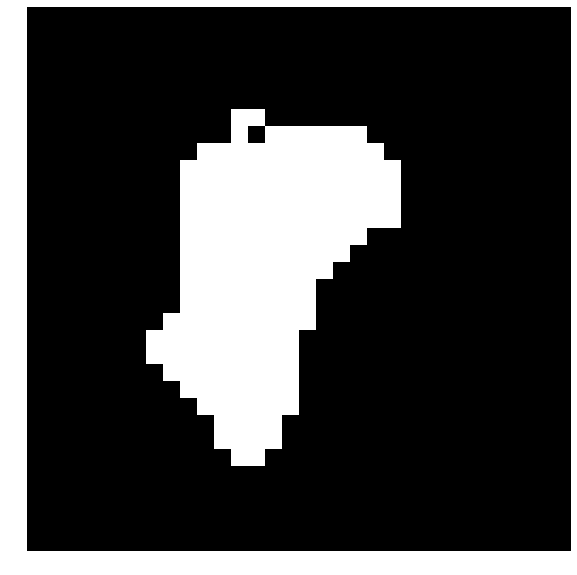

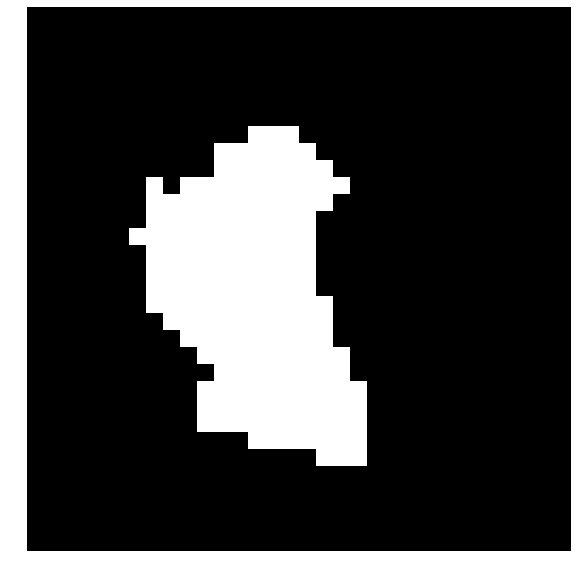

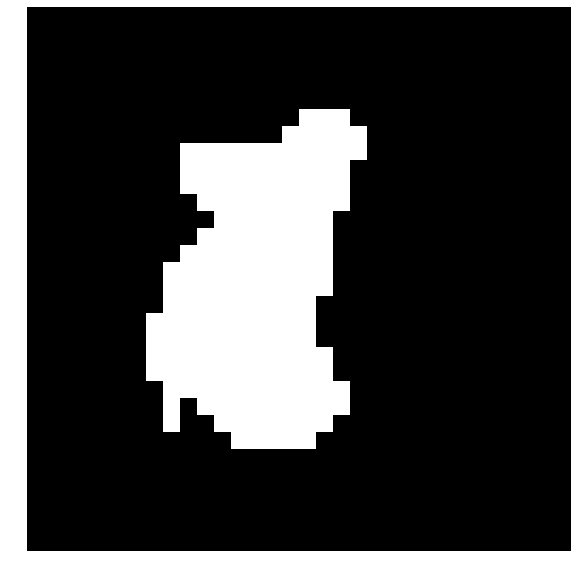

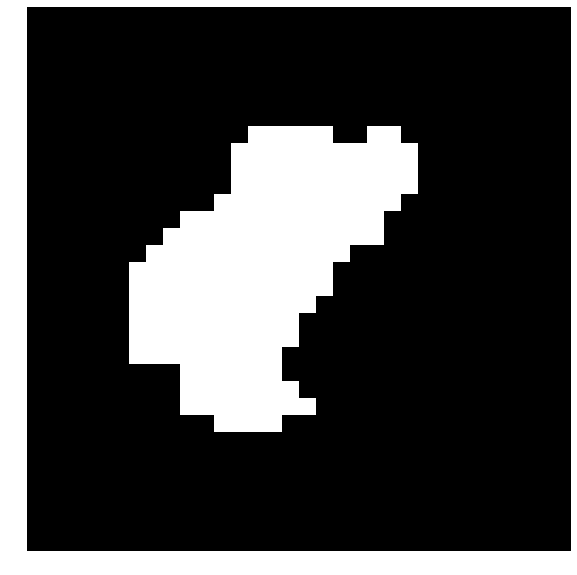

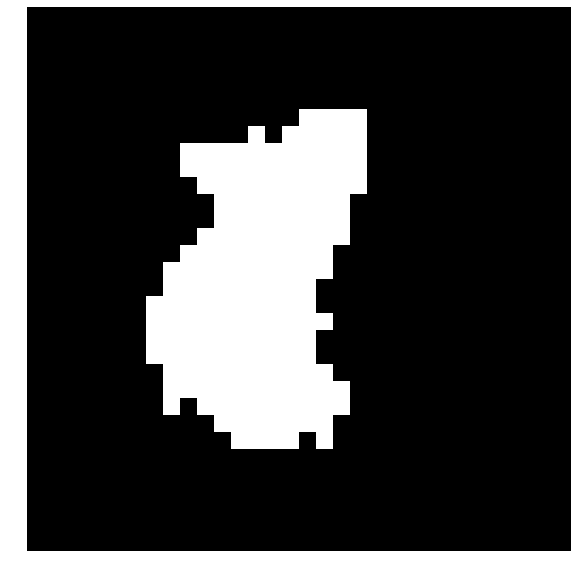

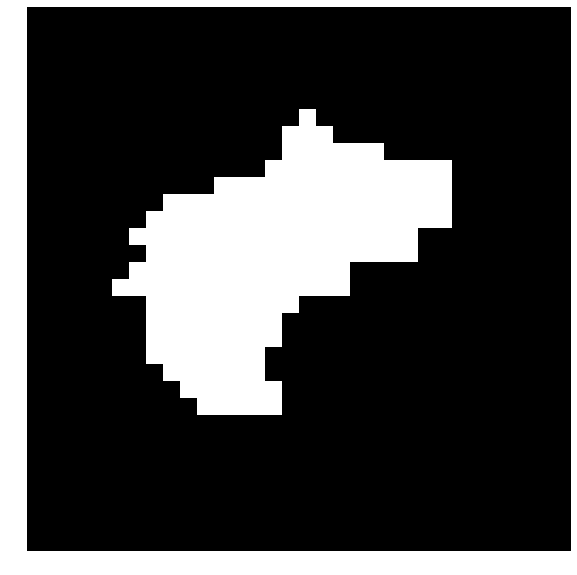

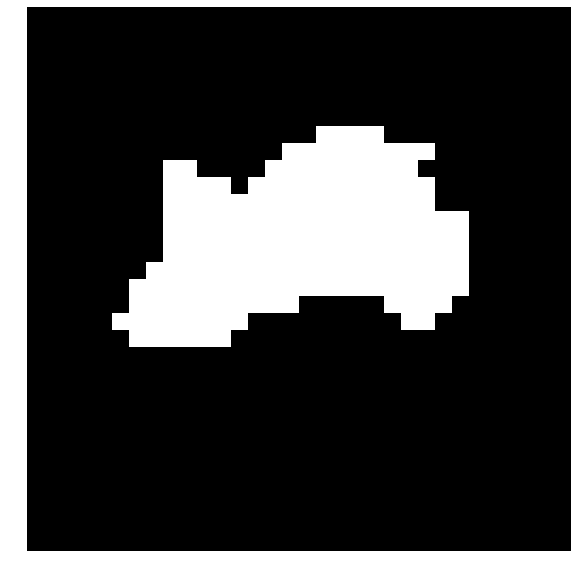

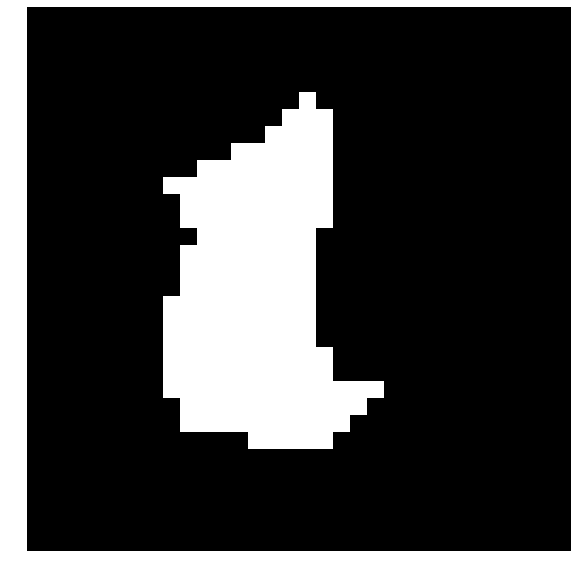

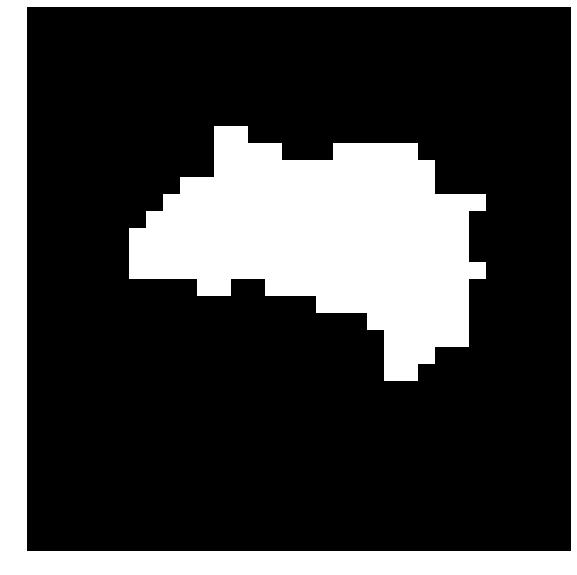

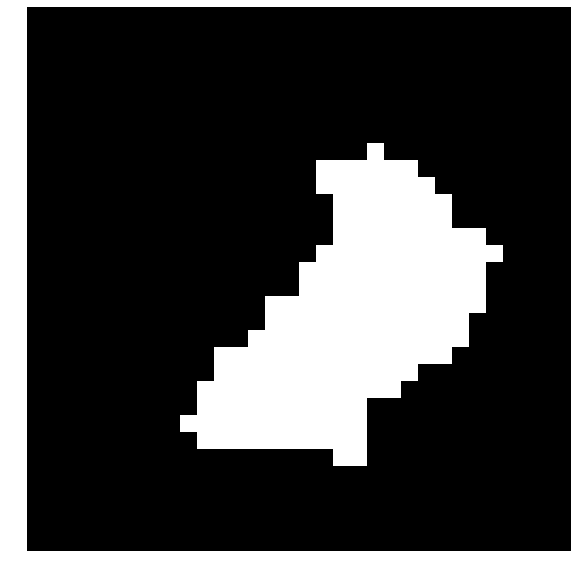

In [11]:
for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.imshow(train_aug(image=img)['image'])
    plt.axis('off')
    plt.savefig('{}_aug'.format(i))

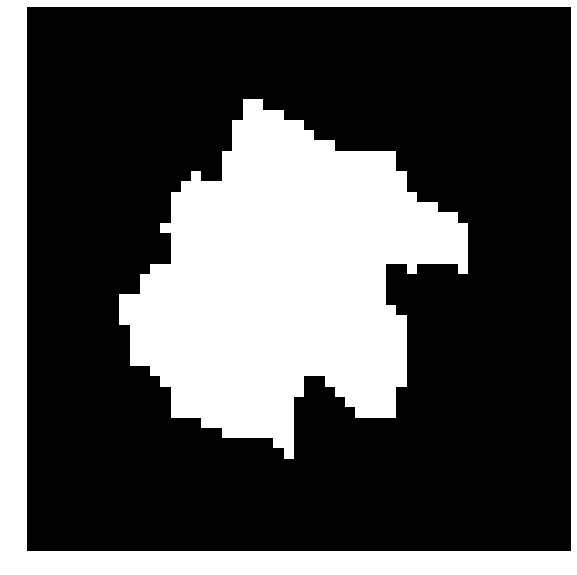

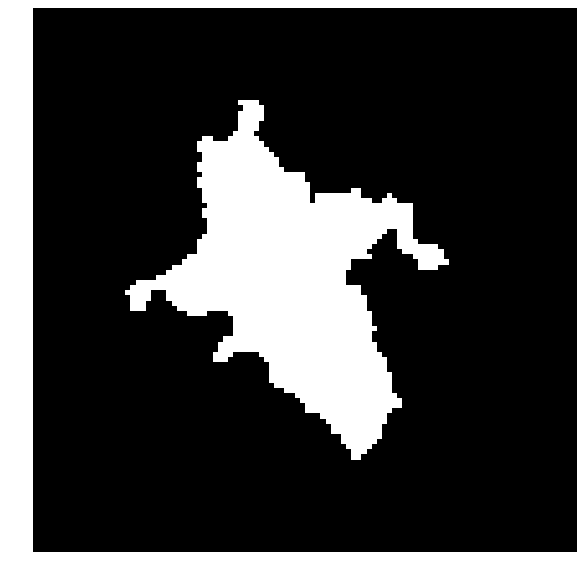

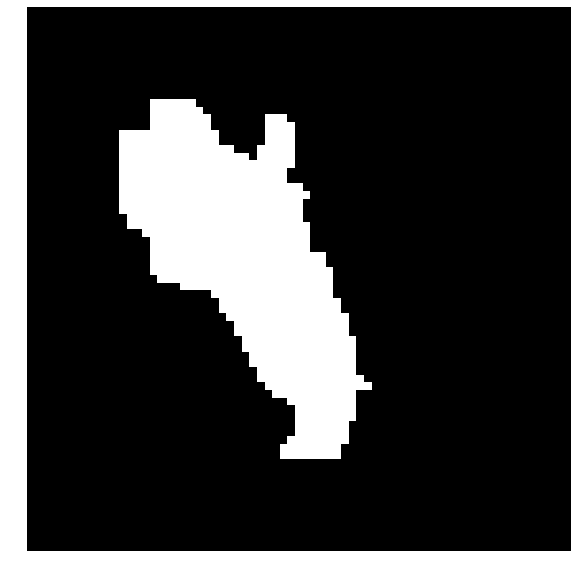

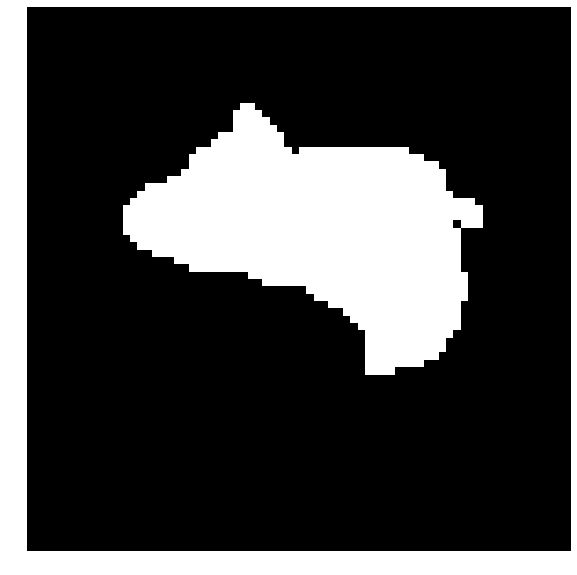

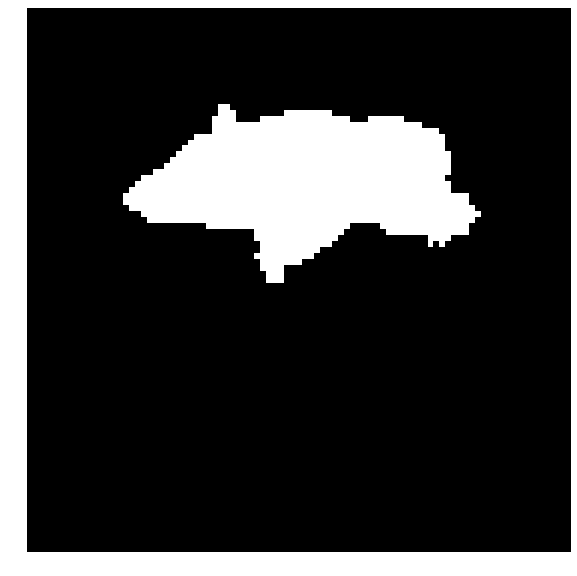

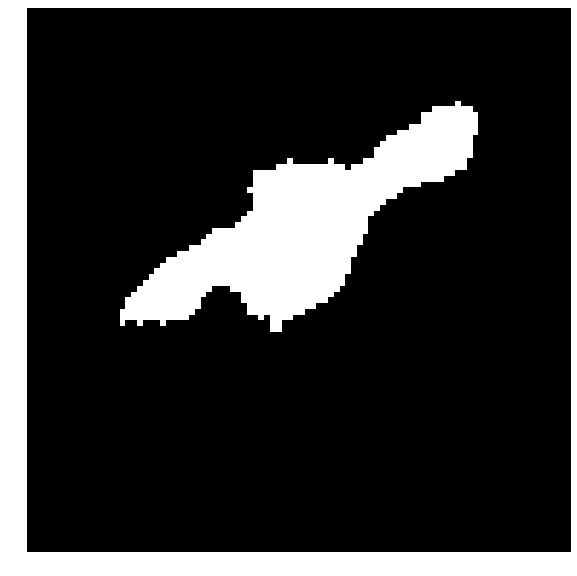

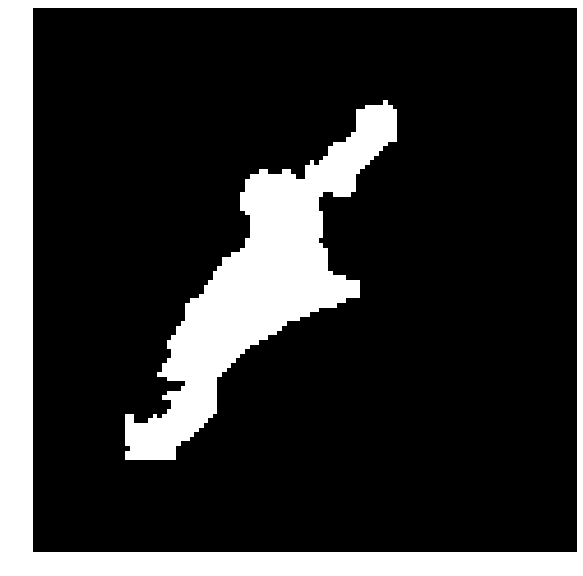

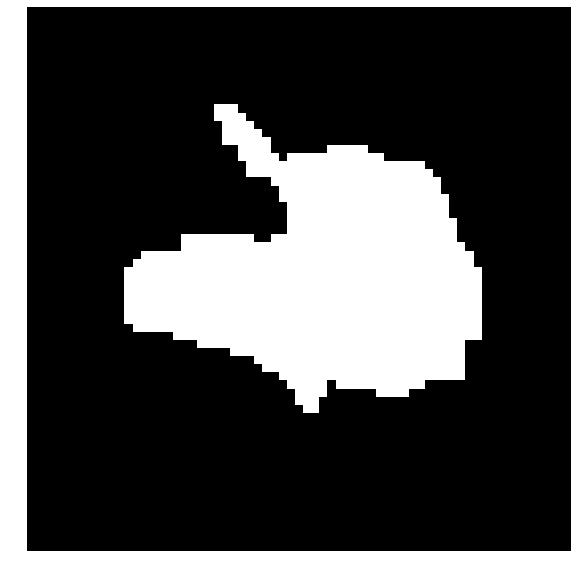

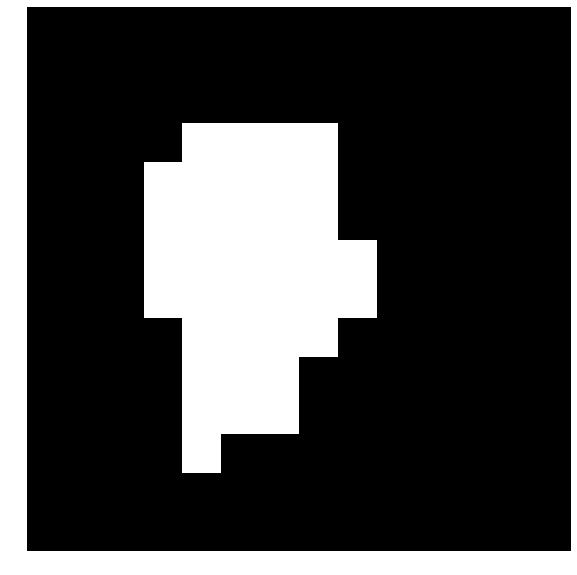

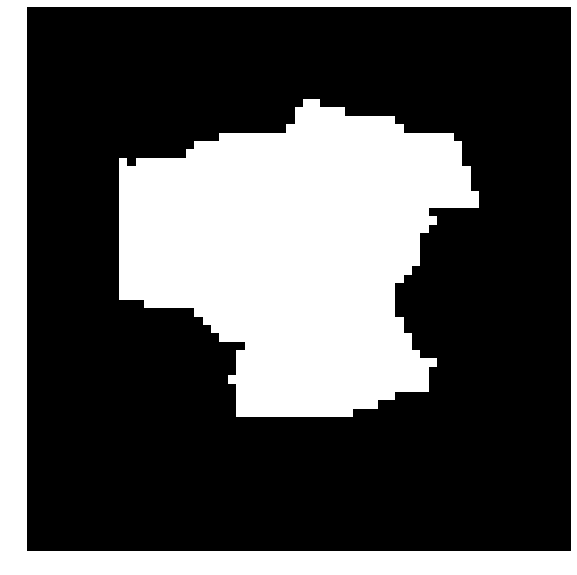

In [12]:
for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.imshow(images[i])
    plt.axis('off')
    plt.savefig('{}'.format(i))

In [13]:
# h = 0
# w = 0

# for img in images:
#     h = max(h, img.shape[0])
#     w = max(w, img.shape[1])

In [14]:
# img = images[0]

In [15]:
# _ = augment_and_show(train_aug, images[0])

In [16]:
# Y = np.log(Y + 1e-3)

In [17]:
def train(model, device, train_dataloader, optimizer, scheduler, epoch, verbose):
    losses = []
    total = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        if scheduler is not None:
            scheduler.step(epoch)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
#         loss = ((output - target) / (target + eps)).abs().mean()
        total += target.size(0)
        losses.append(loss.item() * target.size(0))
        loss.backward()
        optimizer.step()
        if verbose and (batch_idx % 4) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
    return np.sum(losses) / total

In [18]:
def test(model, device, test_dataloader):
    model.eval()
    test_loss = 0
    total = 0
    preds = []
    gt = []
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target).item() * target.size(0) # sum up batch loss
            total += target.size(0)
            gt.append(target.cpu().data.numpy())
            preds.append(output.cpu().data.numpy())
    test_loss /= total
#     test_loss /= len(test_dataloader.dataset)

    print('\nTest set: Average loss: {:.10f}\n'.format(test_loss))
    return np.concatenate(gt, axis=0), np.concatenate(preds, axis=0)

In [19]:
class MyDataset(Dataset):
    
    def __init__(self, images, targets, aug):
        self.images = images
        self.targets = targets
        self.len = len(images)   
        self.aug = aug
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = self.images[idx]
#         img = np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
        img = augment(self.aug, img)
        img = img.transpose([2, 0, 1]).astype(np.float64)
        return img, self.targets[idx]

In [20]:
use_cuda = True
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
eps = torch.Tensor([1e-6]).double().to(device)

In [21]:
import pickle

def cv(
       folder_name,
       construct_model, 
       train_aug,
       test_aug,
       device, 
       batch_size, 
       learning_rate, 
       lr_decay, 
       epochs_number, 
       verbose):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
        
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
#     train_folds = []
#     test_folds = []
    
#     gt_all_raw = []
    gt_all = []
#     pred_all_raw = []
    pred_all = []
    
    for i, (train_idxes, test_idxes) in enumerate(kfold.split(images, Y)):
        with open(os.path.join(folder_name, 'train_idxes_{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(train_idxes, f)
        with open(os.path.join(folder_name, 'test_idxes_{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(test_idxes, f)
       
        train_images = [images[i] for i in train_idxes]
        test_images = [images[i] for i in test_idxes]
        train_Y_origin = Y[train_idxes]
        test_Y_origin = Y[test_idxes]
        
        model = construct_model().double().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** epoch)

        Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
        train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
        test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

        train_perfomance = []
        test_perfomance_raw = []
        test_perfomance = []
        for epoch in range(1, epochs_number):
            train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
            train_dataloader = DataLoader(train_dataset, 
                                          batch_size=batch_size(epoch), 
                                          shuffle=True, 
                                          num_workers=10, 
                                          pin_memory=True)

            test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
            test_dataloader = DataLoader(test_dataset, 
                                         batch_size=batch_size(epoch), 
                                         shuffle=False, 
                                         num_workers=10, 
                                         pin_memory=True)
            _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, verbose)
            train_perfomance.append(_)
            gt, pred = test(model, device, test_dataloader)
            test_perfomance_raw.append(((gt - pred) ** 2).mean())
            test_perfomance.append(
                ((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
                  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean()
            )
        gt_all.extend(list(Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten()))
        pred_all.extend(list(Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()))
        
        with open(os.path.join(folder_name, 'train_perf_{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(train_perfomance, f)
        with open(os.path.join(folder_name, 'test_perf_raw_{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(test_perfomance_raw, f)
        with open(os.path.join(folder_name, 'test_perf_{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(test_perfomance, f)
        torch.save(model.state_dict(), os.path.join(folder_name, 'model_{}.pkl'.format(i)))
        
        plt.figure(figsize=(5, 5))
        plt.plot(np.arange(len(train_perfomance)), train_perfomance)
        plt.plot(np.arange(len(test_perfomance_raw)), test_perfomance_raw)
        plt.yscale('log')
#         plt.legend(['train', 'test'])
        plt.show()

#         train_folds.append(train_perfomance[-1])
#         test_folds.append(test_perfomance[-1])
   
    with open(os.path.join(folder_name, 'gt.pkl'), 'wb') as f:
        pickle.dump(gt_all, f)
    with open(os.path.join(folder_name, 'pred.pkl'), 'wb') as f:
        pickle.dump(pred_all, f)
    return gt_all, pred_all
#     return train_folds, test_folds 

In [22]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

In [23]:
d = {
    'folder_name': 'carb_cv',
    'device': device,
#     'construct_model': lambda : ConvNet(h, w, 3, nonlinearity=F.relu, pad=0),
    'construct_model': lambda : PretrainedNet(models.resnet34, pretrained=True),
    'train_aug': train_aug,
    'test_aug': test_aug,
    'batch_size': lambda epoch: 64,
#     'batch_size': lambda epoch: min(1000, 64 * 2 ** (epoch // 10)),
#     'scheduler': scheduler,
    'learning_rate': 1e-3,
    'lr_decay': 0.95,
    'epochs_number': 100,
    'verbose': True,
}

Train Epoch: 1 [0/975 (0%)]	Loss: 1.43006155
Train Epoch: 1 [256/975 (25%)]	Loss: 4.15286801
Train Epoch: 1 [512/975 (50%)]	Loss: 1.17944332
Train Epoch: 1 [768/975 (75%)]	Loss: 1.04909724

Test set: Average loss: 136.8434222094

Train Epoch: 2 [0/975 (0%)]	Loss: 0.95708917
Train Epoch: 2 [256/975 (25%)]	Loss: 0.72366495
Train Epoch: 2 [512/975 (50%)]	Loss: 0.45783218
Train Epoch: 2 [768/975 (75%)]	Loss: 0.37019010

Test set: Average loss: 1.2212705531

Train Epoch: 3 [0/975 (0%)]	Loss: 0.40289231
Train Epoch: 3 [256/975 (25%)]	Loss: 0.58882384
Train Epoch: 3 [512/975 (50%)]	Loss: 0.28483863
Train Epoch: 3 [768/975 (75%)]	Loss: 0.27500595

Test set: Average loss: 0.6334520720

Train Epoch: 4 [0/975 (0%)]	Loss: 0.41526390
Train Epoch: 4 [256/975 (25%)]	Loss: 0.21307926
Train Epoch: 4 [512/975 (50%)]	Loss: 0.29788918
Train Epoch: 4 [768/975 (75%)]	Loss: 0.22936581

Test set: Average loss: 0.3063258212

Train Epoch: 5 [0/975 (0%)]	Loss: 0.28238351
Train Epoch: 5 [256/975 (25%)]	Loss: 0.22

Train Epoch: 36 [768/975 (75%)]	Loss: 0.05316737

Test set: Average loss: 0.0379678987

Train Epoch: 37 [0/975 (0%)]	Loss: 0.05518360
Train Epoch: 37 [256/975 (25%)]	Loss: 0.07325684
Train Epoch: 37 [512/975 (50%)]	Loss: 0.04751585
Train Epoch: 37 [768/975 (75%)]	Loss: 0.08839087

Test set: Average loss: 0.0316640350

Train Epoch: 38 [0/975 (0%)]	Loss: 0.07045469
Train Epoch: 38 [256/975 (25%)]	Loss: 0.10710584
Train Epoch: 38 [512/975 (50%)]	Loss: 0.06056524
Train Epoch: 38 [768/975 (75%)]	Loss: 0.04056526

Test set: Average loss: 0.0241620616

Train Epoch: 39 [0/975 (0%)]	Loss: 0.05246153
Train Epoch: 39 [256/975 (25%)]	Loss: 0.07091740
Train Epoch: 39 [512/975 (50%)]	Loss: 0.04331510
Train Epoch: 39 [768/975 (75%)]	Loss: 0.03795634

Test set: Average loss: 0.0288142117

Train Epoch: 40 [0/975 (0%)]	Loss: 0.06995574
Train Epoch: 40 [256/975 (25%)]	Loss: 0.04414577
Train Epoch: 40 [512/975 (50%)]	Loss: 0.06854261
Train Epoch: 40 [768/975 (75%)]	Loss: 0.03477552

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.04428565
Train Epoch: 72 [256/975 (25%)]	Loss: 0.02690821
Train Epoch: 72 [512/975 (50%)]	Loss: 0.02551624
Train Epoch: 72 [768/975 (75%)]	Loss: 0.06130827

Test set: Average loss: 0.0209563764

Train Epoch: 73 [0/975 (0%)]	Loss: 0.02838540
Train Epoch: 73 [256/975 (25%)]	Loss: 0.11075360
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02508562
Train Epoch: 73 [768/975 (75%)]	Loss: 0.06142203

Test set: Average loss: 0.0211517504

Train Epoch: 74 [0/975 (0%)]	Loss: 0.03864139
Train Epoch: 74 [256/975 (25%)]	Loss: 0.05059254
Train Epoch: 74 [512/975 (50%)]	Loss: 0.09315671
Train Epoch: 74 [768/975 (75%)]	Loss: 0.05040367

Test set: Average loss: 0.0247977357

Train Epoch: 75 [0/975 (0%)]	Loss: 0.05058094
Train Epoch: 75 [256/975 (25%)]	Loss: 0.02037401
Train Epoch: 75 [512/975 (50%)]	Loss: 0.02845089
Train Epoch: 75 [768/975 (75%)]	Loss: 0.08424301

Test set: Average loss: 0.0148006237

Train Epoch: 76 [0/975 (0%)]	Loss: 0.05611394
Train Epoch: 76 [256/975 (

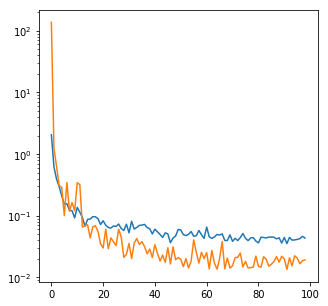

Train Epoch: 1 [0/975 (0%)]	Loss: 1.56144128
Train Epoch: 1 [256/975 (25%)]	Loss: 6.62836323
Train Epoch: 1 [512/975 (50%)]	Loss: 1.46531852
Train Epoch: 1 [768/975 (75%)]	Loss: 0.94200088

Test set: Average loss: 183.9924442527

Train Epoch: 2 [0/975 (0%)]	Loss: 0.68020539
Train Epoch: 2 [256/975 (25%)]	Loss: 0.84161394
Train Epoch: 2 [512/975 (50%)]	Loss: 0.75742842
Train Epoch: 2 [768/975 (75%)]	Loss: 0.43873743

Test set: Average loss: 16.2392353417

Train Epoch: 3 [0/975 (0%)]	Loss: 0.30297566
Train Epoch: 3 [256/975 (25%)]	Loss: 0.28442103
Train Epoch: 3 [512/975 (50%)]	Loss: 0.25848133
Train Epoch: 3 [768/975 (75%)]	Loss: 0.20617684

Test set: Average loss: 0.3719638579

Train Epoch: 4 [0/975 (0%)]	Loss: 0.27662822
Train Epoch: 4 [256/975 (25%)]	Loss: 0.30104722
Train Epoch: 4 [512/975 (50%)]	Loss: 0.27015213
Train Epoch: 4 [768/975 (75%)]	Loss: 0.21428050

Test set: Average loss: 0.2817406595

Train Epoch: 5 [0/975 (0%)]	Loss: 0.41950838
Train Epoch: 5 [256/975 (25%)]	Loss: 0.2

Train Epoch: 36 [768/975 (75%)]	Loss: 0.08812128

Test set: Average loss: 0.0320747714

Train Epoch: 37 [0/975 (0%)]	Loss: 0.04695904
Train Epoch: 37 [256/975 (25%)]	Loss: 0.04498044
Train Epoch: 37 [512/975 (50%)]	Loss: 0.03088279
Train Epoch: 37 [768/975 (75%)]	Loss: 0.04566040

Test set: Average loss: 0.0525027281

Train Epoch: 38 [0/975 (0%)]	Loss: 0.04996648
Train Epoch: 38 [256/975 (25%)]	Loss: 0.03757570
Train Epoch: 38 [512/975 (50%)]	Loss: 0.04056684
Train Epoch: 38 [768/975 (75%)]	Loss: 0.07128999

Test set: Average loss: 0.0578324472

Train Epoch: 39 [0/975 (0%)]	Loss: 0.02865246
Train Epoch: 39 [256/975 (25%)]	Loss: 0.04819873
Train Epoch: 39 [512/975 (50%)]	Loss: 0.06517576
Train Epoch: 39 [768/975 (75%)]	Loss: 0.09633816

Test set: Average loss: 0.0377645125

Train Epoch: 40 [0/975 (0%)]	Loss: 0.06067416
Train Epoch: 40 [256/975 (25%)]	Loss: 0.05868428
Train Epoch: 40 [512/975 (50%)]	Loss: 0.03617938
Train Epoch: 40 [768/975 (75%)]	Loss: 0.05494869

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.03308092
Train Epoch: 72 [256/975 (25%)]	Loss: 0.06564440
Train Epoch: 72 [512/975 (50%)]	Loss: 0.03429981
Train Epoch: 72 [768/975 (75%)]	Loss: 0.08073047

Test set: Average loss: 0.0199130003

Train Epoch: 73 [0/975 (0%)]	Loss: 0.03598112
Train Epoch: 73 [256/975 (25%)]	Loss: 0.03069856
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02234778
Train Epoch: 73 [768/975 (75%)]	Loss: 0.04454428

Test set: Average loss: 0.0212165224

Train Epoch: 74 [0/975 (0%)]	Loss: 0.02687653
Train Epoch: 74 [256/975 (25%)]	Loss: 0.03328832
Train Epoch: 74 [512/975 (50%)]	Loss: 0.06407075
Train Epoch: 74 [768/975 (75%)]	Loss: 0.05431079

Test set: Average loss: 0.0219044769

Train Epoch: 75 [0/975 (0%)]	Loss: 0.03140630
Train Epoch: 75 [256/975 (25%)]	Loss: 0.05846236
Train Epoch: 75 [512/975 (50%)]	Loss: 0.04514783
Train Epoch: 75 [768/975 (75%)]	Loss: 0.03300260

Test set: Average loss: 0.0217942635

Train Epoch: 76 [0/975 (0%)]	Loss: 0.04160572
Train Epoch: 76 [256/975 (

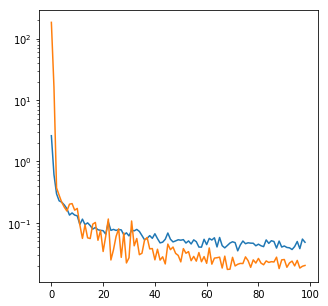

Train Epoch: 1 [0/975 (0%)]	Loss: 1.00217207
Train Epoch: 1 [256/975 (25%)]	Loss: 7.11732081
Train Epoch: 1 [512/975 (50%)]	Loss: 1.63967481
Train Epoch: 1 [768/975 (75%)]	Loss: 1.18164088

Test set: Average loss: 1967.1424730504

Train Epoch: 2 [0/975 (0%)]	Loss: 0.96877681
Train Epoch: 2 [256/975 (25%)]	Loss: 0.92295303
Train Epoch: 2 [512/975 (50%)]	Loss: 1.00772168
Train Epoch: 2 [768/975 (75%)]	Loss: 0.70359570

Test set: Average loss: 0.9151641389

Train Epoch: 3 [0/975 (0%)]	Loss: 0.62476755
Train Epoch: 3 [256/975 (25%)]	Loss: 0.55675281
Train Epoch: 3 [512/975 (50%)]	Loss: 0.34080562
Train Epoch: 3 [768/975 (75%)]	Loss: 0.35091812

Test set: Average loss: 1.0950766912

Train Epoch: 4 [0/975 (0%)]	Loss: 0.33105693
Train Epoch: 4 [256/975 (25%)]	Loss: 0.38552106
Train Epoch: 4 [512/975 (50%)]	Loss: 0.40513684
Train Epoch: 4 [768/975 (75%)]	Loss: 0.38500177

Test set: Average loss: 0.4612043517

Train Epoch: 5 [0/975 (0%)]	Loss: 0.32621223
Train Epoch: 5 [256/975 (25%)]	Loss: 0.1

Train Epoch: 36 [768/975 (75%)]	Loss: 0.03392372

Test set: Average loss: 0.0405009280

Train Epoch: 37 [0/975 (0%)]	Loss: 0.03844964
Train Epoch: 37 [256/975 (25%)]	Loss: 0.07084297
Train Epoch: 37 [512/975 (50%)]	Loss: 0.03600523
Train Epoch: 37 [768/975 (75%)]	Loss: 0.04575464

Test set: Average loss: 0.0352844702

Train Epoch: 38 [0/975 (0%)]	Loss: 0.03820382
Train Epoch: 38 [256/975 (25%)]	Loss: 0.03376098
Train Epoch: 38 [512/975 (50%)]	Loss: 0.04562882
Train Epoch: 38 [768/975 (75%)]	Loss: 0.05552886

Test set: Average loss: 0.0199569036

Train Epoch: 39 [0/975 (0%)]	Loss: 0.03069887
Train Epoch: 39 [256/975 (25%)]	Loss: 0.06480306
Train Epoch: 39 [512/975 (50%)]	Loss: 0.02962671
Train Epoch: 39 [768/975 (75%)]	Loss: 0.05178144

Test set: Average loss: 0.0559462894

Train Epoch: 40 [0/975 (0%)]	Loss: 0.03862132
Train Epoch: 40 [256/975 (25%)]	Loss: 0.03799443
Train Epoch: 40 [512/975 (50%)]	Loss: 0.09530227
Train Epoch: 40 [768/975 (75%)]	Loss: 0.05504587

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.03245632
Train Epoch: 72 [256/975 (25%)]	Loss: 0.05580673
Train Epoch: 72 [512/975 (50%)]	Loss: 0.05181275
Train Epoch: 72 [768/975 (75%)]	Loss: 0.02911354

Test set: Average loss: 0.0158090578

Train Epoch: 73 [0/975 (0%)]	Loss: 0.03731104
Train Epoch: 73 [256/975 (25%)]	Loss: 0.06539285
Train Epoch: 73 [512/975 (50%)]	Loss: 0.06815162
Train Epoch: 73 [768/975 (75%)]	Loss: 0.03665763

Test set: Average loss: 0.0147886672

Train Epoch: 74 [0/975 (0%)]	Loss: 0.07441488
Train Epoch: 74 [256/975 (25%)]	Loss: 0.11795707
Train Epoch: 74 [512/975 (50%)]	Loss: 0.03314301
Train Epoch: 74 [768/975 (75%)]	Loss: 0.03259247

Test set: Average loss: 0.0152024191

Train Epoch: 75 [0/975 (0%)]	Loss: 0.10420674
Train Epoch: 75 [256/975 (25%)]	Loss: 0.03537441
Train Epoch: 75 [512/975 (50%)]	Loss: 0.03636195
Train Epoch: 75 [768/975 (75%)]	Loss: 0.03443689

Test set: Average loss: 0.0147674866

Train Epoch: 76 [0/975 (0%)]	Loss: 0.02793700
Train Epoch: 76 [256/975 (

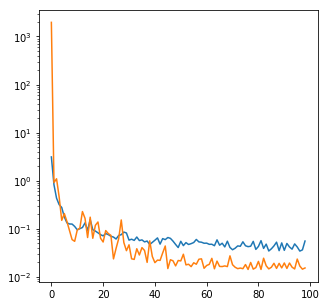

Train Epoch: 1 [0/975 (0%)]	Loss: 2.56136847
Train Epoch: 1 [256/975 (25%)]	Loss: 5.67397661
Train Epoch: 1 [512/975 (50%)]	Loss: 1.30886410
Train Epoch: 1 [768/975 (75%)]	Loss: 0.87663177

Test set: Average loss: 37.9602123806

Train Epoch: 2 [0/975 (0%)]	Loss: 1.23151068
Train Epoch: 2 [256/975 (25%)]	Loss: 0.87214062
Train Epoch: 2 [512/975 (50%)]	Loss: 0.73953912
Train Epoch: 2 [768/975 (75%)]	Loss: 0.95271719

Test set: Average loss: 1.2011495960

Train Epoch: 3 [0/975 (0%)]	Loss: 1.17297735
Train Epoch: 3 [256/975 (25%)]	Loss: 0.74634484
Train Epoch: 3 [512/975 (50%)]	Loss: 0.65283247
Train Epoch: 3 [768/975 (75%)]	Loss: 0.76771411

Test set: Average loss: 4.2276667817

Train Epoch: 4 [0/975 (0%)]	Loss: 0.72369481
Train Epoch: 4 [256/975 (25%)]	Loss: 0.65606838
Train Epoch: 4 [512/975 (50%)]	Loss: 0.48685893
Train Epoch: 4 [768/975 (75%)]	Loss: 0.43808951

Test set: Average loss: 1.5342357528

Train Epoch: 5 [0/975 (0%)]	Loss: 0.40651653
Train Epoch: 5 [256/975 (25%)]	Loss: 0.315

Train Epoch: 36 [768/975 (75%)]	Loss: 0.05416626

Test set: Average loss: 0.0442017677

Train Epoch: 37 [0/975 (0%)]	Loss: 0.02857075
Train Epoch: 37 [256/975 (25%)]	Loss: 0.03971285
Train Epoch: 37 [512/975 (50%)]	Loss: 0.07576705
Train Epoch: 37 [768/975 (75%)]	Loss: 0.08493893

Test set: Average loss: 0.0379600811

Train Epoch: 38 [0/975 (0%)]	Loss: 0.04864001
Train Epoch: 38 [256/975 (25%)]	Loss: 0.03400001
Train Epoch: 38 [512/975 (50%)]	Loss: 0.04185838
Train Epoch: 38 [768/975 (75%)]	Loss: 0.08427514

Test set: Average loss: 0.0651845400

Train Epoch: 39 [0/975 (0%)]	Loss: 0.15139943
Train Epoch: 39 [256/975 (25%)]	Loss: 0.11393571
Train Epoch: 39 [512/975 (50%)]	Loss: 0.04913424
Train Epoch: 39 [768/975 (75%)]	Loss: 0.04002731

Test set: Average loss: 0.0518691229

Train Epoch: 40 [0/975 (0%)]	Loss: 0.06069007
Train Epoch: 40 [256/975 (25%)]	Loss: 0.05025344
Train Epoch: 40 [512/975 (50%)]	Loss: 0.07166674
Train Epoch: 40 [768/975 (75%)]	Loss: 0.09669357

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.03054930
Train Epoch: 72 [256/975 (25%)]	Loss: 0.04248396
Train Epoch: 72 [512/975 (50%)]	Loss: 0.04557439
Train Epoch: 72 [768/975 (75%)]	Loss: 0.07479183

Test set: Average loss: 0.0209690932

Train Epoch: 73 [0/975 (0%)]	Loss: 0.08653065
Train Epoch: 73 [256/975 (25%)]	Loss: 0.04539593
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02241548
Train Epoch: 73 [768/975 (75%)]	Loss: 0.04058567

Test set: Average loss: 0.0188903139

Train Epoch: 74 [0/975 (0%)]	Loss: 0.04086891
Train Epoch: 74 [256/975 (25%)]	Loss: 0.04541011
Train Epoch: 74 [512/975 (50%)]	Loss: 0.10011621
Train Epoch: 74 [768/975 (75%)]	Loss: 0.03320714

Test set: Average loss: 0.0245410163

Train Epoch: 75 [0/975 (0%)]	Loss: 0.02327743
Train Epoch: 75 [256/975 (25%)]	Loss: 0.05735339
Train Epoch: 75 [512/975 (50%)]	Loss: 0.03196678
Train Epoch: 75 [768/975 (75%)]	Loss: 0.08394936

Test set: Average loss: 0.0317299654

Train Epoch: 76 [0/975 (0%)]	Loss: 0.02907778
Train Epoch: 76 [256/975 (

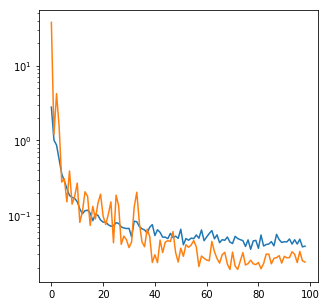

Train Epoch: 1 [0/976 (0%)]	Loss: 1.37689464
Train Epoch: 1 [256/976 (25%)]	Loss: 4.47345549
Train Epoch: 1 [512/976 (50%)]	Loss: 1.33274779
Train Epoch: 1 [768/976 (75%)]	Loss: 1.03229934

Test set: Average loss: 4.2868542000

Train Epoch: 2 [0/976 (0%)]	Loss: 1.06839027
Train Epoch: 2 [256/976 (25%)]	Loss: 0.70145535
Train Epoch: 2 [512/976 (50%)]	Loss: 0.93782076
Train Epoch: 2 [768/976 (75%)]	Loss: 0.77681000

Test set: Average loss: 1.0218819714

Train Epoch: 3 [0/976 (0%)]	Loss: 0.74466403
Train Epoch: 3 [256/976 (25%)]	Loss: 0.64935452
Train Epoch: 3 [512/976 (50%)]	Loss: 0.50784223
Train Epoch: 3 [768/976 (75%)]	Loss: 0.55057777

Test set: Average loss: 4.5473054504

Train Epoch: 4 [0/976 (0%)]	Loss: 0.33575117
Train Epoch: 4 [256/976 (25%)]	Loss: 0.36959897
Train Epoch: 4 [512/976 (50%)]	Loss: 0.28959055
Train Epoch: 4 [768/976 (75%)]	Loss: 0.31138961

Test set: Average loss: 0.6208981747

Train Epoch: 5 [0/976 (0%)]	Loss: 0.27705804
Train Epoch: 5 [256/976 (25%)]	Loss: 0.1575

Train Epoch: 36 [768/976 (75%)]	Loss: 0.12711917

Test set: Average loss: 0.0307229819

Train Epoch: 37 [0/976 (0%)]	Loss: 0.07275921
Train Epoch: 37 [256/976 (25%)]	Loss: 0.05644906
Train Epoch: 37 [512/976 (50%)]	Loss: 0.02989761
Train Epoch: 37 [768/976 (75%)]	Loss: 0.04130548

Test set: Average loss: 0.0355442352

Train Epoch: 38 [0/976 (0%)]	Loss: 0.05513291
Train Epoch: 38 [256/976 (25%)]	Loss: 0.04937281
Train Epoch: 38 [512/976 (50%)]	Loss: 0.02290177
Train Epoch: 38 [768/976 (75%)]	Loss: 0.03519879

Test set: Average loss: 0.0419587204

Train Epoch: 39 [0/976 (0%)]	Loss: 0.09868291
Train Epoch: 39 [256/976 (25%)]	Loss: 0.03987941
Train Epoch: 39 [512/976 (50%)]	Loss: 0.10624221
Train Epoch: 39 [768/976 (75%)]	Loss: 0.05346745

Test set: Average loss: 0.0244223532

Train Epoch: 40 [0/976 (0%)]	Loss: 0.04959694
Train Epoch: 40 [256/976 (25%)]	Loss: 0.04712723
Train Epoch: 40 [512/976 (50%)]	Loss: 0.02733350
Train Epoch: 40 [768/976 (75%)]	Loss: 0.11543872

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.05748015
Train Epoch: 72 [256/976 (25%)]	Loss: 0.05233127
Train Epoch: 72 [512/976 (50%)]	Loss: 0.05586665
Train Epoch: 72 [768/976 (75%)]	Loss: 0.02046654

Test set: Average loss: 0.0128373386

Train Epoch: 73 [0/976 (0%)]	Loss: 0.11418242
Train Epoch: 73 [256/976 (25%)]	Loss: 0.04178966
Train Epoch: 73 [512/976 (50%)]	Loss: 0.07909663
Train Epoch: 73 [768/976 (75%)]	Loss: 0.05192113

Test set: Average loss: 0.0134908323

Train Epoch: 74 [0/976 (0%)]	Loss: 0.02897913
Train Epoch: 74 [256/976 (25%)]	Loss: 0.02633531
Train Epoch: 74 [512/976 (50%)]	Loss: 0.02768158
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03703177

Test set: Average loss: 0.0172049787

Train Epoch: 75 [0/976 (0%)]	Loss: 0.07576577
Train Epoch: 75 [256/976 (25%)]	Loss: 0.09221013
Train Epoch: 75 [512/976 (50%)]	Loss: 0.04747619
Train Epoch: 75 [768/976 (75%)]	Loss: 0.10445037

Test set: Average loss: 0.0179506771

Train Epoch: 76 [0/976 (0%)]	Loss: 0.02653932
Train Epoch: 76 [256/976 (

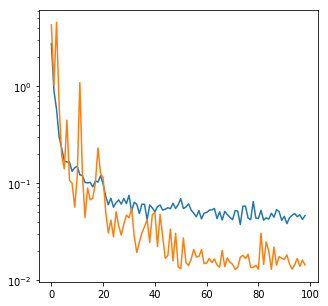

Train Epoch: 1 [0/976 (0%)]	Loss: 2.16544600
Train Epoch: 1 [256/976 (25%)]	Loss: 4.41601578
Train Epoch: 1 [512/976 (50%)]	Loss: 1.23512363
Train Epoch: 1 [768/976 (75%)]	Loss: 0.97675556

Test set: Average loss: 1.8549569608

Train Epoch: 2 [0/976 (0%)]	Loss: 1.13988263
Train Epoch: 2 [256/976 (25%)]	Loss: 0.91611774
Train Epoch: 2 [512/976 (50%)]	Loss: 0.56783729
Train Epoch: 2 [768/976 (75%)]	Loss: 0.55577378

Test set: Average loss: 0.5910029901

Train Epoch: 3 [0/976 (0%)]	Loss: 0.43182844
Train Epoch: 3 [256/976 (25%)]	Loss: 0.40969308
Train Epoch: 3 [512/976 (50%)]	Loss: 0.33568338
Train Epoch: 3 [768/976 (75%)]	Loss: 0.22189658

Test set: Average loss: 1.5323161645

Train Epoch: 4 [0/976 (0%)]	Loss: 0.26306747
Train Epoch: 4 [256/976 (25%)]	Loss: 0.25541694
Train Epoch: 4 [512/976 (50%)]	Loss: 0.22517668
Train Epoch: 4 [768/976 (75%)]	Loss: 0.12973400

Test set: Average loss: 0.1903269159

Train Epoch: 5 [0/976 (0%)]	Loss: 0.16578371
Train Epoch: 5 [256/976 (25%)]	Loss: 0.1487

Train Epoch: 36 [768/976 (75%)]	Loss: 0.04087604

Test set: Average loss: 0.1127238572

Train Epoch: 37 [0/976 (0%)]	Loss: 0.10893942
Train Epoch: 37 [256/976 (25%)]	Loss: 0.03819699
Train Epoch: 37 [512/976 (50%)]	Loss: 0.06442957
Train Epoch: 37 [768/976 (75%)]	Loss: 0.12716250

Test set: Average loss: 0.0268677224

Train Epoch: 38 [0/976 (0%)]	Loss: 0.14611455
Train Epoch: 38 [256/976 (25%)]	Loss: 0.04517119
Train Epoch: 38 [512/976 (50%)]	Loss: 0.04883032
Train Epoch: 38 [768/976 (75%)]	Loss: 0.04845390

Test set: Average loss: 0.0311440989

Train Epoch: 39 [0/976 (0%)]	Loss: 0.08067053
Train Epoch: 39 [256/976 (25%)]	Loss: 0.05223331
Train Epoch: 39 [512/976 (50%)]	Loss: 0.13502107
Train Epoch: 39 [768/976 (75%)]	Loss: 0.06441120

Test set: Average loss: 0.1021630981

Train Epoch: 40 [0/976 (0%)]	Loss: 0.02855043
Train Epoch: 40 [256/976 (25%)]	Loss: 0.03481157
Train Epoch: 40 [512/976 (50%)]	Loss: 0.10638575
Train Epoch: 40 [768/976 (75%)]	Loss: 0.03987951

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.03764058
Train Epoch: 72 [256/976 (25%)]	Loss: 0.07886247
Train Epoch: 72 [512/976 (50%)]	Loss: 0.03245995
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03584423

Test set: Average loss: 0.0248761995

Train Epoch: 73 [0/976 (0%)]	Loss: 0.08700065
Train Epoch: 73 [256/976 (25%)]	Loss: 0.05794170
Train Epoch: 73 [512/976 (50%)]	Loss: 0.03582057
Train Epoch: 73 [768/976 (75%)]	Loss: 0.03718728

Test set: Average loss: 0.0278515792

Train Epoch: 74 [0/976 (0%)]	Loss: 0.03244299
Train Epoch: 74 [256/976 (25%)]	Loss: 0.04464833
Train Epoch: 74 [512/976 (50%)]	Loss: 0.03019397
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03111851

Test set: Average loss: 0.0225344695

Train Epoch: 75 [0/976 (0%)]	Loss: 0.06202203
Train Epoch: 75 [256/976 (25%)]	Loss: 0.06699393
Train Epoch: 75 [512/976 (50%)]	Loss: 0.03411234
Train Epoch: 75 [768/976 (75%)]	Loss: 0.03532111

Test set: Average loss: 0.0314524281

Train Epoch: 76 [0/976 (0%)]	Loss: 0.02155165
Train Epoch: 76 [256/976 (

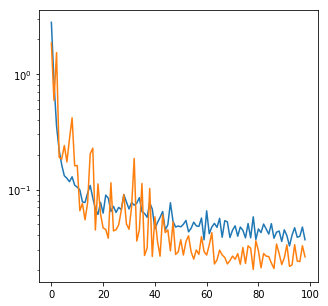

Train Epoch: 1 [0/976 (0%)]	Loss: 2.16582336
Train Epoch: 1 [256/976 (25%)]	Loss: 8.97080481
Train Epoch: 1 [512/976 (50%)]	Loss: 1.47499318
Train Epoch: 1 [768/976 (75%)]	Loss: 0.89513526

Test set: Average loss: 2.7461674287

Train Epoch: 2 [0/976 (0%)]	Loss: 0.87611134
Train Epoch: 2 [256/976 (25%)]	Loss: 0.98084500
Train Epoch: 2 [512/976 (50%)]	Loss: 0.55628512
Train Epoch: 2 [768/976 (75%)]	Loss: 0.63548969

Test set: Average loss: 0.9268755909

Train Epoch: 3 [0/976 (0%)]	Loss: 0.48439658
Train Epoch: 3 [256/976 (25%)]	Loss: 0.33822191
Train Epoch: 3 [512/976 (50%)]	Loss: 0.23515764
Train Epoch: 3 [768/976 (75%)]	Loss: 0.25044067

Test set: Average loss: 0.2388464487

Train Epoch: 4 [0/976 (0%)]	Loss: 0.19594799
Train Epoch: 4 [256/976 (25%)]	Loss: 0.31671371
Train Epoch: 4 [512/976 (50%)]	Loss: 0.28074968
Train Epoch: 4 [768/976 (75%)]	Loss: 0.17192500

Test set: Average loss: 0.1784759998

Train Epoch: 5 [0/976 (0%)]	Loss: 0.16254781
Train Epoch: 5 [256/976 (25%)]	Loss: 0.2212

Train Epoch: 36 [768/976 (75%)]	Loss: 0.10174500

Test set: Average loss: 0.0256264219

Train Epoch: 37 [0/976 (0%)]	Loss: 0.07162564
Train Epoch: 37 [256/976 (25%)]	Loss: 0.06749934
Train Epoch: 37 [512/976 (50%)]	Loss: 0.05115738
Train Epoch: 37 [768/976 (75%)]	Loss: 0.06622877

Test set: Average loss: 0.0256325601

Train Epoch: 38 [0/976 (0%)]	Loss: 0.04600068
Train Epoch: 38 [256/976 (25%)]	Loss: 0.06574002
Train Epoch: 38 [512/976 (50%)]	Loss: 0.09404814
Train Epoch: 38 [768/976 (75%)]	Loss: 0.07181628

Test set: Average loss: 0.0513857578

Train Epoch: 39 [0/976 (0%)]	Loss: 0.04297703
Train Epoch: 39 [256/976 (25%)]	Loss: 0.04922051
Train Epoch: 39 [512/976 (50%)]	Loss: 0.05741970
Train Epoch: 39 [768/976 (75%)]	Loss: 0.04676518

Test set: Average loss: 0.0304496624

Train Epoch: 40 [0/976 (0%)]	Loss: 0.04673163
Train Epoch: 40 [256/976 (25%)]	Loss: 0.03910141
Train Epoch: 40 [512/976 (50%)]	Loss: 0.04327018
Train Epoch: 40 [768/976 (75%)]	Loss: 0.03651784

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.04311954
Train Epoch: 72 [256/976 (25%)]	Loss: 0.02172807
Train Epoch: 72 [512/976 (50%)]	Loss: 0.06332875
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03732945

Test set: Average loss: 0.0187712355

Train Epoch: 73 [0/976 (0%)]	Loss: 0.02617694
Train Epoch: 73 [256/976 (25%)]	Loss: 0.05083933
Train Epoch: 73 [512/976 (50%)]	Loss: 0.04270491
Train Epoch: 73 [768/976 (75%)]	Loss: 0.02689075

Test set: Average loss: 0.0141865189

Train Epoch: 74 [0/976 (0%)]	Loss: 0.04492805
Train Epoch: 74 [256/976 (25%)]	Loss: 0.04702945
Train Epoch: 74 [512/976 (50%)]	Loss: 0.05003256
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03012725

Test set: Average loss: 0.0167567846

Train Epoch: 75 [0/976 (0%)]	Loss: 0.03174214
Train Epoch: 75 [256/976 (25%)]	Loss: 0.04584536
Train Epoch: 75 [512/976 (50%)]	Loss: 0.01782585
Train Epoch: 75 [768/976 (75%)]	Loss: 0.09552581

Test set: Average loss: 0.0193480535

Train Epoch: 76 [0/976 (0%)]	Loss: 0.03489640
Train Epoch: 76 [256/976 (

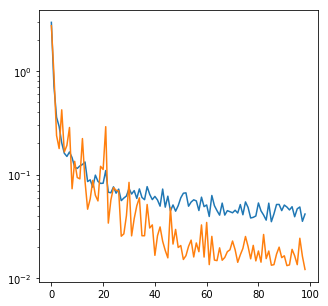

Train Epoch: 1 [0/976 (0%)]	Loss: 1.49181402
Train Epoch: 1 [256/976 (25%)]	Loss: 12.98848147
Train Epoch: 1 [512/976 (50%)]	Loss: 0.92779268
Train Epoch: 1 [768/976 (75%)]	Loss: 0.93384078

Test set: Average loss: 32.6986649610

Train Epoch: 2 [0/976 (0%)]	Loss: 0.69072395
Train Epoch: 2 [256/976 (25%)]	Loss: 0.66833306
Train Epoch: 2 [512/976 (50%)]	Loss: 0.68840458
Train Epoch: 2 [768/976 (75%)]	Loss: 0.71237165

Test set: Average loss: 3.2475477637

Train Epoch: 3 [0/976 (0%)]	Loss: 0.41512240
Train Epoch: 3 [256/976 (25%)]	Loss: 0.39807200
Train Epoch: 3 [512/976 (50%)]	Loss: 0.29642292
Train Epoch: 3 [768/976 (75%)]	Loss: 0.25588375

Test set: Average loss: 0.5932592608

Train Epoch: 4 [0/976 (0%)]	Loss: 0.24363712
Train Epoch: 4 [256/976 (25%)]	Loss: 0.22057923
Train Epoch: 4 [512/976 (50%)]	Loss: 0.20067618
Train Epoch: 4 [768/976 (75%)]	Loss: 0.22123831

Test set: Average loss: 0.2569579040

Train Epoch: 5 [0/976 (0%)]	Loss: 0.09199049
Train Epoch: 5 [256/976 (25%)]	Loss: 0.12

Train Epoch: 36 [768/976 (75%)]	Loss: 0.06012473

Test set: Average loss: 0.0368117355

Train Epoch: 37 [0/976 (0%)]	Loss: 0.04683570
Train Epoch: 37 [256/976 (25%)]	Loss: 0.05229099
Train Epoch: 37 [512/976 (50%)]	Loss: 0.05903648
Train Epoch: 37 [768/976 (75%)]	Loss: 0.05467594

Test set: Average loss: 0.0487906134

Train Epoch: 38 [0/976 (0%)]	Loss: 0.02374539
Train Epoch: 38 [256/976 (25%)]	Loss: 0.13541834
Train Epoch: 38 [512/976 (50%)]	Loss: 0.08170842
Train Epoch: 38 [768/976 (75%)]	Loss: 0.04653540

Test set: Average loss: 0.0387921381

Train Epoch: 39 [0/976 (0%)]	Loss: 0.03009788
Train Epoch: 39 [256/976 (25%)]	Loss: 0.04683439
Train Epoch: 39 [512/976 (50%)]	Loss: 0.03535762
Train Epoch: 39 [768/976 (75%)]	Loss: 0.07229877

Test set: Average loss: 0.0602969374

Train Epoch: 40 [0/976 (0%)]	Loss: 0.03761145
Train Epoch: 40 [256/976 (25%)]	Loss: 0.05607447
Train Epoch: 40 [512/976 (50%)]	Loss: 0.06762208
Train Epoch: 40 [768/976 (75%)]	Loss: 0.03974771

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.03396951
Train Epoch: 72 [256/976 (25%)]	Loss: 0.04241093
Train Epoch: 72 [512/976 (50%)]	Loss: 0.22944479
Train Epoch: 72 [768/976 (75%)]	Loss: 0.06045009

Test set: Average loss: 0.0379663483

Train Epoch: 73 [0/976 (0%)]	Loss: 0.06251451
Train Epoch: 73 [256/976 (25%)]	Loss: 0.03432705
Train Epoch: 73 [512/976 (50%)]	Loss: 0.03316315
Train Epoch: 73 [768/976 (75%)]	Loss: 0.04658350

Test set: Average loss: 0.0322430463

Train Epoch: 74 [0/976 (0%)]	Loss: 0.03600899
Train Epoch: 74 [256/976 (25%)]	Loss: 0.02167277
Train Epoch: 74 [512/976 (50%)]	Loss: 0.08621070
Train Epoch: 74 [768/976 (75%)]	Loss: 0.04005587

Test set: Average loss: 0.0220095836

Train Epoch: 75 [0/976 (0%)]	Loss: 0.03247401
Train Epoch: 75 [256/976 (25%)]	Loss: 0.05135206
Train Epoch: 75 [512/976 (50%)]	Loss: 0.03654430
Train Epoch: 75 [768/976 (75%)]	Loss: 0.09734136

Test set: Average loss: 0.0249370591

Train Epoch: 76 [0/976 (0%)]	Loss: 0.03695515
Train Epoch: 76 [256/976 (

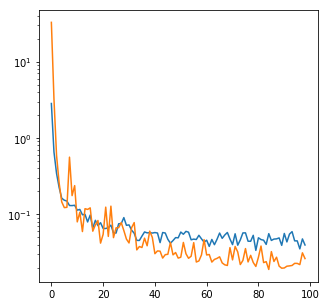

Train Epoch: 1 [0/976 (0%)]	Loss: 0.99832418
Train Epoch: 1 [256/976 (25%)]	Loss: 2.90782207
Train Epoch: 1 [512/976 (50%)]	Loss: 1.19069607
Train Epoch: 1 [768/976 (75%)]	Loss: 1.04065732

Test set: Average loss: 11.8578153076

Train Epoch: 2 [0/976 (0%)]	Loss: 0.72113053
Train Epoch: 2 [256/976 (25%)]	Loss: 0.83388508
Train Epoch: 2 [512/976 (50%)]	Loss: 0.67501651
Train Epoch: 2 [768/976 (75%)]	Loss: 0.38485517

Test set: Average loss: 1.0408660950

Train Epoch: 3 [0/976 (0%)]	Loss: 0.44105092
Train Epoch: 3 [256/976 (25%)]	Loss: 0.34505788
Train Epoch: 3 [512/976 (50%)]	Loss: 0.22230845
Train Epoch: 3 [768/976 (75%)]	Loss: 0.29315586

Test set: Average loss: 0.7678040396

Train Epoch: 4 [0/976 (0%)]	Loss: 0.26045654
Train Epoch: 4 [256/976 (25%)]	Loss: 0.27180400
Train Epoch: 4 [512/976 (50%)]	Loss: 0.30266450
Train Epoch: 4 [768/976 (75%)]	Loss: 0.14944392

Test set: Average loss: 0.4592476569

Train Epoch: 5 [0/976 (0%)]	Loss: 0.18842455
Train Epoch: 5 [256/976 (25%)]	Loss: 0.161

Train Epoch: 36 [768/976 (75%)]	Loss: 0.05286185

Test set: Average loss: 0.0650591609

Train Epoch: 37 [0/976 (0%)]	Loss: 0.06283360
Train Epoch: 37 [256/976 (25%)]	Loss: 0.07657672
Train Epoch: 37 [512/976 (50%)]	Loss: 0.07010911
Train Epoch: 37 [768/976 (75%)]	Loss: 0.05311167

Test set: Average loss: 0.0445644412

Train Epoch: 38 [0/976 (0%)]	Loss: 0.04320024
Train Epoch: 38 [256/976 (25%)]	Loss: 0.03765544
Train Epoch: 38 [512/976 (50%)]	Loss: 0.10522811
Train Epoch: 38 [768/976 (75%)]	Loss: 0.06846717

Test set: Average loss: 0.0262910908

Train Epoch: 39 [0/976 (0%)]	Loss: 0.09687810
Train Epoch: 39 [256/976 (25%)]	Loss: 0.03577820
Train Epoch: 39 [512/976 (50%)]	Loss: 0.04976758
Train Epoch: 39 [768/976 (75%)]	Loss: 0.04872648

Test set: Average loss: 0.0410317791

Train Epoch: 40 [0/976 (0%)]	Loss: 0.04754051
Train Epoch: 40 [256/976 (25%)]	Loss: 0.03815162
Train Epoch: 40 [512/976 (50%)]	Loss: 0.11383984
Train Epoch: 40 [768/976 (75%)]	Loss: 0.06090013

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.11434004
Train Epoch: 72 [256/976 (25%)]	Loss: 0.03682919
Train Epoch: 72 [512/976 (50%)]	Loss: 0.05902886
Train Epoch: 72 [768/976 (75%)]	Loss: 0.04490957

Test set: Average loss: 0.0149497252

Train Epoch: 73 [0/976 (0%)]	Loss: 0.04527823
Train Epoch: 73 [256/976 (25%)]	Loss: 0.02536927
Train Epoch: 73 [512/976 (50%)]	Loss: 0.03839369
Train Epoch: 73 [768/976 (75%)]	Loss: 0.04268275

Test set: Average loss: 0.0136312092

Train Epoch: 74 [0/976 (0%)]	Loss: 0.01609683
Train Epoch: 74 [256/976 (25%)]	Loss: 0.06078244
Train Epoch: 74 [512/976 (50%)]	Loss: 0.02697376
Train Epoch: 74 [768/976 (75%)]	Loss: 0.04237580

Test set: Average loss: 0.0209917099

Train Epoch: 75 [0/976 (0%)]	Loss: 0.02766029
Train Epoch: 75 [256/976 (25%)]	Loss: 0.03907260
Train Epoch: 75 [512/976 (50%)]	Loss: 0.06228968
Train Epoch: 75 [768/976 (75%)]	Loss: 0.02475545

Test set: Average loss: 0.0143997043

Train Epoch: 76 [0/976 (0%)]	Loss: 0.06963564
Train Epoch: 76 [256/976 (

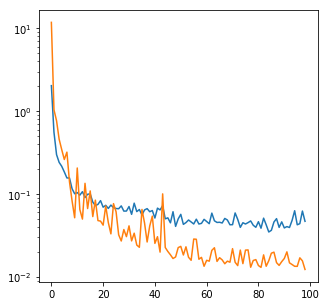

Train Epoch: 1 [0/976 (0%)]	Loss: 1.44502633
Train Epoch: 1 [256/976 (25%)]	Loss: 6.37874340
Train Epoch: 1 [512/976 (50%)]	Loss: 1.23531976
Train Epoch: 1 [768/976 (75%)]	Loss: 0.90287609

Test set: Average loss: 1.8921915574

Train Epoch: 2 [0/976 (0%)]	Loss: 1.02691347
Train Epoch: 2 [256/976 (25%)]	Loss: 0.94694126
Train Epoch: 2 [512/976 (50%)]	Loss: 0.97156788
Train Epoch: 2 [768/976 (75%)]	Loss: 0.81724684

Test set: Average loss: 1.4820049796

Train Epoch: 3 [0/976 (0%)]	Loss: 0.81020498
Train Epoch: 3 [256/976 (25%)]	Loss: 0.80058934
Train Epoch: 3 [512/976 (50%)]	Loss: 0.29197495
Train Epoch: 3 [768/976 (75%)]	Loss: 0.22768615

Test set: Average loss: 0.5355261961

Train Epoch: 4 [0/976 (0%)]	Loss: 0.17963242
Train Epoch: 4 [256/976 (25%)]	Loss: 0.31862272
Train Epoch: 4 [512/976 (50%)]	Loss: 0.22633106
Train Epoch: 4 [768/976 (75%)]	Loss: 0.18563715

Test set: Average loss: 0.2093089054

Train Epoch: 5 [0/976 (0%)]	Loss: 0.20558472
Train Epoch: 5 [256/976 (25%)]	Loss: 0.1427

Train Epoch: 36 [768/976 (75%)]	Loss: 0.03396292

Test set: Average loss: 0.0353498953

Train Epoch: 37 [0/976 (0%)]	Loss: 0.02934149
Train Epoch: 37 [256/976 (25%)]	Loss: 0.03781707
Train Epoch: 37 [512/976 (50%)]	Loss: 0.07280649
Train Epoch: 37 [768/976 (75%)]	Loss: 0.03319311

Test set: Average loss: 0.0202350871

Train Epoch: 38 [0/976 (0%)]	Loss: 0.08427475
Train Epoch: 38 [256/976 (25%)]	Loss: 0.05900578
Train Epoch: 38 [512/976 (50%)]	Loss: 0.04137951
Train Epoch: 38 [768/976 (75%)]	Loss: 0.06170925

Test set: Average loss: 0.0268526125

Train Epoch: 39 [0/976 (0%)]	Loss: 0.04464989
Train Epoch: 39 [256/976 (25%)]	Loss: 0.04758587
Train Epoch: 39 [512/976 (50%)]	Loss: 0.04772581
Train Epoch: 39 [768/976 (75%)]	Loss: 0.05252146

Test set: Average loss: 0.0517143133

Train Epoch: 40 [0/976 (0%)]	Loss: 0.12547971
Train Epoch: 40 [256/976 (25%)]	Loss: 0.12090489
Train Epoch: 40 [512/976 (50%)]	Loss: 0.05112712
Train Epoch: 40 [768/976 (75%)]	Loss: 0.04670742

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.04471588
Train Epoch: 72 [256/976 (25%)]	Loss: 0.02758020
Train Epoch: 72 [512/976 (50%)]	Loss: 0.03665821
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03745717

Test set: Average loss: 0.0193447647

Train Epoch: 73 [0/976 (0%)]	Loss: 0.02941742
Train Epoch: 73 [256/976 (25%)]	Loss: 0.03551968
Train Epoch: 73 [512/976 (50%)]	Loss: 0.02528718
Train Epoch: 73 [768/976 (75%)]	Loss: 0.02620111

Test set: Average loss: 0.0138105128

Train Epoch: 74 [0/976 (0%)]	Loss: 0.08377485
Train Epoch: 74 [256/976 (25%)]	Loss: 0.04986194
Train Epoch: 74 [512/976 (50%)]	Loss: 0.06926358
Train Epoch: 74 [768/976 (75%)]	Loss: 0.12947106

Test set: Average loss: 0.0180768147

Train Epoch: 75 [0/976 (0%)]	Loss: 0.06254122
Train Epoch: 75 [256/976 (25%)]	Loss: 0.05642682
Train Epoch: 75 [512/976 (50%)]	Loss: 0.02506752
Train Epoch: 75 [768/976 (75%)]	Loss: 0.03871837

Test set: Average loss: 0.0155794921

Train Epoch: 76 [0/976 (0%)]	Loss: 0.02307388
Train Epoch: 76 [256/976 (

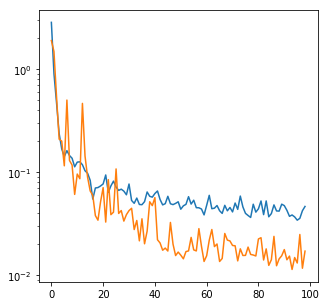

In [24]:
gr, pred = cv(**d)

Train Epoch: 1 [0/975 (0%)]	Loss: 1.24671812
Train Epoch: 1 [256/975 (25%)]	Loss: 6.18199726
Train Epoch: 1 [512/975 (50%)]	Loss: 0.92816279
Train Epoch: 1 [768/975 (75%)]	Loss: 1.14299069

Test set: Average loss: 294.1846793752

Train Epoch: 2 [0/975 (0%)]	Loss: 0.83729695
Train Epoch: 2 [256/975 (25%)]	Loss: 0.92121354
Train Epoch: 2 [512/975 (50%)]	Loss: 0.56475140
Train Epoch: 2 [768/975 (75%)]	Loss: 0.44099897

Test set: Average loss: 14.9142785919

Train Epoch: 3 [0/975 (0%)]	Loss: 0.31701751
Train Epoch: 3 [256/975 (25%)]	Loss: 0.43445590
Train Epoch: 3 [512/975 (50%)]	Loss: 0.23533045
Train Epoch: 3 [768/975 (75%)]	Loss: 0.36413992

Test set: Average loss: 0.5047823235

Train Epoch: 4 [0/975 (0%)]	Loss: 0.32410732
Train Epoch: 4 [256/975 (25%)]	Loss: 0.20203016
Train Epoch: 4 [512/975 (50%)]	Loss: 0.23989796
Train Epoch: 4 [768/975 (75%)]	Loss: 0.19002261

Test set: Average loss: 0.1780021533

Train Epoch: 5 [0/975 (0%)]	Loss: 0.14845608
Train Epoch: 5 [256/975 (25%)]	Loss: 0.2

Train Epoch: 36 [768/975 (75%)]	Loss: 0.04339982

Test set: Average loss: 0.0318866556

Train Epoch: 37 [0/975 (0%)]	Loss: 0.06247236
Train Epoch: 37 [256/975 (25%)]	Loss: 0.05930088
Train Epoch: 37 [512/975 (50%)]	Loss: 0.05355411
Train Epoch: 37 [768/975 (75%)]	Loss: 0.10365600

Test set: Average loss: 0.0495173863

Train Epoch: 38 [0/975 (0%)]	Loss: 0.07492929
Train Epoch: 38 [256/975 (25%)]	Loss: 0.11031413
Train Epoch: 38 [512/975 (50%)]	Loss: 0.07302006
Train Epoch: 38 [768/975 (75%)]	Loss: 0.04663851

Test set: Average loss: 0.0249700038

Train Epoch: 39 [0/975 (0%)]	Loss: 0.04934347
Train Epoch: 39 [256/975 (25%)]	Loss: 0.04725133
Train Epoch: 39 [512/975 (50%)]	Loss: 0.04257069
Train Epoch: 39 [768/975 (75%)]	Loss: 0.03361912

Test set: Average loss: 0.0221573907

Train Epoch: 40 [0/975 (0%)]	Loss: 0.05867284
Train Epoch: 40 [256/975 (25%)]	Loss: 0.04551002
Train Epoch: 40 [512/975 (50%)]	Loss: 0.08175408
Train Epoch: 40 [768/975 (75%)]	Loss: 0.04112875

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.03033378
Train Epoch: 72 [256/975 (25%)]	Loss: 0.02162339
Train Epoch: 72 [512/975 (50%)]	Loss: 0.02464745
Train Epoch: 72 [768/975 (75%)]	Loss: 0.06171135

Test set: Average loss: 0.0182356932

Train Epoch: 73 [0/975 (0%)]	Loss: 0.02129257
Train Epoch: 73 [256/975 (25%)]	Loss: 0.11603157
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02943660
Train Epoch: 73 [768/975 (75%)]	Loss: 0.05192087

Test set: Average loss: 0.0211299002

Train Epoch: 74 [0/975 (0%)]	Loss: 0.03699882
Train Epoch: 74 [256/975 (25%)]	Loss: 0.05580438
Train Epoch: 74 [512/975 (50%)]	Loss: 0.08761059
Train Epoch: 74 [768/975 (75%)]	Loss: 0.06548338

Test set: Average loss: 0.0211015671

Train Epoch: 75 [0/975 (0%)]	Loss: 0.04692283
Train Epoch: 75 [256/975 (25%)]	Loss: 0.01913298
Train Epoch: 75 [512/975 (50%)]	Loss: 0.03670121
Train Epoch: 75 [768/975 (75%)]	Loss: 0.09051770

Test set: Average loss: 0.0154465318

Train Epoch: 76 [0/975 (0%)]	Loss: 0.06930070
Train Epoch: 76 [256/975 (

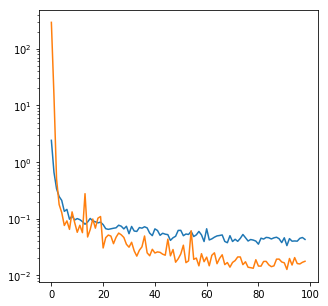

Train Epoch: 1 [0/975 (0%)]	Loss: 1.51364882
Train Epoch: 1 [256/975 (25%)]	Loss: 7.92386117
Train Epoch: 1 [512/975 (50%)]	Loss: 1.73328274
Train Epoch: 1 [768/975 (75%)]	Loss: 1.07900831

Test set: Average loss: 10.8084163192

Train Epoch: 2 [0/975 (0%)]	Loss: 0.78017373
Train Epoch: 2 [256/975 (25%)]	Loss: 1.14956062
Train Epoch: 2 [512/975 (50%)]	Loss: 0.78622025
Train Epoch: 2 [768/975 (75%)]	Loss: 0.64229050

Test set: Average loss: 0.8483348961

Train Epoch: 3 [0/975 (0%)]	Loss: 0.56121705
Train Epoch: 3 [256/975 (25%)]	Loss: 0.60173124
Train Epoch: 3 [512/975 (50%)]	Loss: 0.39736746
Train Epoch: 3 [768/975 (75%)]	Loss: 0.33558039

Test set: Average loss: 0.4990604844

Train Epoch: 4 [0/975 (0%)]	Loss: 0.32452355
Train Epoch: 4 [256/975 (25%)]	Loss: 0.32377034
Train Epoch: 4 [512/975 (50%)]	Loss: 0.30350126
Train Epoch: 4 [768/975 (75%)]	Loss: 0.22842414

Test set: Average loss: 0.2011984450

Train Epoch: 5 [0/975 (0%)]	Loss: 0.48585260
Train Epoch: 5 [256/975 (25%)]	Loss: 0.266

Train Epoch: 36 [768/975 (75%)]	Loss: 0.08472220

Test set: Average loss: 0.0520942172

Train Epoch: 37 [0/975 (0%)]	Loss: 0.04993356
Train Epoch: 37 [256/975 (25%)]	Loss: 0.04187012
Train Epoch: 37 [512/975 (50%)]	Loss: 0.02741003
Train Epoch: 37 [768/975 (75%)]	Loss: 0.04069983

Test set: Average loss: 0.0392528913

Train Epoch: 38 [0/975 (0%)]	Loss: 0.05235173
Train Epoch: 38 [256/975 (25%)]	Loss: 0.04892114
Train Epoch: 38 [512/975 (50%)]	Loss: 0.03846007
Train Epoch: 38 [768/975 (75%)]	Loss: 0.04525597

Test set: Average loss: 0.0384100682

Train Epoch: 39 [0/975 (0%)]	Loss: 0.03593491
Train Epoch: 39 [256/975 (25%)]	Loss: 0.05288760
Train Epoch: 39 [512/975 (50%)]	Loss: 0.05242971
Train Epoch: 39 [768/975 (75%)]	Loss: 0.07715399

Test set: Average loss: 0.0308339115

Train Epoch: 40 [0/975 (0%)]	Loss: 0.06832187
Train Epoch: 40 [256/975 (25%)]	Loss: 0.05479613
Train Epoch: 40 [512/975 (50%)]	Loss: 0.03571353
Train Epoch: 40 [768/975 (75%)]	Loss: 0.05585292

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.04099555
Train Epoch: 72 [256/975 (25%)]	Loss: 0.05697174
Train Epoch: 72 [512/975 (50%)]	Loss: 0.02834800
Train Epoch: 72 [768/975 (75%)]	Loss: 0.07404169

Test set: Average loss: 0.0136850622

Train Epoch: 73 [0/975 (0%)]	Loss: 0.02506204
Train Epoch: 73 [256/975 (25%)]	Loss: 0.02570789
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02602567
Train Epoch: 73 [768/975 (75%)]	Loss: 0.04529304

Test set: Average loss: 0.0161028995

Train Epoch: 74 [0/975 (0%)]	Loss: 0.02688101
Train Epoch: 74 [256/975 (25%)]	Loss: 0.03963107
Train Epoch: 74 [512/975 (50%)]	Loss: 0.08113077
Train Epoch: 74 [768/975 (75%)]	Loss: 0.04723687

Test set: Average loss: 0.0186774386

Train Epoch: 75 [0/975 (0%)]	Loss: 0.03506279
Train Epoch: 75 [256/975 (25%)]	Loss: 0.04441460
Train Epoch: 75 [512/975 (50%)]	Loss: 0.05514402
Train Epoch: 75 [768/975 (75%)]	Loss: 0.03095894

Test set: Average loss: 0.0153653817

Train Epoch: 76 [0/975 (0%)]	Loss: 0.03809304
Train Epoch: 76 [256/975 (

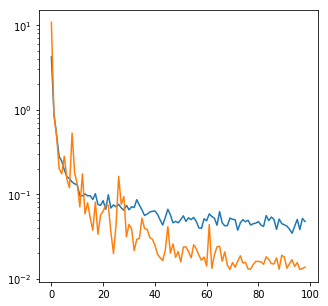

Train Epoch: 1 [0/975 (0%)]	Loss: 1.32714155
Train Epoch: 1 [256/975 (25%)]	Loss: 3.67755277
Train Epoch: 1 [512/975 (50%)]	Loss: 1.51239547
Train Epoch: 1 [768/975 (75%)]	Loss: 1.25776860

Test set: Average loss: 2313.6559324569

Train Epoch: 2 [0/975 (0%)]	Loss: 0.96771841
Train Epoch: 2 [256/975 (25%)]	Loss: 0.77770562
Train Epoch: 2 [512/975 (50%)]	Loss: 0.72048098
Train Epoch: 2 [768/975 (75%)]	Loss: 0.68445020

Test set: Average loss: 4.6461186500

Train Epoch: 3 [0/975 (0%)]	Loss: 0.51824871
Train Epoch: 3 [256/975 (25%)]	Loss: 0.48001526
Train Epoch: 3 [512/975 (50%)]	Loss: 0.24159678
Train Epoch: 3 [768/975 (75%)]	Loss: 0.30275550

Test set: Average loss: 1.0802269557

Train Epoch: 4 [0/975 (0%)]	Loss: 0.30055680
Train Epoch: 4 [256/975 (25%)]	Loss: 0.27623150
Train Epoch: 4 [512/975 (50%)]	Loss: 0.37684746
Train Epoch: 4 [768/975 (75%)]	Loss: 0.32450823

Test set: Average loss: 0.3639758241

Train Epoch: 5 [0/975 (0%)]	Loss: 0.18750115
Train Epoch: 5 [256/975 (25%)]	Loss: 0.2

Train Epoch: 36 [768/975 (75%)]	Loss: 0.03174877

Test set: Average loss: 0.0358929596

Train Epoch: 37 [0/975 (0%)]	Loss: 0.03819558
Train Epoch: 37 [256/975 (25%)]	Loss: 0.05749409
Train Epoch: 37 [512/975 (50%)]	Loss: 0.05689978
Train Epoch: 37 [768/975 (75%)]	Loss: 0.04930714

Test set: Average loss: 0.1281323653

Train Epoch: 38 [0/975 (0%)]	Loss: 0.05578660
Train Epoch: 38 [256/975 (25%)]	Loss: 0.03922793
Train Epoch: 38 [512/975 (50%)]	Loss: 0.04812643
Train Epoch: 38 [768/975 (75%)]	Loss: 0.06722128

Test set: Average loss: 0.0282703853

Train Epoch: 39 [0/975 (0%)]	Loss: 0.03780853
Train Epoch: 39 [256/975 (25%)]	Loss: 0.06591513
Train Epoch: 39 [512/975 (50%)]	Loss: 0.03600564
Train Epoch: 39 [768/975 (75%)]	Loss: 0.05415605

Test set: Average loss: 0.0389619897

Train Epoch: 40 [0/975 (0%)]	Loss: 0.03711928
Train Epoch: 40 [256/975 (25%)]	Loss: 0.03993381
Train Epoch: 40 [512/975 (50%)]	Loss: 0.10892515
Train Epoch: 40 [768/975 (75%)]	Loss: 0.04233722

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.03420858
Train Epoch: 72 [256/975 (25%)]	Loss: 0.07743003
Train Epoch: 72 [512/975 (50%)]	Loss: 0.06175248
Train Epoch: 72 [768/975 (75%)]	Loss: 0.02806292

Test set: Average loss: 0.0235632576

Train Epoch: 73 [0/975 (0%)]	Loss: 0.03432088
Train Epoch: 73 [256/975 (25%)]	Loss: 0.07425450
Train Epoch: 73 [512/975 (50%)]	Loss: 0.06762170
Train Epoch: 73 [768/975 (75%)]	Loss: 0.04832912

Test set: Average loss: 0.0248905451

Train Epoch: 74 [0/975 (0%)]	Loss: 0.08262188
Train Epoch: 74 [256/975 (25%)]	Loss: 0.11273202
Train Epoch: 74 [512/975 (50%)]	Loss: 0.02856010
Train Epoch: 74 [768/975 (75%)]	Loss: 0.04008656

Test set: Average loss: 0.0249031601

Train Epoch: 75 [0/975 (0%)]	Loss: 0.10329141
Train Epoch: 75 [256/975 (25%)]	Loss: 0.04060461
Train Epoch: 75 [512/975 (50%)]	Loss: 0.04363865
Train Epoch: 75 [768/975 (75%)]	Loss: 0.03487335

Test set: Average loss: 0.0216983665

Train Epoch: 76 [0/975 (0%)]	Loss: 0.03642098
Train Epoch: 76 [256/975 (

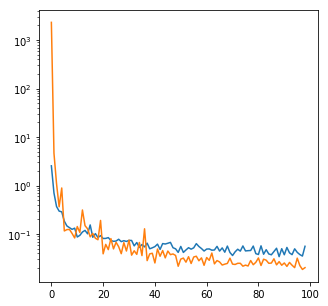

Train Epoch: 1 [0/975 (0%)]	Loss: 2.54502791
Train Epoch: 1 [256/975 (25%)]	Loss: 11.79127051
Train Epoch: 1 [512/975 (50%)]	Loss: 1.18669483
Train Epoch: 1 [768/975 (75%)]	Loss: 0.80348607

Test set: Average loss: 728.2353670845

Train Epoch: 2 [0/975 (0%)]	Loss: 1.32977153
Train Epoch: 2 [256/975 (25%)]	Loss: 0.95837264
Train Epoch: 2 [512/975 (50%)]	Loss: 0.87023508
Train Epoch: 2 [768/975 (75%)]	Loss: 1.08723719

Test set: Average loss: 1.3382216860

Train Epoch: 3 [0/975 (0%)]	Loss: 1.20622118
Train Epoch: 3 [256/975 (25%)]	Loss: 0.73031155
Train Epoch: 3 [512/975 (50%)]	Loss: 0.78200078
Train Epoch: 3 [768/975 (75%)]	Loss: 0.90451043

Test set: Average loss: 1.7414327457

Train Epoch: 4 [0/975 (0%)]	Loss: 0.86399976
Train Epoch: 4 [256/975 (25%)]	Loss: 0.86739166
Train Epoch: 4 [512/975 (50%)]	Loss: 0.52966719
Train Epoch: 4 [768/975 (75%)]	Loss: 0.42243042

Test set: Average loss: 0.4127884461

Train Epoch: 5 [0/975 (0%)]	Loss: 0.30062281
Train Epoch: 5 [256/975 (25%)]	Loss: 0.3

Train Epoch: 36 [768/975 (75%)]	Loss: 0.05773637

Test set: Average loss: 0.0233335184

Train Epoch: 37 [0/975 (0%)]	Loss: 0.02732072
Train Epoch: 37 [256/975 (25%)]	Loss: 0.04758129
Train Epoch: 37 [512/975 (50%)]	Loss: 0.07247851
Train Epoch: 37 [768/975 (75%)]	Loss: 0.10432892

Test set: Average loss: 0.0243363583

Train Epoch: 38 [0/975 (0%)]	Loss: 0.04602254
Train Epoch: 38 [256/975 (25%)]	Loss: 0.02626418
Train Epoch: 38 [512/975 (50%)]	Loss: 0.04456746
Train Epoch: 38 [768/975 (75%)]	Loss: 0.09662430

Test set: Average loss: 0.0507141842

Train Epoch: 39 [0/975 (0%)]	Loss: 0.14505005
Train Epoch: 39 [256/975 (25%)]	Loss: 0.14045941
Train Epoch: 39 [512/975 (50%)]	Loss: 0.04546015
Train Epoch: 39 [768/975 (75%)]	Loss: 0.05558857

Test set: Average loss: 0.0244135893

Train Epoch: 40 [0/975 (0%)]	Loss: 0.05761356
Train Epoch: 40 [256/975 (25%)]	Loss: 0.03796470
Train Epoch: 40 [512/975 (50%)]	Loss: 0.06290551
Train Epoch: 40 [768/975 (75%)]	Loss: 0.10368457

Test set: Average loss

Train Epoch: 72 [0/975 (0%)]	Loss: 0.02430893
Train Epoch: 72 [256/975 (25%)]	Loss: 0.02589291
Train Epoch: 72 [512/975 (50%)]	Loss: 0.03447340
Train Epoch: 72 [768/975 (75%)]	Loss: 0.06513978

Test set: Average loss: 0.0175740849

Train Epoch: 73 [0/975 (0%)]	Loss: 0.07574443
Train Epoch: 73 [256/975 (25%)]	Loss: 0.03276648
Train Epoch: 73 [512/975 (50%)]	Loss: 0.02157982
Train Epoch: 73 [768/975 (75%)]	Loss: 0.03786558

Test set: Average loss: 0.0150380882

Train Epoch: 74 [0/975 (0%)]	Loss: 0.02651293
Train Epoch: 74 [256/975 (25%)]	Loss: 0.03889864
Train Epoch: 74 [512/975 (50%)]	Loss: 0.07164042
Train Epoch: 74 [768/975 (75%)]	Loss: 0.03366586

Test set: Average loss: 0.0167627367

Train Epoch: 75 [0/975 (0%)]	Loss: 0.02391280
Train Epoch: 75 [256/975 (25%)]	Loss: 0.06011397
Train Epoch: 75 [512/975 (50%)]	Loss: 0.02659457
Train Epoch: 75 [768/975 (75%)]	Loss: 0.08510862

Test set: Average loss: 0.0221910651

Train Epoch: 76 [0/975 (0%)]	Loss: 0.03259008
Train Epoch: 76 [256/975 (

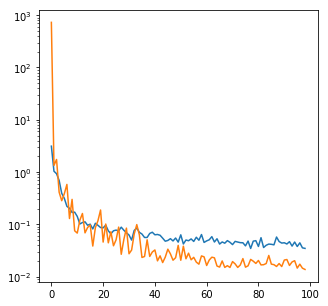

Train Epoch: 1 [0/976 (0%)]	Loss: 1.22483190
Train Epoch: 1 [256/976 (25%)]	Loss: 6.79384021
Train Epoch: 1 [512/976 (50%)]	Loss: 1.05907670
Train Epoch: 1 [768/976 (75%)]	Loss: 1.09460589

Test set: Average loss: 363.2516036766

Train Epoch: 2 [0/976 (0%)]	Loss: 1.22863491
Train Epoch: 2 [256/976 (25%)]	Loss: 0.52684864
Train Epoch: 2 [512/976 (50%)]	Loss: 0.77306081
Train Epoch: 2 [768/976 (75%)]	Loss: 0.52868283

Test set: Average loss: 2.3712820004

Train Epoch: 3 [0/976 (0%)]	Loss: 0.53319322
Train Epoch: 3 [256/976 (25%)]	Loss: 0.50791603
Train Epoch: 3 [512/976 (50%)]	Loss: 0.41679483
Train Epoch: 3 [768/976 (75%)]	Loss: 0.58347743

Test set: Average loss: 0.3541496715

Train Epoch: 4 [0/976 (0%)]	Loss: 0.36996180
Train Epoch: 4 [256/976 (25%)]	Loss: 0.43719211
Train Epoch: 4 [512/976 (50%)]	Loss: 0.25714448
Train Epoch: 4 [768/976 (75%)]	Loss: 0.30732198

Test set: Average loss: 0.7132465646

Train Epoch: 5 [0/976 (0%)]	Loss: 0.42948815
Train Epoch: 5 [256/976 (25%)]	Loss: 0.30

Train Epoch: 36 [768/976 (75%)]	Loss: 0.11580136

Test set: Average loss: 0.0276077343

Train Epoch: 37 [0/976 (0%)]	Loss: 0.05653690
Train Epoch: 37 [256/976 (25%)]	Loss: 0.04545481
Train Epoch: 37 [512/976 (50%)]	Loss: 0.04403910
Train Epoch: 37 [768/976 (75%)]	Loss: 0.05712275

Test set: Average loss: 0.0703918952

Train Epoch: 38 [0/976 (0%)]	Loss: 0.08236091
Train Epoch: 38 [256/976 (25%)]	Loss: 0.05406942
Train Epoch: 38 [512/976 (50%)]	Loss: 0.02129984
Train Epoch: 38 [768/976 (75%)]	Loss: 0.06160180

Test set: Average loss: 0.0518255062

Train Epoch: 39 [0/976 (0%)]	Loss: 0.09663396
Train Epoch: 39 [256/976 (25%)]	Loss: 0.04567534
Train Epoch: 39 [512/976 (50%)]	Loss: 0.15036098
Train Epoch: 39 [768/976 (75%)]	Loss: 0.06028159

Test set: Average loss: 0.0280884418

Train Epoch: 40 [0/976 (0%)]	Loss: 0.04794265
Train Epoch: 40 [256/976 (25%)]	Loss: 0.04629539
Train Epoch: 40 [512/976 (50%)]	Loss: 0.02357454
Train Epoch: 40 [768/976 (75%)]	Loss: 0.11714483

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.05859920
Train Epoch: 72 [256/976 (25%)]	Loss: 0.04369326
Train Epoch: 72 [512/976 (50%)]	Loss: 0.05586227
Train Epoch: 72 [768/976 (75%)]	Loss: 0.02535763

Test set: Average loss: 0.0127763331

Train Epoch: 73 [0/976 (0%)]	Loss: 0.11689325
Train Epoch: 73 [256/976 (25%)]	Loss: 0.04340574
Train Epoch: 73 [512/976 (50%)]	Loss: 0.05624802
Train Epoch: 73 [768/976 (75%)]	Loss: 0.02947349

Test set: Average loss: 0.0159637785

Train Epoch: 74 [0/976 (0%)]	Loss: 0.03553076
Train Epoch: 74 [256/976 (25%)]	Loss: 0.02471487
Train Epoch: 74 [512/976 (50%)]	Loss: 0.03039474
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03571310

Test set: Average loss: 0.0220753236

Train Epoch: 75 [0/976 (0%)]	Loss: 0.05790239
Train Epoch: 75 [256/976 (25%)]	Loss: 0.07824123
Train Epoch: 75 [512/976 (50%)]	Loss: 0.04806342
Train Epoch: 75 [768/976 (75%)]	Loss: 0.09047566

Test set: Average loss: 0.0192087668

Train Epoch: 76 [0/976 (0%)]	Loss: 0.01845970
Train Epoch: 76 [256/976 (

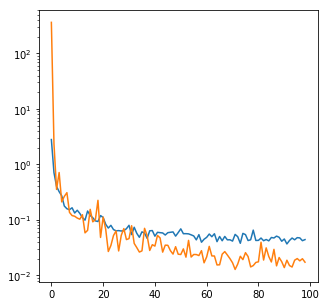

Train Epoch: 1 [0/976 (0%)]	Loss: 1.74352695
Train Epoch: 1 [256/976 (25%)]	Loss: 1.97097922
Train Epoch: 1 [512/976 (50%)]	Loss: 1.08749881
Train Epoch: 1 [768/976 (75%)]	Loss: 1.13719534

Test set: Average loss: 9.2283339828

Train Epoch: 2 [0/976 (0%)]	Loss: 0.94740446
Train Epoch: 2 [256/976 (25%)]	Loss: 0.94043388
Train Epoch: 2 [512/976 (50%)]	Loss: 0.61082707
Train Epoch: 2 [768/976 (75%)]	Loss: 0.79226756

Test set: Average loss: 1.2958143576

Train Epoch: 3 [0/976 (0%)]	Loss: 0.64072464
Train Epoch: 3 [256/976 (25%)]	Loss: 0.59094842
Train Epoch: 3 [512/976 (50%)]	Loss: 0.59552668
Train Epoch: 3 [768/976 (75%)]	Loss: 0.32550931

Test set: Average loss: 2.8305457148

Train Epoch: 4 [0/976 (0%)]	Loss: 0.27057637
Train Epoch: 4 [256/976 (25%)]	Loss: 0.44919838
Train Epoch: 4 [512/976 (50%)]	Loss: 0.44676989
Train Epoch: 4 [768/976 (75%)]	Loss: 0.23677240

Test set: Average loss: 0.2907383352

Train Epoch: 5 [0/976 (0%)]	Loss: 0.32996965
Train Epoch: 5 [256/976 (25%)]	Loss: 0.3145

Train Epoch: 36 [768/976 (75%)]	Loss: 0.04955195

Test set: Average loss: 0.0495031265

Train Epoch: 37 [0/976 (0%)]	Loss: 0.05992271
Train Epoch: 37 [256/976 (25%)]	Loss: 0.03631220
Train Epoch: 37 [512/976 (50%)]	Loss: 0.05811546
Train Epoch: 37 [768/976 (75%)]	Loss: 0.10244989

Test set: Average loss: 0.0393544841

Train Epoch: 38 [0/976 (0%)]	Loss: 0.12427971
Train Epoch: 38 [256/976 (25%)]	Loss: 0.05779345
Train Epoch: 38 [512/976 (50%)]	Loss: 0.04889190
Train Epoch: 38 [768/976 (75%)]	Loss: 0.05517294

Test set: Average loss: 0.0407999459

Train Epoch: 39 [0/976 (0%)]	Loss: 0.09210018
Train Epoch: 39 [256/976 (25%)]	Loss: 0.06046422
Train Epoch: 39 [512/976 (50%)]	Loss: 0.09895475
Train Epoch: 39 [768/976 (75%)]	Loss: 0.07152730

Test set: Average loss: 0.0354430269

Train Epoch: 40 [0/976 (0%)]	Loss: 0.03817575
Train Epoch: 40 [256/976 (25%)]	Loss: 0.04346022
Train Epoch: 40 [512/976 (50%)]	Loss: 0.08805284
Train Epoch: 40 [768/976 (75%)]	Loss: 0.04362699

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.02861076
Train Epoch: 72 [256/976 (25%)]	Loss: 0.09178590
Train Epoch: 72 [512/976 (50%)]	Loss: 0.03315392
Train Epoch: 72 [768/976 (75%)]	Loss: 0.04605734

Test set: Average loss: 0.0240543468

Train Epoch: 73 [0/976 (0%)]	Loss: 0.07723040
Train Epoch: 73 [256/976 (25%)]	Loss: 0.05957553
Train Epoch: 73 [512/976 (50%)]	Loss: 0.03098637
Train Epoch: 73 [768/976 (75%)]	Loss: 0.03809646

Test set: Average loss: 0.0269037050

Train Epoch: 74 [0/976 (0%)]	Loss: 0.04100566
Train Epoch: 74 [256/976 (25%)]	Loss: 0.04860457
Train Epoch: 74 [512/976 (50%)]	Loss: 0.02386923
Train Epoch: 74 [768/976 (75%)]	Loss: 0.04323107

Test set: Average loss: 0.0215824773

Train Epoch: 75 [0/976 (0%)]	Loss: 0.06993159
Train Epoch: 75 [256/976 (25%)]	Loss: 0.06348350
Train Epoch: 75 [512/976 (50%)]	Loss: 0.04566615
Train Epoch: 75 [768/976 (75%)]	Loss: 0.03060282

Test set: Average loss: 0.0286050697

Train Epoch: 76 [0/976 (0%)]	Loss: 0.02317275
Train Epoch: 76 [256/976 (

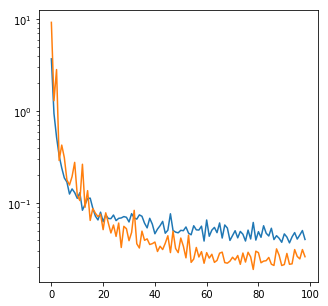

Train Epoch: 1 [0/976 (0%)]	Loss: 1.78654414
Train Epoch: 1 [256/976 (25%)]	Loss: 13.84512120
Train Epoch: 1 [512/976 (50%)]	Loss: 1.44272731
Train Epoch: 1 [768/976 (75%)]	Loss: 0.95282687

Test set: Average loss: 176.2024650213

Train Epoch: 2 [0/976 (0%)]	Loss: 0.71892733
Train Epoch: 2 [256/976 (25%)]	Loss: 1.06805800
Train Epoch: 2 [512/976 (50%)]	Loss: 0.78086389
Train Epoch: 2 [768/976 (75%)]	Loss: 0.78489694

Test set: Average loss: 3.3501788950

Train Epoch: 3 [0/976 (0%)]	Loss: 0.70074316
Train Epoch: 3 [256/976 (25%)]	Loss: 0.42334370
Train Epoch: 3 [512/976 (50%)]	Loss: 0.66480683
Train Epoch: 3 [768/976 (75%)]	Loss: 0.35866056

Test set: Average loss: 0.3540756028

Train Epoch: 4 [0/976 (0%)]	Loss: 0.37093678
Train Epoch: 4 [256/976 (25%)]	Loss: 0.41472305
Train Epoch: 4 [512/976 (50%)]	Loss: 0.27924974
Train Epoch: 4 [768/976 (75%)]	Loss: 0.23234820

Test set: Average loss: 0.2475668256

Train Epoch: 5 [0/976 (0%)]	Loss: 0.15180343
Train Epoch: 5 [256/976 (25%)]	Loss: 0.1

Train Epoch: 36 [768/976 (75%)]	Loss: 0.10969927

Test set: Average loss: 0.0435655863

Train Epoch: 37 [0/976 (0%)]	Loss: 0.07714716
Train Epoch: 37 [256/976 (25%)]	Loss: 0.08113762
Train Epoch: 37 [512/976 (50%)]	Loss: 0.05132672
Train Epoch: 37 [768/976 (75%)]	Loss: 0.07435849

Test set: Average loss: 0.0234576450

Train Epoch: 38 [0/976 (0%)]	Loss: 0.02734602
Train Epoch: 38 [256/976 (25%)]	Loss: 0.06202503
Train Epoch: 38 [512/976 (50%)]	Loss: 0.07181007
Train Epoch: 38 [768/976 (75%)]	Loss: 0.04933964

Test set: Average loss: 0.0296883482

Train Epoch: 39 [0/976 (0%)]	Loss: 0.03537744
Train Epoch: 39 [256/976 (25%)]	Loss: 0.04453915
Train Epoch: 39 [512/976 (50%)]	Loss: 0.05352165
Train Epoch: 39 [768/976 (75%)]	Loss: 0.03613234

Test set: Average loss: 0.0226395266

Train Epoch: 40 [0/976 (0%)]	Loss: 0.04306279
Train Epoch: 40 [256/976 (25%)]	Loss: 0.05355209
Train Epoch: 40 [512/976 (50%)]	Loss: 0.06421490
Train Epoch: 40 [768/976 (75%)]	Loss: 0.03780659

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.04551032
Train Epoch: 72 [256/976 (25%)]	Loss: 0.02013613
Train Epoch: 72 [512/976 (50%)]	Loss: 0.06353182
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03757171

Test set: Average loss: 0.0185376694

Train Epoch: 73 [0/976 (0%)]	Loss: 0.02678391
Train Epoch: 73 [256/976 (25%)]	Loss: 0.07152227
Train Epoch: 73 [512/976 (50%)]	Loss: 0.04966369
Train Epoch: 73 [768/976 (75%)]	Loss: 0.02095525

Test set: Average loss: 0.0166333523

Train Epoch: 74 [0/976 (0%)]	Loss: 0.04442110
Train Epoch: 74 [256/976 (25%)]	Loss: 0.03123568
Train Epoch: 74 [512/976 (50%)]	Loss: 0.05548934
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03166904

Test set: Average loss: 0.0132199495

Train Epoch: 75 [0/976 (0%)]	Loss: 0.02883236
Train Epoch: 75 [256/976 (25%)]	Loss: 0.05041459
Train Epoch: 75 [512/976 (50%)]	Loss: 0.02569640
Train Epoch: 75 [768/976 (75%)]	Loss: 0.10096209

Test set: Average loss: 0.0133768590

Train Epoch: 76 [0/976 (0%)]	Loss: 0.03484574
Train Epoch: 76 [256/976 (

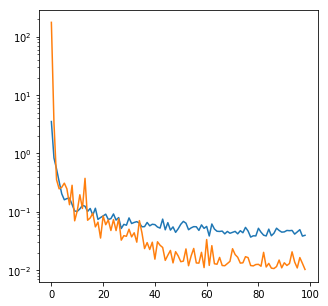

Train Epoch: 1 [0/976 (0%)]	Loss: 1.36937807
Train Epoch: 1 [256/976 (25%)]	Loss: 4.89229899
Train Epoch: 1 [512/976 (50%)]	Loss: 0.85853518
Train Epoch: 1 [768/976 (75%)]	Loss: 1.19447340

Test set: Average loss: 16.1056736022

Train Epoch: 2 [0/976 (0%)]	Loss: 0.72591463
Train Epoch: 2 [256/976 (25%)]	Loss: 0.87583955
Train Epoch: 2 [512/976 (50%)]	Loss: 0.98256874
Train Epoch: 2 [768/976 (75%)]	Loss: 0.66807717

Test set: Average loss: 0.7253409599

Train Epoch: 3 [0/976 (0%)]	Loss: 0.55861859
Train Epoch: 3 [256/976 (25%)]	Loss: 0.42493042
Train Epoch: 3 [512/976 (50%)]	Loss: 0.29551664
Train Epoch: 3 [768/976 (75%)]	Loss: 0.36826698

Test set: Average loss: 0.8896837233

Train Epoch: 4 [0/976 (0%)]	Loss: 0.27908298
Train Epoch: 4 [256/976 (25%)]	Loss: 0.23038370
Train Epoch: 4 [512/976 (50%)]	Loss: 0.24657589
Train Epoch: 4 [768/976 (75%)]	Loss: 0.20748968

Test set: Average loss: 0.2304106091

Train Epoch: 5 [0/976 (0%)]	Loss: 0.13157043
Train Epoch: 5 [256/976 (25%)]	Loss: 0.086

Train Epoch: 36 [768/976 (75%)]	Loss: 0.04814111

Test set: Average loss: 0.0537070548

Train Epoch: 37 [0/976 (0%)]	Loss: 0.04064803
Train Epoch: 37 [256/976 (25%)]	Loss: 0.04940586
Train Epoch: 37 [512/976 (50%)]	Loss: 0.03390331
Train Epoch: 37 [768/976 (75%)]	Loss: 0.03930033

Test set: Average loss: 0.0537756296

Train Epoch: 38 [0/976 (0%)]	Loss: 0.02598779
Train Epoch: 38 [256/976 (25%)]	Loss: 0.12052543
Train Epoch: 38 [512/976 (50%)]	Loss: 0.06077795
Train Epoch: 38 [768/976 (75%)]	Loss: 0.04763822

Test set: Average loss: 0.0551423086

Train Epoch: 39 [0/976 (0%)]	Loss: 0.03905920
Train Epoch: 39 [256/976 (25%)]	Loss: 0.03758086
Train Epoch: 39 [512/976 (50%)]	Loss: 0.02538254
Train Epoch: 39 [768/976 (75%)]	Loss: 0.07053964

Test set: Average loss: 0.0481853601

Train Epoch: 40 [0/976 (0%)]	Loss: 0.03694144
Train Epoch: 40 [256/976 (25%)]	Loss: 0.05511661
Train Epoch: 40 [512/976 (50%)]	Loss: 0.07042275
Train Epoch: 40 [768/976 (75%)]	Loss: 0.04627941

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.02728293
Train Epoch: 72 [256/976 (25%)]	Loss: 0.04283643
Train Epoch: 72 [512/976 (50%)]	Loss: 0.21115966
Train Epoch: 72 [768/976 (75%)]	Loss: 0.05943802

Test set: Average loss: 0.0309477720

Train Epoch: 73 [0/976 (0%)]	Loss: 0.05793312
Train Epoch: 73 [256/976 (25%)]	Loss: 0.03630580
Train Epoch: 73 [512/976 (50%)]	Loss: 0.03239302
Train Epoch: 73 [768/976 (75%)]	Loss: 0.04601557

Test set: Average loss: 0.0329597619

Train Epoch: 74 [0/976 (0%)]	Loss: 0.04771545
Train Epoch: 74 [256/976 (25%)]	Loss: 0.01847306
Train Epoch: 74 [512/976 (50%)]	Loss: 0.04943091
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03989495

Test set: Average loss: 0.0226782722

Train Epoch: 75 [0/976 (0%)]	Loss: 0.02567952
Train Epoch: 75 [256/976 (25%)]	Loss: 0.05387794
Train Epoch: 75 [512/976 (50%)]	Loss: 0.02014782
Train Epoch: 75 [768/976 (75%)]	Loss: 0.08313044

Test set: Average loss: 0.0291682959

Train Epoch: 76 [0/976 (0%)]	Loss: 0.03010413
Train Epoch: 76 [256/976 (

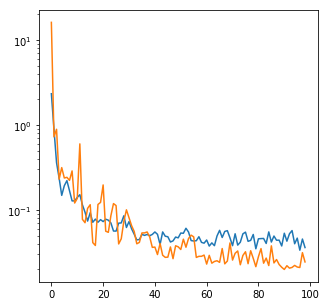

Train Epoch: 1 [0/976 (0%)]	Loss: 1.11017692
Train Epoch: 1 [256/976 (25%)]	Loss: 3.11637879
Train Epoch: 1 [512/976 (50%)]	Loss: 1.09182685
Train Epoch: 1 [768/976 (75%)]	Loss: 0.96164089

Test set: Average loss: 12.3034564157

Train Epoch: 2 [0/976 (0%)]	Loss: 0.53696657
Train Epoch: 2 [256/976 (25%)]	Loss: 0.48697466
Train Epoch: 2 [512/976 (50%)]	Loss: 0.33977016
Train Epoch: 2 [768/976 (75%)]	Loss: 0.26043313

Test set: Average loss: 1.1727529864

Train Epoch: 3 [0/976 (0%)]	Loss: 0.30108653
Train Epoch: 3 [256/976 (25%)]	Loss: 0.25423500
Train Epoch: 3 [512/976 (50%)]	Loss: 0.19774236
Train Epoch: 3 [768/976 (75%)]	Loss: 0.26996283

Test set: Average loss: 0.1717396991

Train Epoch: 4 [0/976 (0%)]	Loss: 0.12398305
Train Epoch: 4 [256/976 (25%)]	Loss: 0.25160440
Train Epoch: 4 [512/976 (50%)]	Loss: 0.17417596
Train Epoch: 4 [768/976 (75%)]	Loss: 0.15234087

Test set: Average loss: 0.2405247692

Train Epoch: 5 [0/976 (0%)]	Loss: 0.21571201
Train Epoch: 5 [256/976 (25%)]	Loss: 0.109

Train Epoch: 36 [768/976 (75%)]	Loss: 0.06806284

Test set: Average loss: 0.0230755835

Train Epoch: 37 [0/976 (0%)]	Loss: 0.05778297
Train Epoch: 37 [256/976 (25%)]	Loss: 0.07911672
Train Epoch: 37 [512/976 (50%)]	Loss: 0.05184530
Train Epoch: 37 [768/976 (75%)]	Loss: 0.04807846

Test set: Average loss: 0.0358593557

Train Epoch: 38 [0/976 (0%)]	Loss: 0.05350429
Train Epoch: 38 [256/976 (25%)]	Loss: 0.04273402
Train Epoch: 38 [512/976 (50%)]	Loss: 0.06825990
Train Epoch: 38 [768/976 (75%)]	Loss: 0.06304774

Test set: Average loss: 0.0368985745

Train Epoch: 39 [0/976 (0%)]	Loss: 0.08426043
Train Epoch: 39 [256/976 (25%)]	Loss: 0.03570955
Train Epoch: 39 [512/976 (50%)]	Loss: 0.05144565
Train Epoch: 39 [768/976 (75%)]	Loss: 0.02753111

Test set: Average loss: 0.0248926489

Train Epoch: 40 [0/976 (0%)]	Loss: 0.03314578
Train Epoch: 40 [256/976 (25%)]	Loss: 0.03494104
Train Epoch: 40 [512/976 (50%)]	Loss: 0.10857443
Train Epoch: 40 [768/976 (75%)]	Loss: 0.04044291

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.09241528
Train Epoch: 72 [256/976 (25%)]	Loss: 0.04103897
Train Epoch: 72 [512/976 (50%)]	Loss: 0.04439309
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03698282

Test set: Average loss: 0.0149633235

Train Epoch: 73 [0/976 (0%)]	Loss: 0.04298501
Train Epoch: 73 [256/976 (25%)]	Loss: 0.02029930
Train Epoch: 73 [512/976 (50%)]	Loss: 0.04340117
Train Epoch: 73 [768/976 (75%)]	Loss: 0.04621146

Test set: Average loss: 0.0152026776

Train Epoch: 74 [0/976 (0%)]	Loss: 0.01570054
Train Epoch: 74 [256/976 (25%)]	Loss: 0.04983402
Train Epoch: 74 [512/976 (50%)]	Loss: 0.02117627
Train Epoch: 74 [768/976 (75%)]	Loss: 0.03673939

Test set: Average loss: 0.0236389601

Train Epoch: 75 [0/976 (0%)]	Loss: 0.02940350
Train Epoch: 75 [256/976 (25%)]	Loss: 0.04021053
Train Epoch: 75 [512/976 (50%)]	Loss: 0.06197112
Train Epoch: 75 [768/976 (75%)]	Loss: 0.04358509

Test set: Average loss: 0.0153588665

Train Epoch: 76 [0/976 (0%)]	Loss: 0.06592104
Train Epoch: 76 [256/976 (

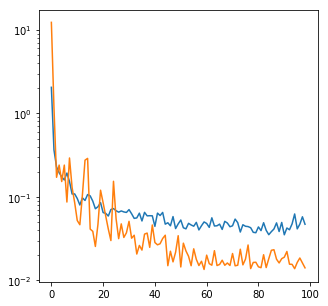

Train Epoch: 1 [0/976 (0%)]	Loss: 1.27642970
Train Epoch: 1 [256/976 (25%)]	Loss: 7.51711516
Train Epoch: 1 [512/976 (50%)]	Loss: 1.58846541
Train Epoch: 1 [768/976 (75%)]	Loss: 0.96758611

Test set: Average loss: 1.0914790685

Train Epoch: 2 [0/976 (0%)]	Loss: 0.98437693
Train Epoch: 2 [256/976 (25%)]	Loss: 0.93812484
Train Epoch: 2 [512/976 (50%)]	Loss: 0.88616314
Train Epoch: 2 [768/976 (75%)]	Loss: 0.72670906

Test set: Average loss: 1.0364559173

Train Epoch: 3 [0/976 (0%)]	Loss: 0.86703831
Train Epoch: 3 [256/976 (25%)]	Loss: 1.09968802
Train Epoch: 3 [512/976 (50%)]	Loss: 0.53293546
Train Epoch: 3 [768/976 (75%)]	Loss: 0.45081903

Test set: Average loss: 1.0193597651

Train Epoch: 4 [0/976 (0%)]	Loss: 0.31107471
Train Epoch: 4 [256/976 (25%)]	Loss: 0.33610064
Train Epoch: 4 [512/976 (50%)]	Loss: 0.30629297
Train Epoch: 4 [768/976 (75%)]	Loss: 0.17070574

Test set: Average loss: 0.4510831062

Train Epoch: 5 [0/976 (0%)]	Loss: 0.32206744
Train Epoch: 5 [256/976 (25%)]	Loss: 0.2436

Train Epoch: 36 [768/976 (75%)]	Loss: 0.02739367

Test set: Average loss: 0.0463079366

Train Epoch: 37 [0/976 (0%)]	Loss: 0.02980907
Train Epoch: 37 [256/976 (25%)]	Loss: 0.04176245
Train Epoch: 37 [512/976 (50%)]	Loss: 0.07196983
Train Epoch: 37 [768/976 (75%)]	Loss: 0.03435655

Test set: Average loss: 0.0440283143

Train Epoch: 38 [0/976 (0%)]	Loss: 0.06521154
Train Epoch: 38 [256/976 (25%)]	Loss: 0.05962993
Train Epoch: 38 [512/976 (50%)]	Loss: 0.03434836
Train Epoch: 38 [768/976 (75%)]	Loss: 0.07773802

Test set: Average loss: 0.0262746146

Train Epoch: 39 [0/976 (0%)]	Loss: 0.03509010
Train Epoch: 39 [256/976 (25%)]	Loss: 0.03635172
Train Epoch: 39 [512/976 (50%)]	Loss: 0.05415701
Train Epoch: 39 [768/976 (75%)]	Loss: 0.05444127

Test set: Average loss: 0.0305365911

Train Epoch: 40 [0/976 (0%)]	Loss: 0.11049825
Train Epoch: 40 [256/976 (25%)]	Loss: 0.11814034
Train Epoch: 40 [512/976 (50%)]	Loss: 0.06488058
Train Epoch: 40 [768/976 (75%)]	Loss: 0.04210011

Test set: Average loss

Train Epoch: 72 [0/976 (0%)]	Loss: 0.05007263
Train Epoch: 72 [256/976 (25%)]	Loss: 0.03042692
Train Epoch: 72 [512/976 (50%)]	Loss: 0.04295880
Train Epoch: 72 [768/976 (75%)]	Loss: 0.03542049

Test set: Average loss: 0.0266972665

Train Epoch: 73 [0/976 (0%)]	Loss: 0.02472681
Train Epoch: 73 [256/976 (25%)]	Loss: 0.03604032
Train Epoch: 73 [512/976 (50%)]	Loss: 0.02166510
Train Epoch: 73 [768/976 (75%)]	Loss: 0.02418858

Test set: Average loss: 0.0177895964

Train Epoch: 74 [0/976 (0%)]	Loss: 0.10240147
Train Epoch: 74 [256/976 (25%)]	Loss: 0.06921393
Train Epoch: 74 [512/976 (50%)]	Loss: 0.07732281
Train Epoch: 74 [768/976 (75%)]	Loss: 0.13155908

Test set: Average loss: 0.0282896165

Train Epoch: 75 [0/976 (0%)]	Loss: 0.06100030
Train Epoch: 75 [256/976 (25%)]	Loss: 0.06610203
Train Epoch: 75 [512/976 (50%)]	Loss: 0.02593784
Train Epoch: 75 [768/976 (75%)]	Loss: 0.04021935

Test set: Average loss: 0.0229058269

Train Epoch: 76 [0/976 (0%)]	Loss: 0.02684058
Train Epoch: 76 [256/976 (

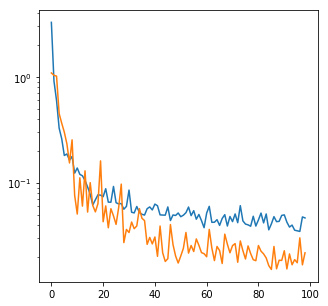

In [20]:
gr, pred = cv(**d)

Train Epoch: 1 [0/457 (0%)]	Loss: 1.36248830
Train Epoch: 1 [256/457 (50%)]	Loss: 2.41584953

Test set: Average loss: 190404.6570304129

Train Epoch: 2 [0/457 (0%)]	Loss: 2.36158681
Train Epoch: 2 [256/457 (50%)]	Loss: 0.63153943

Test set: Average loss: 123.6005444633

Train Epoch: 3 [0/457 (0%)]	Loss: 0.61389145
Train Epoch: 3 [256/457 (50%)]	Loss: 0.49519791

Test set: Average loss: 0.8816017101

Train Epoch: 4 [0/457 (0%)]	Loss: 0.34280852
Train Epoch: 4 [256/457 (50%)]	Loss: 0.23679495

Test set: Average loss: 0.5577377775

Train Epoch: 5 [0/457 (0%)]	Loss: 0.25890926
Train Epoch: 5 [256/457 (50%)]	Loss: 0.27442970

Test set: Average loss: 0.3719373935

Train Epoch: 6 [0/457 (0%)]	Loss: 0.27666735
Train Epoch: 6 [256/457 (50%)]	Loss: 0.20677648

Test set: Average loss: 0.2992230256

Train Epoch: 7 [0/457 (0%)]	Loss: 0.10877073
Train Epoch: 7 [256/457 (50%)]	Loss: 0.15798088

Test set: Average loss: 0.1334063758

Train Epoch: 8 [0/457 (0%)]	Loss: 0.17243737
Train Epoch: 8 [256/457 

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03517270

Test set: Average loss: 0.0942019820

Train Epoch: 63 [0/457 (0%)]	Loss: 0.01653999
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03939867

Test set: Average loss: 0.0743360531

Train Epoch: 64 [0/457 (0%)]	Loss: 0.02325478
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04293871

Test set: Average loss: 0.0876951914

Train Epoch: 65 [0/457 (0%)]	Loss: 0.08345096
Train Epoch: 65 [256/457 (50%)]	Loss: 0.04829274

Test set: Average loss: 0.0712593031

Train Epoch: 66 [0/457 (0%)]	Loss: 0.02156677
Train Epoch: 66 [256/457 (50%)]	Loss: 0.03086179

Test set: Average loss: 0.0770866284

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03386117
Train Epoch: 67 [256/457 (50%)]	Loss: 0.05376216

Test set: Average loss: 0.0757659863

Train Epoch: 68 [0/457 (0%)]	Loss: 0.03715860
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03036374

Test set: Average loss: 0.0696075281

Train Epoch: 69 [0/457 (0%)]	Loss: 0.01688184
Train Epoch: 69 [256/457 (50%)]	Loss: 0.04982987

Test set: Av

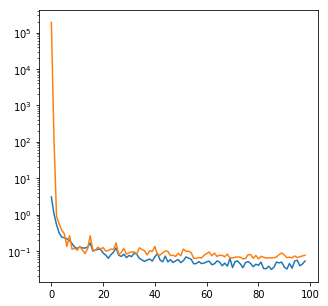

Train Epoch: 1 [0/457 (0%)]	Loss: 1.51246518
Train Epoch: 1 [256/457 (50%)]	Loss: 7.90939491

Test set: Average loss: 6.8722443969

Train Epoch: 2 [0/457 (0%)]	Loss: 0.89864462
Train Epoch: 2 [256/457 (50%)]	Loss: 1.08383778

Test set: Average loss: 4.6591324133

Train Epoch: 3 [0/457 (0%)]	Loss: 0.70106404
Train Epoch: 3 [256/457 (50%)]	Loss: 0.49891068

Test set: Average loss: 21.2382854180

Train Epoch: 4 [0/457 (0%)]	Loss: 0.59759754
Train Epoch: 4 [256/457 (50%)]	Loss: 0.31062870

Test set: Average loss: 1.3920220831

Train Epoch: 5 [0/457 (0%)]	Loss: 0.27984795
Train Epoch: 5 [256/457 (50%)]	Loss: 0.22858932

Test set: Average loss: 1.3188494461

Train Epoch: 6 [0/457 (0%)]	Loss: 0.39042391
Train Epoch: 6 [256/457 (50%)]	Loss: 0.18998501

Test set: Average loss: 0.1807510612

Train Epoch: 7 [0/457 (0%)]	Loss: 0.16115142
Train Epoch: 7 [256/457 (50%)]	Loss: 0.16190146

Test set: Average loss: 0.2799727450

Train Epoch: 8 [0/457 (0%)]	Loss: 0.17703018
Train Epoch: 8 [256/457 (50%)]

Train Epoch: 62 [256/457 (50%)]	Loss: 0.02352497

Test set: Average loss: 0.0548452459

Train Epoch: 63 [0/457 (0%)]	Loss: 0.03357786
Train Epoch: 63 [256/457 (50%)]	Loss: 0.06114120

Test set: Average loss: 0.0536698320

Train Epoch: 64 [0/457 (0%)]	Loss: 0.07627577
Train Epoch: 64 [256/457 (50%)]	Loss: 0.06936149

Test set: Average loss: 0.0465765059

Train Epoch: 65 [0/457 (0%)]	Loss: 0.05223298
Train Epoch: 65 [256/457 (50%)]	Loss: 0.06661403

Test set: Average loss: 0.0390987134

Train Epoch: 66 [0/457 (0%)]	Loss: 0.03785580
Train Epoch: 66 [256/457 (50%)]	Loss: 0.02171830

Test set: Average loss: 0.0455255960

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03058592
Train Epoch: 67 [256/457 (50%)]	Loss: 0.05678050

Test set: Average loss: 0.0468862344

Train Epoch: 68 [0/457 (0%)]	Loss: 0.08066796
Train Epoch: 68 [256/457 (50%)]	Loss: 0.13983848

Test set: Average loss: 0.0456495680

Train Epoch: 69 [0/457 (0%)]	Loss: 0.10264186
Train Epoch: 69 [256/457 (50%)]	Loss: 0.03825539

Test set: Av

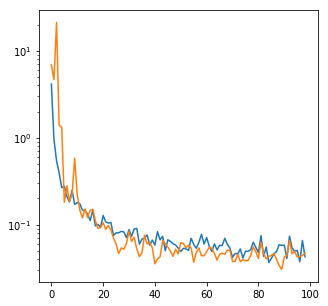

Train Epoch: 1 [0/457 (0%)]	Loss: 1.42972644
Train Epoch: 1 [256/457 (50%)]	Loss: 5.41466941

Test set: Average loss: 168.1969978414

Train Epoch: 2 [0/457 (0%)]	Loss: 0.71238594
Train Epoch: 2 [256/457 (50%)]	Loss: 0.95735106

Test set: Average loss: 31.0782330983

Train Epoch: 3 [0/457 (0%)]	Loss: 0.48322207
Train Epoch: 3 [256/457 (50%)]	Loss: 0.50213514

Test set: Average loss: 21.2240085668

Train Epoch: 4 [0/457 (0%)]	Loss: 0.44489529
Train Epoch: 4 [256/457 (50%)]	Loss: 0.39233219

Test set: Average loss: 1.8535587882

Train Epoch: 5 [0/457 (0%)]	Loss: 0.44232740
Train Epoch: 5 [256/457 (50%)]	Loss: 0.38466064

Test set: Average loss: 3.5133962770

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26391076
Train Epoch: 6 [256/457 (50%)]	Loss: 0.30746312

Test set: Average loss: 0.6412691483

Train Epoch: 7 [0/457 (0%)]	Loss: 0.25440407
Train Epoch: 7 [256/457 (50%)]	Loss: 0.36912370

Test set: Average loss: 0.2792247912

Train Epoch: 8 [0/457 (0%)]	Loss: 0.25861257
Train Epoch: 8 [256/457 (50

Train Epoch: 62 [256/457 (50%)]	Loss: 0.06138011

Test set: Average loss: 0.0267186433

Train Epoch: 63 [0/457 (0%)]	Loss: 0.05711377
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03086688

Test set: Average loss: 0.0288262671

Train Epoch: 64 [0/457 (0%)]	Loss: 0.02352262
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04416431

Test set: Average loss: 0.0254117996

Train Epoch: 65 [0/457 (0%)]	Loss: 0.03025042
Train Epoch: 65 [256/457 (50%)]	Loss: 0.02651565

Test set: Average loss: 0.0229983795

Train Epoch: 66 [0/457 (0%)]	Loss: 0.04188996
Train Epoch: 66 [256/457 (50%)]	Loss: 0.04183983

Test set: Average loss: 0.0227865048

Train Epoch: 67 [0/457 (0%)]	Loss: 0.01878806
Train Epoch: 67 [256/457 (50%)]	Loss: 0.08528835

Test set: Average loss: 0.0261959101

Train Epoch: 68 [0/457 (0%)]	Loss: 0.04998617
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03358253

Test set: Average loss: 0.0344196097

Train Epoch: 69 [0/457 (0%)]	Loss: 0.05842444
Train Epoch: 69 [256/457 (50%)]	Loss: 0.08206840

Test set: Av

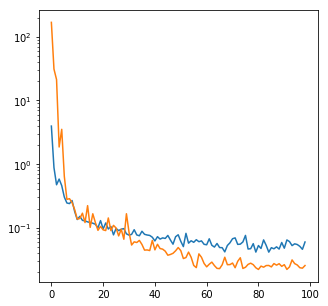

Train Epoch: 1 [0/457 (0%)]	Loss: 2.12977432
Train Epoch: 1 [256/457 (50%)]	Loss: 3.15071549

Test set: Average loss: 595.2880139844

Train Epoch: 2 [0/457 (0%)]	Loss: 1.45217798
Train Epoch: 2 [256/457 (50%)]	Loss: 0.93581681

Test set: Average loss: 10.0519005281

Train Epoch: 3 [0/457 (0%)]	Loss: 0.67662227
Train Epoch: 3 [256/457 (50%)]	Loss: 0.48734920

Test set: Average loss: 80.6578009722

Train Epoch: 4 [0/457 (0%)]	Loss: 0.58305525
Train Epoch: 4 [256/457 (50%)]	Loss: 0.33731637

Test set: Average loss: 2.5746500562

Train Epoch: 5 [0/457 (0%)]	Loss: 0.23936290
Train Epoch: 5 [256/457 (50%)]	Loss: 0.30739100

Test set: Average loss: 1.0824954147

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26544085
Train Epoch: 6 [256/457 (50%)]	Loss: 0.14119097

Test set: Average loss: 0.4550878242

Train Epoch: 7 [0/457 (0%)]	Loss: 0.20944602
Train Epoch: 7 [256/457 (50%)]	Loss: 0.27674877

Test set: Average loss: 0.1722700588

Train Epoch: 8 [0/457 (0%)]	Loss: 0.21895241
Train Epoch: 8 [256/457 (50

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04407334

Test set: Average loss: 0.0376094838

Train Epoch: 63 [0/457 (0%)]	Loss: 0.02009119
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03171197

Test set: Average loss: 0.0464715272

Train Epoch: 64 [0/457 (0%)]	Loss: 0.03823326
Train Epoch: 64 [256/457 (50%)]	Loss: 0.05860631

Test set: Average loss: 0.0378624605

Train Epoch: 65 [0/457 (0%)]	Loss: 0.03853974
Train Epoch: 65 [256/457 (50%)]	Loss: 0.03638848

Test set: Average loss: 0.0355255032

Train Epoch: 66 [0/457 (0%)]	Loss: 0.02838724
Train Epoch: 66 [256/457 (50%)]	Loss: 0.03054668

Test set: Average loss: 0.0377740234

Train Epoch: 67 [0/457 (0%)]	Loss: 0.04902076
Train Epoch: 67 [256/457 (50%)]	Loss: 0.03623087

Test set: Average loss: 0.0396885164

Train Epoch: 68 [0/457 (0%)]	Loss: 0.05438352
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03162400

Test set: Average loss: 0.0410252451

Train Epoch: 69 [0/457 (0%)]	Loss: 0.05305998
Train Epoch: 69 [256/457 (50%)]	Loss: 0.05281467

Test set: Av

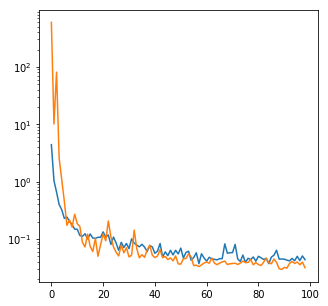

Train Epoch: 1 [0/457 (0%)]	Loss: 1.33501207
Train Epoch: 1 [256/457 (50%)]	Loss: 5.51556501

Test set: Average loss: 495.3241850230

Train Epoch: 2 [0/457 (0%)]	Loss: 1.37100712
Train Epoch: 2 [256/457 (50%)]	Loss: 1.28269528

Test set: Average loss: 23.0167719353

Train Epoch: 3 [0/457 (0%)]	Loss: 1.17737022
Train Epoch: 3 [256/457 (50%)]	Loss: 0.84870523

Test set: Average loss: 4.5277295674

Train Epoch: 4 [0/457 (0%)]	Loss: 0.62626016
Train Epoch: 4 [256/457 (50%)]	Loss: 0.71672318

Test set: Average loss: 5.0543093282

Train Epoch: 5 [0/457 (0%)]	Loss: 0.64689478
Train Epoch: 5 [256/457 (50%)]	Loss: 0.72837939

Test set: Average loss: 0.8001865520

Train Epoch: 6 [0/457 (0%)]	Loss: 0.36851597
Train Epoch: 6 [256/457 (50%)]	Loss: 0.42743869

Test set: Average loss: 0.3736819466

Train Epoch: 7 [0/457 (0%)]	Loss: 0.47307232
Train Epoch: 7 [256/457 (50%)]	Loss: 0.32993503

Test set: Average loss: 0.2934780500

Train Epoch: 8 [0/457 (0%)]	Loss: 0.30215942
Train Epoch: 8 [256/457 (50%

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04046612

Test set: Average loss: 0.0274750212

Train Epoch: 63 [0/457 (0%)]	Loss: 0.05896058
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03541364

Test set: Average loss: 0.0390626672

Train Epoch: 64 [0/457 (0%)]	Loss: 0.07265504
Train Epoch: 64 [256/457 (50%)]	Loss: 0.06875416

Test set: Average loss: 0.0236728555

Train Epoch: 65 [0/457 (0%)]	Loss: 0.03272281
Train Epoch: 65 [256/457 (50%)]	Loss: 0.04473446

Test set: Average loss: 0.0325479157

Train Epoch: 66 [0/457 (0%)]	Loss: 0.02734339
Train Epoch: 66 [256/457 (50%)]	Loss: 0.10860093

Test set: Average loss: 0.0249803298

Train Epoch: 67 [0/457 (0%)]	Loss: 0.09375967
Train Epoch: 67 [256/457 (50%)]	Loss: 0.05278377

Test set: Average loss: 0.0236668812

Train Epoch: 68 [0/457 (0%)]	Loss: 0.02583466
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03064229

Test set: Average loss: 0.0267356443

Train Epoch: 69 [0/457 (0%)]	Loss: 0.07677043
Train Epoch: 69 [256/457 (50%)]	Loss: 0.03404245

Test set: Av

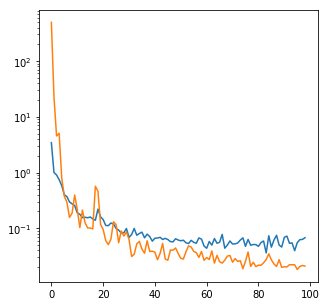

Train Epoch: 1 [0/457 (0%)]	Loss: 1.59994295
Train Epoch: 1 [256/457 (50%)]	Loss: 5.18352462

Test set: Average loss: 8.6342637256

Train Epoch: 2 [0/457 (0%)]	Loss: 1.08628297
Train Epoch: 2 [256/457 (50%)]	Loss: 0.59785872

Test set: Average loss: 4.8202252191

Train Epoch: 3 [0/457 (0%)]	Loss: 0.36533114
Train Epoch: 3 [256/457 (50%)]	Loss: 0.26877987

Test set: Average loss: 2.9995071765

Train Epoch: 4 [0/457 (0%)]	Loss: 0.37115438
Train Epoch: 4 [256/457 (50%)]	Loss: 0.24173210

Test set: Average loss: 0.5572385536

Train Epoch: 5 [0/457 (0%)]	Loss: 0.21704558
Train Epoch: 5 [256/457 (50%)]	Loss: 0.14262805

Test set: Average loss: 0.1611070228

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26298691
Train Epoch: 6 [256/457 (50%)]	Loss: 0.18648891

Test set: Average loss: 0.2407964073

Train Epoch: 7 [0/457 (0%)]	Loss: 0.30975941
Train Epoch: 7 [256/457 (50%)]	Loss: 0.18597914

Test set: Average loss: 0.9844776403

Train Epoch: 8 [0/457 (0%)]	Loss: 0.18652145
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03237483

Test set: Average loss: 0.0260527566

Train Epoch: 63 [0/457 (0%)]	Loss: 0.06422768
Train Epoch: 63 [256/457 (50%)]	Loss: 0.04108351

Test set: Average loss: 0.0266742628

Train Epoch: 64 [0/457 (0%)]	Loss: 0.03118246
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04171933

Test set: Average loss: 0.0509935974

Train Epoch: 65 [0/457 (0%)]	Loss: 0.04860119
Train Epoch: 65 [256/457 (50%)]	Loss: 0.02634344

Test set: Average loss: 0.0232783643

Train Epoch: 66 [0/457 (0%)]	Loss: 0.04257039
Train Epoch: 66 [256/457 (50%)]	Loss: 0.05321144

Test set: Average loss: 0.0240754533

Train Epoch: 67 [0/457 (0%)]	Loss: 0.07364518
Train Epoch: 67 [256/457 (50%)]	Loss: 0.07381971

Test set: Average loss: 0.0263229199

Train Epoch: 68 [0/457 (0%)]	Loss: 0.06292920
Train Epoch: 68 [256/457 (50%)]	Loss: 0.02286877

Test set: Average loss: 0.0293045799

Train Epoch: 69 [0/457 (0%)]	Loss: 0.03289568
Train Epoch: 69 [256/457 (50%)]	Loss: 0.02962055

Test set: Av

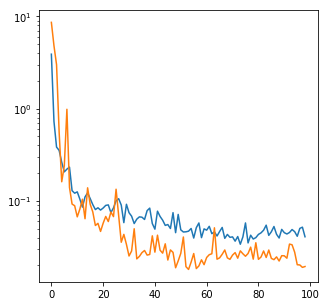

Train Epoch: 1 [0/457 (0%)]	Loss: 1.27802437
Train Epoch: 1 [256/457 (50%)]	Loss: 5.80389976

Test set: Average loss: 2.1856845013

Train Epoch: 2 [0/457 (0%)]	Loss: 0.97846619
Train Epoch: 2 [256/457 (50%)]	Loss: 0.90268385

Test set: Average loss: 8.7666242076

Train Epoch: 3 [0/457 (0%)]	Loss: 0.70212411
Train Epoch: 3 [256/457 (50%)]	Loss: 0.44299616

Test set: Average loss: 2.3227673196

Train Epoch: 4 [0/457 (0%)]	Loss: 0.35174241
Train Epoch: 4 [256/457 (50%)]	Loss: 0.40619891

Test set: Average loss: 0.5538194724

Train Epoch: 5 [0/457 (0%)]	Loss: 0.37335244
Train Epoch: 5 [256/457 (50%)]	Loss: 0.28678965

Test set: Average loss: 0.3083179417

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26390269
Train Epoch: 6 [256/457 (50%)]	Loss: 0.17367699

Test set: Average loss: 0.3091099789

Train Epoch: 7 [0/457 (0%)]	Loss: 0.13291208
Train Epoch: 7 [256/457 (50%)]	Loss: 0.20987620

Test set: Average loss: 0.2276995544

Train Epoch: 8 [0/457 (0%)]	Loss: 0.22512488
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.07477091

Test set: Average loss: 0.0446493189

Train Epoch: 63 [0/457 (0%)]	Loss: 0.03260983
Train Epoch: 63 [256/457 (50%)]	Loss: 0.02656813

Test set: Average loss: 0.0534865103

Train Epoch: 64 [0/457 (0%)]	Loss: 0.09080801
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04067570

Test set: Average loss: 0.0472726746

Train Epoch: 65 [0/457 (0%)]	Loss: 0.03764488
Train Epoch: 65 [256/457 (50%)]	Loss: 0.01694443

Test set: Average loss: 0.0501137725

Train Epoch: 66 [0/457 (0%)]	Loss: 0.12390257
Train Epoch: 66 [256/457 (50%)]	Loss: 0.05520415

Test set: Average loss: 0.0664325749

Train Epoch: 67 [0/457 (0%)]	Loss: 0.02765462
Train Epoch: 67 [256/457 (50%)]	Loss: 0.03617250

Test set: Average loss: 0.0571482537

Train Epoch: 68 [0/457 (0%)]	Loss: 0.05105492
Train Epoch: 68 [256/457 (50%)]	Loss: 0.06822091

Test set: Average loss: 0.0458771800

Train Epoch: 69 [0/457 (0%)]	Loss: 0.01652730
Train Epoch: 69 [256/457 (50%)]	Loss: 0.03658697

Test set: Av

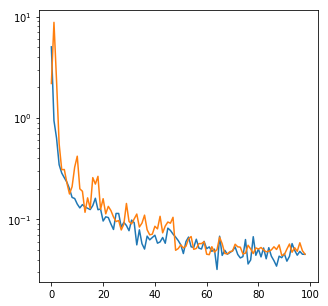

Train Epoch: 1 [0/457 (0%)]	Loss: 0.90758896
Train Epoch: 1 [256/457 (50%)]	Loss: 4.94488390

Test set: Average loss: 291.6851715285

Train Epoch: 2 [0/457 (0%)]	Loss: 0.99131446
Train Epoch: 2 [256/457 (50%)]	Loss: 0.52483785

Test set: Average loss: 1.1405227624

Train Epoch: 3 [0/457 (0%)]	Loss: 0.43833945
Train Epoch: 3 [256/457 (50%)]	Loss: 0.36269300

Test set: Average loss: 0.5707466120

Train Epoch: 4 [0/457 (0%)]	Loss: 0.23257609
Train Epoch: 4 [256/457 (50%)]	Loss: 0.22620145

Test set: Average loss: 0.3186753127

Train Epoch: 5 [0/457 (0%)]	Loss: 0.19706705
Train Epoch: 5 [256/457 (50%)]	Loss: 0.10497757

Test set: Average loss: 0.2239319274

Train Epoch: 6 [0/457 (0%)]	Loss: 0.10699201
Train Epoch: 6 [256/457 (50%)]	Loss: 0.15382370

Test set: Average loss: 0.3410210213

Train Epoch: 7 [0/457 (0%)]	Loss: 0.14332430
Train Epoch: 7 [256/457 (50%)]	Loss: 0.15930221

Test set: Average loss: 0.1572513117

Train Epoch: 8 [0/457 (0%)]	Loss: 0.06895405
Train Epoch: 8 [256/457 (50%)

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03936924

Test set: Average loss: 0.0642496143

Train Epoch: 63 [0/457 (0%)]	Loss: 0.04020313
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03878998

Test set: Average loss: 0.0499048807

Train Epoch: 64 [0/457 (0%)]	Loss: 0.03447436
Train Epoch: 64 [256/457 (50%)]	Loss: 0.05373088

Test set: Average loss: 0.0469043265

Train Epoch: 65 [0/457 (0%)]	Loss: 0.04605237
Train Epoch: 65 [256/457 (50%)]	Loss: 0.04975760

Test set: Average loss: 0.0458787676

Train Epoch: 66 [0/457 (0%)]	Loss: 0.01642684
Train Epoch: 66 [256/457 (50%)]	Loss: 0.03645783

Test set: Average loss: 0.0444682583

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03280513
Train Epoch: 67 [256/457 (50%)]	Loss: 0.10947832

Test set: Average loss: 0.0430496031

Train Epoch: 68 [0/457 (0%)]	Loss: 0.02150561
Train Epoch: 68 [256/457 (50%)]	Loss: 0.02997255

Test set: Average loss: 0.0533446091

Train Epoch: 69 [0/457 (0%)]	Loss: 0.03599215
Train Epoch: 69 [256/457 (50%)]	Loss: 0.04152970

Test set: Av

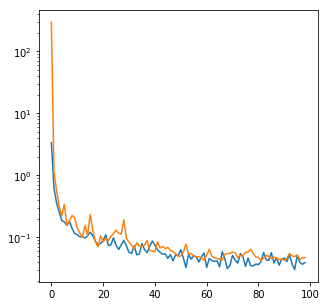

Train Epoch: 1 [0/458 (0%)]	Loss: 1.12956080
Train Epoch: 1 [256/458 (50%)]	Loss: 9.61425531

Test set: Average loss: 22.2820662688

Train Epoch: 2 [0/458 (0%)]	Loss: 1.31566297
Train Epoch: 2 [256/458 (50%)]	Loss: 0.83394900

Test set: Average loss: 8.5970717758

Train Epoch: 3 [0/458 (0%)]	Loss: 0.79373998
Train Epoch: 3 [256/458 (50%)]	Loss: 0.95378429

Test set: Average loss: 0.7256200053

Train Epoch: 4 [0/458 (0%)]	Loss: 0.45566774
Train Epoch: 4 [256/458 (50%)]	Loss: 0.46192037

Test set: Average loss: 1.6679603594

Train Epoch: 5 [0/458 (0%)]	Loss: 0.49750685
Train Epoch: 5 [256/458 (50%)]	Loss: 0.26731590

Test set: Average loss: 0.5554066654

Train Epoch: 6 [0/458 (0%)]	Loss: 0.31757202
Train Epoch: 6 [256/458 (50%)]	Loss: 0.32228707

Test set: Average loss: 0.6286583333

Train Epoch: 7 [0/458 (0%)]	Loss: 0.40487672
Train Epoch: 7 [256/458 (50%)]	Loss: 0.23482282

Test set: Average loss: 0.2526427044

Train Epoch: 8 [0/458 (0%)]	Loss: 0.29665259
Train Epoch: 8 [256/458 (50%)]

Train Epoch: 62 [256/458 (50%)]	Loss: 0.02257406

Test set: Average loss: 0.0436423466

Train Epoch: 63 [0/458 (0%)]	Loss: 0.08847918
Train Epoch: 63 [256/458 (50%)]	Loss: 0.03311904

Test set: Average loss: 0.0422023790

Train Epoch: 64 [0/458 (0%)]	Loss: 0.06167688
Train Epoch: 64 [256/458 (50%)]	Loss: 0.04781452

Test set: Average loss: 0.0412683530

Train Epoch: 65 [0/458 (0%)]	Loss: 0.02921211
Train Epoch: 65 [256/458 (50%)]	Loss: 0.05638162

Test set: Average loss: 0.0439766462

Train Epoch: 66 [0/458 (0%)]	Loss: 0.06624279
Train Epoch: 66 [256/458 (50%)]	Loss: 0.05936745

Test set: Average loss: 0.0460406139

Train Epoch: 67 [0/458 (0%)]	Loss: 0.07457448
Train Epoch: 67 [256/458 (50%)]	Loss: 0.08858326

Test set: Average loss: 0.0405312940

Train Epoch: 68 [0/458 (0%)]	Loss: 0.07087568
Train Epoch: 68 [256/458 (50%)]	Loss: 0.05086649

Test set: Average loss: 0.0380291236

Train Epoch: 69 [0/458 (0%)]	Loss: 0.05851935
Train Epoch: 69 [256/458 (50%)]	Loss: 0.05743884

Test set: Av

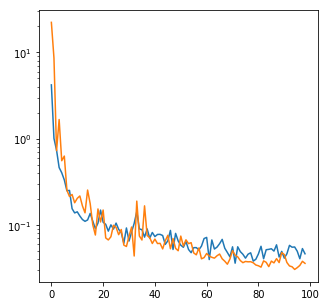

Train Epoch: 1 [0/458 (0%)]	Loss: 3.28364136
Train Epoch: 1 [256/458 (50%)]	Loss: 6.60918407

Test set: Average loss: 2.4338306556

Train Epoch: 2 [0/458 (0%)]	Loss: 1.01498241
Train Epoch: 2 [256/458 (50%)]	Loss: 0.61755874

Test set: Average loss: 0.3747401246

Train Epoch: 3 [0/458 (0%)]	Loss: 0.50262026
Train Epoch: 3 [256/458 (50%)]	Loss: 0.31411547

Test set: Average loss: 0.3067067989

Train Epoch: 4 [0/458 (0%)]	Loss: 0.28841623
Train Epoch: 4 [256/458 (50%)]	Loss: 0.23892823

Test set: Average loss: 0.4233281394

Train Epoch: 5 [0/458 (0%)]	Loss: 0.27804334
Train Epoch: 5 [256/458 (50%)]	Loss: 0.30705342

Test set: Average loss: 0.3579168861

Train Epoch: 6 [0/458 (0%)]	Loss: 0.36476142
Train Epoch: 6 [256/458 (50%)]	Loss: 0.33987428

Test set: Average loss: 0.2343754811

Train Epoch: 7 [0/458 (0%)]	Loss: 0.20203583
Train Epoch: 7 [256/458 (50%)]	Loss: 0.18203622

Test set: Average loss: 0.1751399160

Train Epoch: 8 [0/458 (0%)]	Loss: 0.21460650
Train Epoch: 8 [256/458 (50%)]	

Train Epoch: 62 [256/458 (50%)]	Loss: 0.05883641

Test set: Average loss: 0.0696631250

Train Epoch: 63 [0/458 (0%)]	Loss: 0.05464045
Train Epoch: 63 [256/458 (50%)]	Loss: 0.06690901

Test set: Average loss: 0.0704490677

Train Epoch: 64 [0/458 (0%)]	Loss: 0.05570491
Train Epoch: 64 [256/458 (50%)]	Loss: 0.03990337

Test set: Average loss: 0.0432782558

Train Epoch: 65 [0/458 (0%)]	Loss: 0.06764629
Train Epoch: 65 [256/458 (50%)]	Loss: 0.03493748

Test set: Average loss: 0.0524357999

Train Epoch: 66 [0/458 (0%)]	Loss: 0.03401566
Train Epoch: 66 [256/458 (50%)]	Loss: 0.11213645

Test set: Average loss: 0.0424944235

Train Epoch: 67 [0/458 (0%)]	Loss: 0.03268677
Train Epoch: 67 [256/458 (50%)]	Loss: 0.04249901

Test set: Average loss: 0.0408163052

Train Epoch: 68 [0/458 (0%)]	Loss: 0.04487083
Train Epoch: 68 [256/458 (50%)]	Loss: 0.03790932

Test set: Average loss: 0.0441607939

Train Epoch: 69 [0/458 (0%)]	Loss: 0.03811770
Train Epoch: 69 [256/458 (50%)]	Loss: 0.02244323

Test set: Av

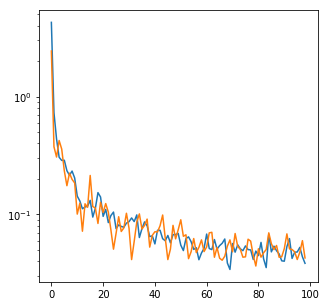

In [22]:
gr, pred = cv(**d)

Train Epoch: 1 [0/457 (0%)]	Loss: 1.28905033
Train Epoch: 1 [256/457 (50%)]	Loss: 1.23348881

Test set: Average loss: 10.3527845515

Train Epoch: 2 [0/457 (0%)]	Loss: 1.26539593
Train Epoch: 2 [256/457 (50%)]	Loss: 0.53776973

Test set: Average loss: 1.7315248486

Train Epoch: 3 [0/457 (0%)]	Loss: 0.51928910
Train Epoch: 3 [256/457 (50%)]	Loss: 0.33640421

Test set: Average loss: 1.9691163952

Train Epoch: 4 [0/457 (0%)]	Loss: 0.33612204
Train Epoch: 4 [256/457 (50%)]	Loss: 0.25862547

Test set: Average loss: 1.0219534009

Train Epoch: 5 [0/457 (0%)]	Loss: 0.23185490
Train Epoch: 5 [256/457 (50%)]	Loss: 0.29196470

Test set: Average loss: 0.3682303306

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26182147
Train Epoch: 6 [256/457 (50%)]	Loss: 0.19183841

Test set: Average loss: 0.3185903170

Train Epoch: 7 [0/457 (0%)]	Loss: 0.12263514
Train Epoch: 7 [256/457 (50%)]	Loss: 0.18452518

Test set: Average loss: 0.1417461321

Train Epoch: 8 [0/457 (0%)]	Loss: 0.12119771
Train Epoch: 8 [256/457 (50%)]

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03302707

Test set: Average loss: 0.0907909015

Train Epoch: 63 [0/457 (0%)]	Loss: 0.02656712
Train Epoch: 63 [256/457 (50%)]	Loss: 0.05342807

Test set: Average loss: 0.0772897232

Train Epoch: 64 [0/457 (0%)]	Loss: 0.03578119
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04044258

Test set: Average loss: 0.0941005176

Train Epoch: 65 [0/457 (0%)]	Loss: 0.07700463
Train Epoch: 65 [256/457 (50%)]	Loss: 0.04672253

Test set: Average loss: 0.0818524813

Train Epoch: 66 [0/457 (0%)]	Loss: 0.03557145
Train Epoch: 66 [256/457 (50%)]	Loss: 0.02688625

Test set: Average loss: 0.0886646975

Train Epoch: 67 [0/457 (0%)]	Loss: 0.02937248
Train Epoch: 67 [256/457 (50%)]	Loss: 0.04407972

Test set: Average loss: 0.0802150962

Train Epoch: 68 [0/457 (0%)]	Loss: 0.03125850
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03211542

Test set: Average loss: 0.0673919466

Train Epoch: 69 [0/457 (0%)]	Loss: 0.02397404
Train Epoch: 69 [256/457 (50%)]	Loss: 0.05142308

Test set: Av


Test set: Average loss: 0.0738683183

Train Epoch: 132 [0/457 (0%)]	Loss: 0.01995299
Train Epoch: 132 [256/457 (50%)]	Loss: 0.04644117

Test set: Average loss: 0.0756112332

Train Epoch: 133 [0/457 (0%)]	Loss: 0.03313851
Train Epoch: 133 [256/457 (50%)]	Loss: 0.02750900

Test set: Average loss: 0.0667996771

Train Epoch: 134 [0/457 (0%)]	Loss: 0.02166711
Train Epoch: 134 [256/457 (50%)]	Loss: 0.03751758

Test set: Average loss: 0.0679338170

Train Epoch: 135 [0/457 (0%)]	Loss: 0.04815971
Train Epoch: 135 [256/457 (50%)]	Loss: 0.02916167

Test set: Average loss: 0.0684734524

Train Epoch: 136 [0/457 (0%)]	Loss: 0.04544065
Train Epoch: 136 [256/457 (50%)]	Loss: 0.02598183

Test set: Average loss: 0.0680847118

Train Epoch: 137 [0/457 (0%)]	Loss: 0.03628461
Train Epoch: 137 [256/457 (50%)]	Loss: 0.03333069

Test set: Average loss: 0.0711963770

Train Epoch: 138 [0/457 (0%)]	Loss: 0.03211142
Train Epoch: 138 [256/457 (50%)]	Loss: 0.03748766

Test set: Average loss: 0.0754473153

Train Epo

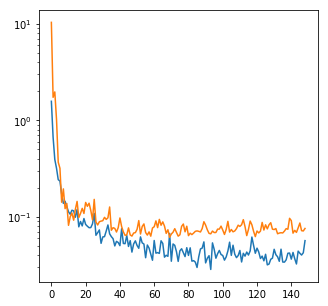

Train Epoch: 1 [0/457 (0%)]	Loss: 1.41747932
Train Epoch: 1 [256/457 (50%)]	Loss: 1.10643854

Test set: Average loss: 1.0690812963

Train Epoch: 2 [0/457 (0%)]	Loss: 0.55315671
Train Epoch: 2 [256/457 (50%)]	Loss: 0.67737885

Test set: Average loss: 2.3640958933

Train Epoch: 3 [0/457 (0%)]	Loss: 0.68557232
Train Epoch: 3 [256/457 (50%)]	Loss: 0.43939860

Test set: Average loss: 1.8431612296

Train Epoch: 4 [0/457 (0%)]	Loss: 0.38539217
Train Epoch: 4 [256/457 (50%)]	Loss: 0.24717617

Test set: Average loss: 0.7634000319

Train Epoch: 5 [0/457 (0%)]	Loss: 0.26622337
Train Epoch: 5 [256/457 (50%)]	Loss: 0.08461106

Test set: Average loss: 0.5911984374

Train Epoch: 6 [0/457 (0%)]	Loss: 0.17172482
Train Epoch: 6 [256/457 (50%)]	Loss: 0.12941469

Test set: Average loss: 0.3564442907

Train Epoch: 7 [0/457 (0%)]	Loss: 0.16934733
Train Epoch: 7 [256/457 (50%)]	Loss: 0.15594487

Test set: Average loss: 0.1032206050

Train Epoch: 8 [0/457 (0%)]	Loss: 0.23105305
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04218845

Test set: Average loss: 0.0412708444

Train Epoch: 63 [0/457 (0%)]	Loss: 0.02646634
Train Epoch: 63 [256/457 (50%)]	Loss: 0.02604047

Test set: Average loss: 0.0340472501

Train Epoch: 64 [0/457 (0%)]	Loss: 0.02717333
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04378318

Test set: Average loss: 0.0420427228

Train Epoch: 65 [0/457 (0%)]	Loss: 0.05085109
Train Epoch: 65 [256/457 (50%)]	Loss: 0.04911381

Test set: Average loss: 0.0544072643

Train Epoch: 66 [0/457 (0%)]	Loss: 0.05033108
Train Epoch: 66 [256/457 (50%)]	Loss: 0.06893709

Test set: Average loss: 0.0527851770

Train Epoch: 67 [0/457 (0%)]	Loss: 0.06930564
Train Epoch: 67 [256/457 (50%)]	Loss: 0.04381480

Test set: Average loss: 0.0503608320

Train Epoch: 68 [0/457 (0%)]	Loss: 0.02824539
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03425555

Test set: Average loss: 0.0399255740

Train Epoch: 69 [0/457 (0%)]	Loss: 0.09381109
Train Epoch: 69 [256/457 (50%)]	Loss: 0.04085816

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.04330596

Test set: Average loss: 0.0376272400

Train Epoch: 124 [0/457 (0%)]	Loss: 0.05807870
Train Epoch: 124 [256/457 (50%)]	Loss: 0.02842395

Test set: Average loss: 0.0537175411

Train Epoch: 125 [0/457 (0%)]	Loss: 0.02156641
Train Epoch: 125 [256/457 (50%)]	Loss: 0.03767173

Test set: Average loss: 0.0522191578

Train Epoch: 126 [0/457 (0%)]	Loss: 0.04770738
Train Epoch: 126 [256/457 (50%)]	Loss: 0.02922695

Test set: Average loss: 0.0445516631

Train Epoch: 127 [0/457 (0%)]	Loss: 0.04839199
Train Epoch: 127 [256/457 (50%)]	Loss: 0.05760463

Test set: Average loss: 0.0486310572

Train Epoch: 128 [0/457 (0%)]	Loss: 0.04829758
Train Epoch: 128 [256/457 (50%)]	Loss: 0.02706055

Test set: Average loss: 0.0434403818

Train Epoch: 129 [0/457 (0%)]	Loss: 0.05094814
Train Epoch: 129 [256/457 (50%)]	Loss: 0.03566584

Test set: Average loss: 0.0385250989

Train Epoch: 130 [0/457 (0%)]	Loss: 0.02997319
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0288837

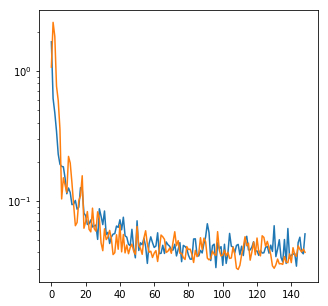

Train Epoch: 1 [0/457 (0%)]	Loss: 1.67822060
Train Epoch: 1 [256/457 (50%)]	Loss: 1.44452449

Test set: Average loss: 10.0846149343

Train Epoch: 2 [0/457 (0%)]	Loss: 0.82002562
Train Epoch: 2 [256/457 (50%)]	Loss: 0.55004365

Test set: Average loss: 2.3659179867

Train Epoch: 3 [0/457 (0%)]	Loss: 0.63699321
Train Epoch: 3 [256/457 (50%)]	Loss: 0.39310346

Test set: Average loss: 0.8932739040

Train Epoch: 4 [0/457 (0%)]	Loss: 0.37219461
Train Epoch: 4 [256/457 (50%)]	Loss: 0.26472954

Test set: Average loss: 0.4739053133

Train Epoch: 5 [0/457 (0%)]	Loss: 0.21461808
Train Epoch: 5 [256/457 (50%)]	Loss: 0.17711165

Test set: Average loss: 0.1148425847

Train Epoch: 6 [0/457 (0%)]	Loss: 0.12277206
Train Epoch: 6 [256/457 (50%)]	Loss: 0.13825868

Test set: Average loss: 0.0967089315

Train Epoch: 7 [0/457 (0%)]	Loss: 0.14187529
Train Epoch: 7 [256/457 (50%)]	Loss: 0.14695719

Test set: Average loss: 0.1149918036

Train Epoch: 8 [0/457 (0%)]	Loss: 0.10276868
Train Epoch: 8 [256/457 (50%)]

Train Epoch: 62 [256/457 (50%)]	Loss: 0.05067502

Test set: Average loss: 0.0223066917

Train Epoch: 63 [0/457 (0%)]	Loss: 0.09465388
Train Epoch: 63 [256/457 (50%)]	Loss: 0.08365242

Test set: Average loss: 0.0252147516

Train Epoch: 64 [0/457 (0%)]	Loss: 0.03751453
Train Epoch: 64 [256/457 (50%)]	Loss: 0.05786799

Test set: Average loss: 0.0273323124

Train Epoch: 65 [0/457 (0%)]	Loss: 0.05716878
Train Epoch: 65 [256/457 (50%)]	Loss: 0.02530337

Test set: Average loss: 0.0251781198

Train Epoch: 66 [0/457 (0%)]	Loss: 0.05585351
Train Epoch: 66 [256/457 (50%)]	Loss: 0.09894164

Test set: Average loss: 0.0285851635

Train Epoch: 67 [0/457 (0%)]	Loss: 0.02811486
Train Epoch: 67 [256/457 (50%)]	Loss: 0.03887049

Test set: Average loss: 0.0277415123

Train Epoch: 68 [0/457 (0%)]	Loss: 0.05744704
Train Epoch: 68 [256/457 (50%)]	Loss: 0.08288959

Test set: Average loss: 0.0239083916

Train Epoch: 69 [0/457 (0%)]	Loss: 0.05816657
Train Epoch: 69 [256/457 (50%)]	Loss: 0.06266019

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.03317369

Test set: Average loss: 0.0254379631

Train Epoch: 124 [0/457 (0%)]	Loss: 0.03068987
Train Epoch: 124 [256/457 (50%)]	Loss: 0.08291149

Test set: Average loss: 0.0223096318

Train Epoch: 125 [0/457 (0%)]	Loss: 0.03622899
Train Epoch: 125 [256/457 (50%)]	Loss: 0.02468163

Test set: Average loss: 0.0230774571

Train Epoch: 126 [0/457 (0%)]	Loss: 0.02074186
Train Epoch: 126 [256/457 (50%)]	Loss: 0.03926492

Test set: Average loss: 0.0212384840

Train Epoch: 127 [0/457 (0%)]	Loss: 0.07442082
Train Epoch: 127 [256/457 (50%)]	Loss: 0.05370108

Test set: Average loss: 0.0235824844

Train Epoch: 128 [0/457 (0%)]	Loss: 0.03815235
Train Epoch: 128 [256/457 (50%)]	Loss: 0.05274355

Test set: Average loss: 0.0248740736

Train Epoch: 129 [0/457 (0%)]	Loss: 0.03526001
Train Epoch: 129 [256/457 (50%)]	Loss: 0.06877877

Test set: Average loss: 0.0212975470

Train Epoch: 130 [0/457 (0%)]	Loss: 0.06861319
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0194863

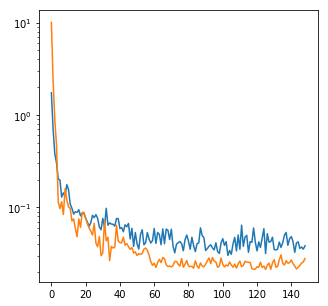

Train Epoch: 1 [0/457 (0%)]	Loss: 1.20600303
Train Epoch: 1 [256/457 (50%)]	Loss: 1.08364161

Test set: Average loss: 2.7753503604

Train Epoch: 2 [0/457 (0%)]	Loss: 0.79598857
Train Epoch: 2 [256/457 (50%)]	Loss: 0.61746795

Test set: Average loss: 0.8009293053

Train Epoch: 3 [0/457 (0%)]	Loss: 0.62432510
Train Epoch: 3 [256/457 (50%)]	Loss: 0.57919138

Test set: Average loss: 0.5732043767

Train Epoch: 4 [0/457 (0%)]	Loss: 0.26533582
Train Epoch: 4 [256/457 (50%)]	Loss: 0.34843170

Test set: Average loss: 0.4939633536

Train Epoch: 5 [0/457 (0%)]	Loss: 0.26241319
Train Epoch: 5 [256/457 (50%)]	Loss: 0.26399132

Test set: Average loss: 0.5081406441

Train Epoch: 6 [0/457 (0%)]	Loss: 0.26451074
Train Epoch: 6 [256/457 (50%)]	Loss: 0.14086097

Test set: Average loss: 0.3688073453

Train Epoch: 7 [0/457 (0%)]	Loss: 0.32644586
Train Epoch: 7 [256/457 (50%)]	Loss: 0.15306356

Test set: Average loss: 0.1271708802

Train Epoch: 8 [0/457 (0%)]	Loss: 0.10454785
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03566833

Test set: Average loss: 0.0379130102

Train Epoch: 63 [0/457 (0%)]	Loss: 0.01646328
Train Epoch: 63 [256/457 (50%)]	Loss: 0.03800213

Test set: Average loss: 0.0389662152

Train Epoch: 64 [0/457 (0%)]	Loss: 0.05829946
Train Epoch: 64 [256/457 (50%)]	Loss: 0.05988268

Test set: Average loss: 0.0310181599

Train Epoch: 65 [0/457 (0%)]	Loss: 0.04179146
Train Epoch: 65 [256/457 (50%)]	Loss: 0.03730930

Test set: Average loss: 0.0310205169

Train Epoch: 66 [0/457 (0%)]	Loss: 0.07734539
Train Epoch: 66 [256/457 (50%)]	Loss: 0.04339302

Test set: Average loss: 0.0303358718

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03309195
Train Epoch: 67 [256/457 (50%)]	Loss: 0.06163601

Test set: Average loss: 0.0306855807

Train Epoch: 68 [0/457 (0%)]	Loss: 0.04998961
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03753787

Test set: Average loss: 0.0400366651

Train Epoch: 69 [0/457 (0%)]	Loss: 0.03790027
Train Epoch: 69 [256/457 (50%)]	Loss: 0.04755547

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.03685966

Test set: Average loss: 0.0333898474

Train Epoch: 124 [0/457 (0%)]	Loss: 0.01886479
Train Epoch: 124 [256/457 (50%)]	Loss: 0.02031266

Test set: Average loss: 0.0306857477

Train Epoch: 125 [0/457 (0%)]	Loss: 0.06062619
Train Epoch: 125 [256/457 (50%)]	Loss: 0.04185605

Test set: Average loss: 0.0287441057

Train Epoch: 126 [0/457 (0%)]	Loss: 0.07164731
Train Epoch: 126 [256/457 (50%)]	Loss: 0.02819627

Test set: Average loss: 0.0293867005

Train Epoch: 127 [0/457 (0%)]	Loss: 0.02497957
Train Epoch: 127 [256/457 (50%)]	Loss: 0.07201936

Test set: Average loss: 0.0338995233

Train Epoch: 128 [0/457 (0%)]	Loss: 0.06989491
Train Epoch: 128 [256/457 (50%)]	Loss: 0.03636285

Test set: Average loss: 0.0293513519

Train Epoch: 129 [0/457 (0%)]	Loss: 0.03103591
Train Epoch: 129 [256/457 (50%)]	Loss: 0.03066616

Test set: Average loss: 0.0300448226

Train Epoch: 130 [0/457 (0%)]	Loss: 0.11686509
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0285899

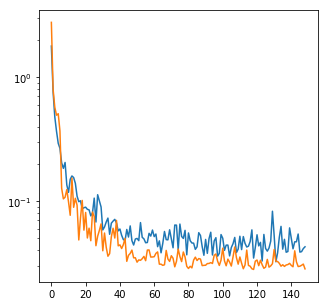

Train Epoch: 1 [0/457 (0%)]	Loss: 1.35515424
Train Epoch: 1 [256/457 (50%)]	Loss: 0.92563821

Test set: Average loss: 2.1509235951

Train Epoch: 2 [0/457 (0%)]	Loss: 0.89067184
Train Epoch: 2 [256/457 (50%)]	Loss: 0.49869272

Test set: Average loss: 1.8690224359

Train Epoch: 3 [0/457 (0%)]	Loss: 0.51385111
Train Epoch: 3 [256/457 (50%)]	Loss: 0.35613337

Test set: Average loss: 0.7205553001

Train Epoch: 4 [0/457 (0%)]	Loss: 0.36772272
Train Epoch: 4 [256/457 (50%)]	Loss: 0.29108732

Test set: Average loss: 1.1143206246

Train Epoch: 5 [0/457 (0%)]	Loss: 0.15565755
Train Epoch: 5 [256/457 (50%)]	Loss: 0.35100980

Test set: Average loss: 0.5031170565

Train Epoch: 6 [0/457 (0%)]	Loss: 0.30263505
Train Epoch: 6 [256/457 (50%)]	Loss: 0.17835078

Test set: Average loss: 0.2579211532

Train Epoch: 7 [0/457 (0%)]	Loss: 0.23727913
Train Epoch: 7 [256/457 (50%)]	Loss: 0.14226834

Test set: Average loss: 0.2450342798

Train Epoch: 8 [0/457 (0%)]	Loss: 0.15151165
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04906251

Test set: Average loss: 0.0405597688

Train Epoch: 63 [0/457 (0%)]	Loss: 0.03908906
Train Epoch: 63 [256/457 (50%)]	Loss: 0.07785829

Test set: Average loss: 0.0534564233

Train Epoch: 64 [0/457 (0%)]	Loss: 0.04009310
Train Epoch: 64 [256/457 (50%)]	Loss: 0.04467797

Test set: Average loss: 0.0581496075

Train Epoch: 65 [0/457 (0%)]	Loss: 0.07676481
Train Epoch: 65 [256/457 (50%)]	Loss: 0.03290630

Test set: Average loss: 0.0499995140

Train Epoch: 66 [0/457 (0%)]	Loss: 0.03360977
Train Epoch: 66 [256/457 (50%)]	Loss: 0.03793167

Test set: Average loss: 0.0429787895

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03277601
Train Epoch: 67 [256/457 (50%)]	Loss: 0.10885795

Test set: Average loss: 0.0522393024

Train Epoch: 68 [0/457 (0%)]	Loss: 0.07512070
Train Epoch: 68 [256/457 (50%)]	Loss: 0.02893007

Test set: Average loss: 0.0455073703

Train Epoch: 69 [0/457 (0%)]	Loss: 0.02662400
Train Epoch: 69 [256/457 (50%)]	Loss: 0.02940009

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.05403516

Test set: Average loss: 0.0353075034

Train Epoch: 124 [0/457 (0%)]	Loss: 0.03514243
Train Epoch: 124 [256/457 (50%)]	Loss: 0.02512645

Test set: Average loss: 0.0340522466

Train Epoch: 125 [0/457 (0%)]	Loss: 0.02913583
Train Epoch: 125 [256/457 (50%)]	Loss: 0.03326260

Test set: Average loss: 0.0361977654

Train Epoch: 126 [0/457 (0%)]	Loss: 0.04322620
Train Epoch: 126 [256/457 (50%)]	Loss: 0.03937897

Test set: Average loss: 0.0323624398

Train Epoch: 127 [0/457 (0%)]	Loss: 0.01934703
Train Epoch: 127 [256/457 (50%)]	Loss: 0.04320672

Test set: Average loss: 0.0341150987

Train Epoch: 128 [0/457 (0%)]	Loss: 0.02668282
Train Epoch: 128 [256/457 (50%)]	Loss: 0.12260700

Test set: Average loss: 0.0339837706

Train Epoch: 129 [0/457 (0%)]	Loss: 0.04826992
Train Epoch: 129 [256/457 (50%)]	Loss: 0.08714801

Test set: Average loss: 0.0323235069

Train Epoch: 130 [0/457 (0%)]	Loss: 0.08681689
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0436765

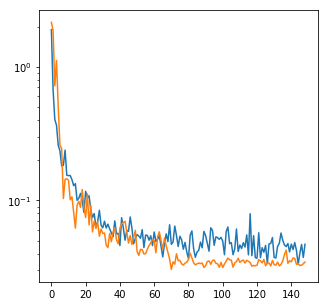

Train Epoch: 1 [0/457 (0%)]	Loss: 0.91655052
Train Epoch: 1 [256/457 (50%)]	Loss: 1.65238401

Test set: Average loss: 25.8017697573

Train Epoch: 2 [0/457 (0%)]	Loss: 0.71656748
Train Epoch: 2 [256/457 (50%)]	Loss: 0.40664750

Test set: Average loss: 0.8045591488

Train Epoch: 3 [0/457 (0%)]	Loss: 0.44587570
Train Epoch: 3 [256/457 (50%)]	Loss: 0.59059224

Test set: Average loss: 0.7042997917

Train Epoch: 4 [0/457 (0%)]	Loss: 0.45790507
Train Epoch: 4 [256/457 (50%)]	Loss: 0.31903110

Test set: Average loss: 0.4945349952

Train Epoch: 5 [0/457 (0%)]	Loss: 0.21713917
Train Epoch: 5 [256/457 (50%)]	Loss: 0.22087374

Test set: Average loss: 0.6273282827

Train Epoch: 6 [0/457 (0%)]	Loss: 0.19996734
Train Epoch: 6 [256/457 (50%)]	Loss: 0.21935067

Test set: Average loss: 0.1831366203

Train Epoch: 7 [0/457 (0%)]	Loss: 0.15286119
Train Epoch: 7 [256/457 (50%)]	Loss: 0.21509034

Test set: Average loss: 0.3076538482

Train Epoch: 8 [0/457 (0%)]	Loss: 0.16952680
Train Epoch: 8 [256/457 (50%)]

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04790453

Test set: Average loss: 0.0180449131

Train Epoch: 63 [0/457 (0%)]	Loss: 0.02857683
Train Epoch: 63 [256/457 (50%)]	Loss: 0.12487679

Test set: Average loss: 0.0187371078

Train Epoch: 64 [0/457 (0%)]	Loss: 0.08371766
Train Epoch: 64 [256/457 (50%)]	Loss: 0.02833503

Test set: Average loss: 0.0242810182

Train Epoch: 65 [0/457 (0%)]	Loss: 0.04004998
Train Epoch: 65 [256/457 (50%)]	Loss: 0.03591721

Test set: Average loss: 0.0207830205

Train Epoch: 66 [0/457 (0%)]	Loss: 0.05209238
Train Epoch: 66 [256/457 (50%)]	Loss: 0.03158294

Test set: Average loss: 0.0157215680

Train Epoch: 67 [0/457 (0%)]	Loss: 0.03445026
Train Epoch: 67 [256/457 (50%)]	Loss: 0.06294516

Test set: Average loss: 0.0154767938

Train Epoch: 68 [0/457 (0%)]	Loss: 0.04371301
Train Epoch: 68 [256/457 (50%)]	Loss: 0.04389205

Test set: Average loss: 0.0243671565

Train Epoch: 69 [0/457 (0%)]	Loss: 0.06362462
Train Epoch: 69 [256/457 (50%)]	Loss: 0.08906567

Test set: Av


Test set: Average loss: 0.0136585780

Train Epoch: 132 [0/457 (0%)]	Loss: 0.02502226
Train Epoch: 132 [256/457 (50%)]	Loss: 0.04310535

Test set: Average loss: 0.0135448392

Train Epoch: 133 [0/457 (0%)]	Loss: 0.04925582
Train Epoch: 133 [256/457 (50%)]	Loss: 0.04153804

Test set: Average loss: 0.0188167011

Train Epoch: 134 [0/457 (0%)]	Loss: 0.04604715
Train Epoch: 134 [256/457 (50%)]	Loss: 0.01597509

Test set: Average loss: 0.0182874191

Train Epoch: 135 [0/457 (0%)]	Loss: 0.02599320
Train Epoch: 135 [256/457 (50%)]	Loss: 0.03069891

Test set: Average loss: 0.0163183783

Train Epoch: 136 [0/457 (0%)]	Loss: 0.04388650
Train Epoch: 136 [256/457 (50%)]	Loss: 0.05529453

Test set: Average loss: 0.0174609613

Train Epoch: 137 [0/457 (0%)]	Loss: 0.05262793
Train Epoch: 137 [256/457 (50%)]	Loss: 0.05065714

Test set: Average loss: 0.0163027601

Train Epoch: 138 [0/457 (0%)]	Loss: 0.02848176
Train Epoch: 138 [256/457 (50%)]	Loss: 0.03024967

Test set: Average loss: 0.0163756746

Train Epo

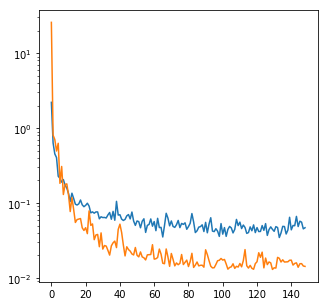

Train Epoch: 1 [0/457 (0%)]	Loss: 1.71924862
Train Epoch: 1 [256/457 (50%)]	Loss: 0.78809216

Test set: Average loss: 1.5845666605

Train Epoch: 2 [0/457 (0%)]	Loss: 0.98877106
Train Epoch: 2 [256/457 (50%)]	Loss: 0.96101472

Test set: Average loss: 0.9680425341

Train Epoch: 3 [0/457 (0%)]	Loss: 0.75427643
Train Epoch: 3 [256/457 (50%)]	Loss: 0.51031323

Test set: Average loss: 0.8683122599

Train Epoch: 4 [0/457 (0%)]	Loss: 0.44655472
Train Epoch: 4 [256/457 (50%)]	Loss: 0.22826655

Test set: Average loss: 0.4534842447

Train Epoch: 5 [0/457 (0%)]	Loss: 0.31145954
Train Epoch: 5 [256/457 (50%)]	Loss: 0.24937499

Test set: Average loss: 0.2306604868

Train Epoch: 6 [0/457 (0%)]	Loss: 0.16157424
Train Epoch: 6 [256/457 (50%)]	Loss: 0.33869677

Test set: Average loss: 0.2112740406

Train Epoch: 7 [0/457 (0%)]	Loss: 0.25571852
Train Epoch: 7 [256/457 (50%)]	Loss: 0.19530054

Test set: Average loss: 0.2447575167

Train Epoch: 8 [0/457 (0%)]	Loss: 0.36214250
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.04379664

Test set: Average loss: 0.0239744694

Train Epoch: 63 [0/457 (0%)]	Loss: 0.06314878
Train Epoch: 63 [256/457 (50%)]	Loss: 0.02941282

Test set: Average loss: 0.0251463038

Train Epoch: 64 [0/457 (0%)]	Loss: 0.04191670
Train Epoch: 64 [256/457 (50%)]	Loss: 0.09323206

Test set: Average loss: 0.0242729798

Train Epoch: 65 [0/457 (0%)]	Loss: 0.02968482
Train Epoch: 65 [256/457 (50%)]	Loss: 0.03271065

Test set: Average loss: 0.0262979638

Train Epoch: 66 [0/457 (0%)]	Loss: 0.02940986
Train Epoch: 66 [256/457 (50%)]	Loss: 0.02403625

Test set: Average loss: 0.0234877139

Train Epoch: 67 [0/457 (0%)]	Loss: 0.05895631
Train Epoch: 67 [256/457 (50%)]	Loss: 0.02642927

Test set: Average loss: 0.0228170662

Train Epoch: 68 [0/457 (0%)]	Loss: 0.02900536
Train Epoch: 68 [256/457 (50%)]	Loss: 0.05294130

Test set: Average loss: 0.0324177103

Train Epoch: 69 [0/457 (0%)]	Loss: 0.02971268
Train Epoch: 69 [256/457 (50%)]	Loss: 0.02314453

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.02320232

Test set: Average loss: 0.0201728993

Train Epoch: 124 [0/457 (0%)]	Loss: 0.04828810
Train Epoch: 124 [256/457 (50%)]	Loss: 0.05650243

Test set: Average loss: 0.0208165911

Train Epoch: 125 [0/457 (0%)]	Loss: 0.02625962
Train Epoch: 125 [256/457 (50%)]	Loss: 0.04753860

Test set: Average loss: 0.0216807287

Train Epoch: 126 [0/457 (0%)]	Loss: 0.02846944
Train Epoch: 126 [256/457 (50%)]	Loss: 0.06885474

Test set: Average loss: 0.0215237191

Train Epoch: 127 [0/457 (0%)]	Loss: 0.06580687
Train Epoch: 127 [256/457 (50%)]	Loss: 0.02534332

Test set: Average loss: 0.0197571168

Train Epoch: 128 [0/457 (0%)]	Loss: 0.02406072
Train Epoch: 128 [256/457 (50%)]	Loss: 0.02848886

Test set: Average loss: 0.0227039680

Train Epoch: 129 [0/457 (0%)]	Loss: 0.04745255
Train Epoch: 129 [256/457 (50%)]	Loss: 0.10297010

Test set: Average loss: 0.0210342077

Train Epoch: 130 [0/457 (0%)]	Loss: 0.04393952
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0345139

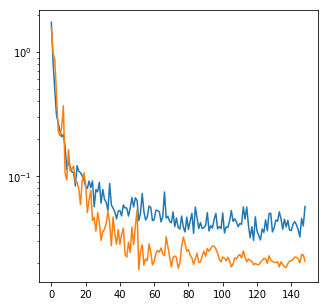

Train Epoch: 1 [0/457 (0%)]	Loss: 1.79465507
Train Epoch: 1 [256/457 (50%)]	Loss: 1.68368470

Test set: Average loss: 3.8110168423

Train Epoch: 2 [0/457 (0%)]	Loss: 1.91122987
Train Epoch: 2 [256/457 (50%)]	Loss: 0.68055528

Test set: Average loss: 0.8238241655

Train Epoch: 3 [0/457 (0%)]	Loss: 0.63083247
Train Epoch: 3 [256/457 (50%)]	Loss: 0.31223059

Test set: Average loss: 1.6407278104

Train Epoch: 4 [0/457 (0%)]	Loss: 0.37745783
Train Epoch: 4 [256/457 (50%)]	Loss: 0.21299567

Test set: Average loss: 0.7026356922

Train Epoch: 5 [0/457 (0%)]	Loss: 0.36426961
Train Epoch: 5 [256/457 (50%)]	Loss: 0.29040301

Test set: Average loss: 0.9040266422

Train Epoch: 6 [0/457 (0%)]	Loss: 0.20861280
Train Epoch: 6 [256/457 (50%)]	Loss: 0.23523418

Test set: Average loss: 0.3581575575

Train Epoch: 7 [0/457 (0%)]	Loss: 0.17288879
Train Epoch: 7 [256/457 (50%)]	Loss: 0.15294699

Test set: Average loss: 0.1815949470

Train Epoch: 8 [0/457 (0%)]	Loss: 0.14963550
Train Epoch: 8 [256/457 (50%)]	

Train Epoch: 62 [256/457 (50%)]	Loss: 0.03317919

Test set: Average loss: 0.0803626146

Train Epoch: 63 [0/457 (0%)]	Loss: 0.03992797
Train Epoch: 63 [256/457 (50%)]	Loss: 0.06515106

Test set: Average loss: 0.0730045600

Train Epoch: 64 [0/457 (0%)]	Loss: 0.04791665
Train Epoch: 64 [256/457 (50%)]	Loss: 0.03200074

Test set: Average loss: 0.0664646410

Train Epoch: 65 [0/457 (0%)]	Loss: 0.02047269
Train Epoch: 65 [256/457 (50%)]	Loss: 0.02472976

Test set: Average loss: 0.0698047424

Train Epoch: 66 [0/457 (0%)]	Loss: 0.05069872
Train Epoch: 66 [256/457 (50%)]	Loss: 0.02060978

Test set: Average loss: 0.0688884650

Train Epoch: 67 [0/457 (0%)]	Loss: 0.04140571
Train Epoch: 67 [256/457 (50%)]	Loss: 0.04085202

Test set: Average loss: 0.0657283024

Train Epoch: 68 [0/457 (0%)]	Loss: 0.02904964
Train Epoch: 68 [256/457 (50%)]	Loss: 0.03338788

Test set: Average loss: 0.0688848542

Train Epoch: 69 [0/457 (0%)]	Loss: 0.02405972
Train Epoch: 69 [256/457 (50%)]	Loss: 0.07069165

Test set: Av

Train Epoch: 123 [256/457 (50%)]	Loss: 0.03812138

Test set: Average loss: 0.0695057194

Train Epoch: 124 [0/457 (0%)]	Loss: 0.05303448
Train Epoch: 124 [256/457 (50%)]	Loss: 0.04463467

Test set: Average loss: 0.0702953211

Train Epoch: 125 [0/457 (0%)]	Loss: 0.08231589
Train Epoch: 125 [256/457 (50%)]	Loss: 0.02824222

Test set: Average loss: 0.0801507466

Train Epoch: 126 [0/457 (0%)]	Loss: 0.02947645
Train Epoch: 126 [256/457 (50%)]	Loss: 0.06895650

Test set: Average loss: 0.0679022988

Train Epoch: 127 [0/457 (0%)]	Loss: 0.02479063
Train Epoch: 127 [256/457 (50%)]	Loss: 0.05928118

Test set: Average loss: 0.0760774044

Train Epoch: 128 [0/457 (0%)]	Loss: 0.02859988
Train Epoch: 128 [256/457 (50%)]	Loss: 0.02993754

Test set: Average loss: 0.0706194711

Train Epoch: 129 [0/457 (0%)]	Loss: 0.08058461
Train Epoch: 129 [256/457 (50%)]	Loss: 0.02781066

Test set: Average loss: 0.0698358189

Train Epoch: 130 [0/457 (0%)]	Loss: 0.03499693
Train Epoch: 130 [256/457 (50%)]	Loss: 0.0355817

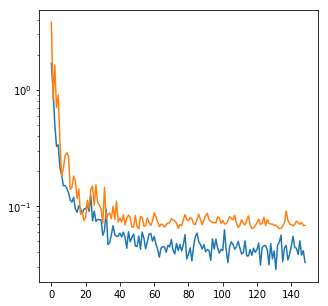

Train Epoch: 1 [0/458 (0%)]	Loss: 1.53618695
Train Epoch: 1 [256/458 (50%)]	Loss: 1.35376477

Test set: Average loss: 1.0038992283

Train Epoch: 2 [0/458 (0%)]	Loss: 1.24301780
Train Epoch: 2 [256/458 (50%)]	Loss: 0.69980247

Test set: Average loss: 1.4659746831

Train Epoch: 3 [0/458 (0%)]	Loss: 0.40661762
Train Epoch: 3 [256/458 (50%)]	Loss: 0.28785781

Test set: Average loss: 0.4748869809

Train Epoch: 4 [0/458 (0%)]	Loss: 0.25980565
Train Epoch: 4 [256/458 (50%)]	Loss: 0.23255590

Test set: Average loss: 0.2864663599

Train Epoch: 5 [0/458 (0%)]	Loss: 0.23113383
Train Epoch: 5 [256/458 (50%)]	Loss: 0.24235271

Test set: Average loss: 0.1932426800

Train Epoch: 6 [0/458 (0%)]	Loss: 0.17485283
Train Epoch: 6 [256/458 (50%)]	Loss: 0.18499747

Test set: Average loss: 0.2367976673

Train Epoch: 7 [0/458 (0%)]	Loss: 0.25481043
Train Epoch: 7 [256/458 (50%)]	Loss: 0.21128258

Test set: Average loss: 0.2434584916

Train Epoch: 8 [0/458 (0%)]	Loss: 0.14223049
Train Epoch: 8 [256/458 (50%)]	

Train Epoch: 62 [256/458 (50%)]	Loss: 0.04047058

Test set: Average loss: 0.0576180486

Train Epoch: 63 [0/458 (0%)]	Loss: 0.08952147
Train Epoch: 63 [256/458 (50%)]	Loss: 0.05294954

Test set: Average loss: 0.0528523298

Train Epoch: 64 [0/458 (0%)]	Loss: 0.03125991
Train Epoch: 64 [256/458 (50%)]	Loss: 0.08907395

Test set: Average loss: 0.0617531945

Train Epoch: 65 [0/458 (0%)]	Loss: 0.05445449
Train Epoch: 65 [256/458 (50%)]	Loss: 0.03858924

Test set: Average loss: 0.0564608816

Train Epoch: 66 [0/458 (0%)]	Loss: 0.04777787
Train Epoch: 66 [256/458 (50%)]	Loss: 0.04798549

Test set: Average loss: 0.0554113072

Train Epoch: 67 [0/458 (0%)]	Loss: 0.08411509
Train Epoch: 67 [256/458 (50%)]	Loss: 0.02680519

Test set: Average loss: 0.0619310234

Train Epoch: 68 [0/458 (0%)]	Loss: 0.03938980
Train Epoch: 68 [256/458 (50%)]	Loss: 0.02961887

Test set: Average loss: 0.0612407089

Train Epoch: 69 [0/458 (0%)]	Loss: 0.08705129
Train Epoch: 69 [256/458 (50%)]	Loss: 0.12224461

Test set: Av

Train Epoch: 123 [256/458 (50%)]	Loss: 0.03554961

Test set: Average loss: 0.0591368611

Train Epoch: 124 [0/458 (0%)]	Loss: 0.02051533
Train Epoch: 124 [256/458 (50%)]	Loss: 0.05415053

Test set: Average loss: 0.0611850908

Train Epoch: 125 [0/458 (0%)]	Loss: 0.02027286
Train Epoch: 125 [256/458 (50%)]	Loss: 0.02895645

Test set: Average loss: 0.0575077753

Train Epoch: 126 [0/458 (0%)]	Loss: 0.02710902
Train Epoch: 126 [256/458 (50%)]	Loss: 0.04879110

Test set: Average loss: 0.0549377072

Train Epoch: 127 [0/458 (0%)]	Loss: 0.05753503
Train Epoch: 127 [256/458 (50%)]	Loss: 0.03067909

Test set: Average loss: 0.0561061767

Train Epoch: 128 [0/458 (0%)]	Loss: 0.03990981
Train Epoch: 128 [256/458 (50%)]	Loss: 0.04956155

Test set: Average loss: 0.0593387141

Train Epoch: 129 [0/458 (0%)]	Loss: 0.01799295
Train Epoch: 129 [256/458 (50%)]	Loss: 0.07644512

Test set: Average loss: 0.0579906010

Train Epoch: 130 [0/458 (0%)]	Loss: 0.07561540
Train Epoch: 130 [256/458 (50%)]	Loss: 0.0376513

In [ ]:
gt, pred = cv(**d)

In [21]:
a, b = _

In [12]:
folder_name = 'soil_cv'
import os
import pickle
import numpy as np

In [28]:
def load_res(folder_name):
    with open(os.path.join(folder_name, 'gt.pkl'), 'rb') as f:
        gt = pickle.load(f)
    with open(os.path.join(folder_name, 'pred.pkl'), 'rb') as f:
        pred = pickle.load(f)
    return np.array(gt), np.array(pred)

In [15]:
import plots
import imp

In [17]:
imp.reload(plots)

<module 'plots' from '/home/evlavrukhin/speed_calc/plots.py'>

In [29]:
gt, pred = load_res('soil_cv')

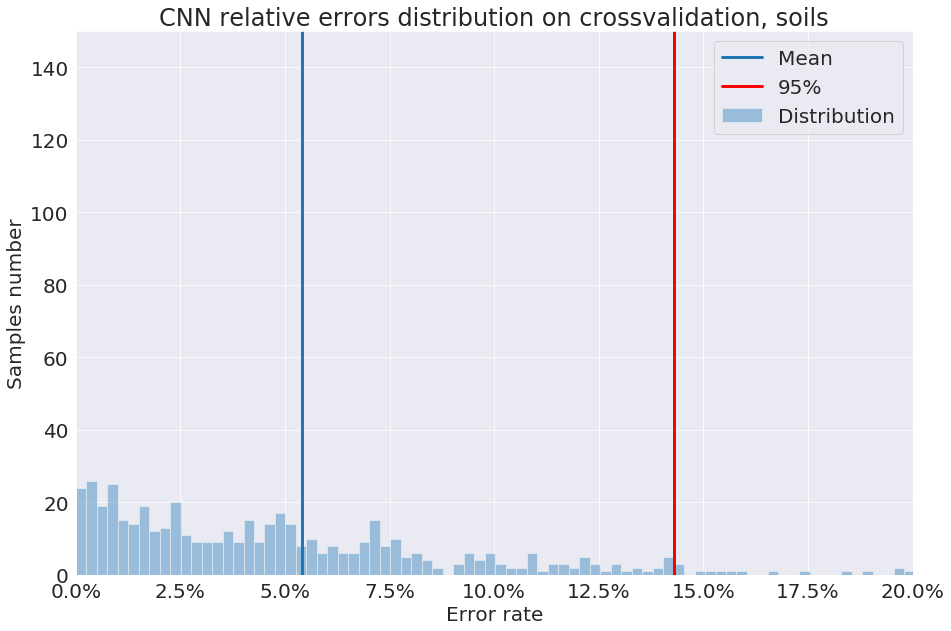

In [31]:
plots.plot_mape(gt, pred, 
                'CNN relative errors distribution on crossvalidation, soils', 'poster_images/cnn_soil', maxx=0.2, maxy=150)

In [35]:
gt, pred = load_res('cv')

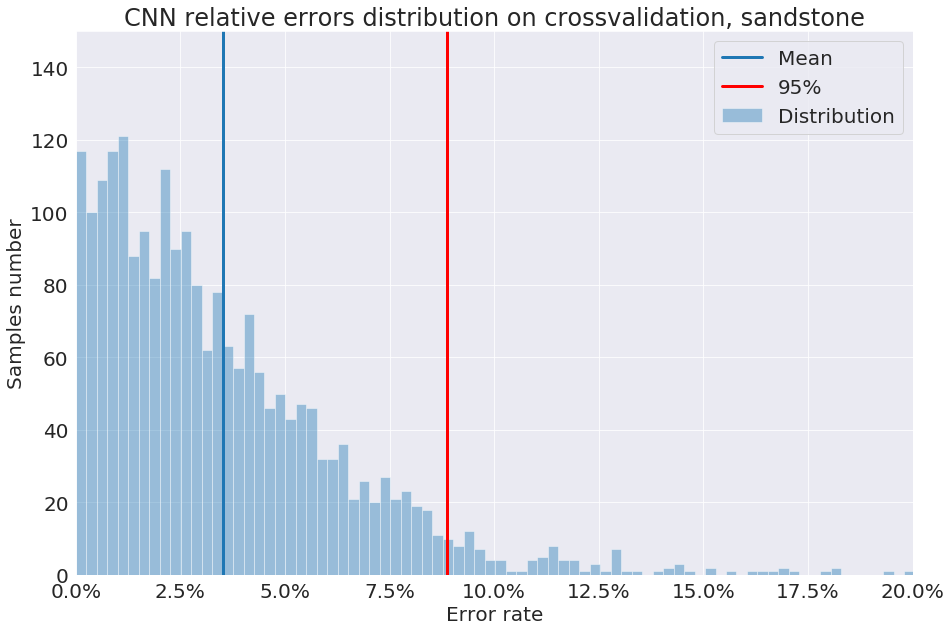

In [36]:
plots.plot_mape(gt, pred, 'CNN relative errors distribution on crossvalidation, sandstone', 'poster_images/cnn_sand', maxx=0.2, maxy=150)

In [34]:
gt, pred = load_res('carb_cv')

In [27]:
gt = np.array(gr)
pred = np.array(pred)

In [29]:
import plots

In [ ]:
plots.plot_mape(gt, pred, 'CNN relative errors distribution on crossvalidation, carbonate', 'poster_images/cnn_carb', maxx=0.2, maxy=150)

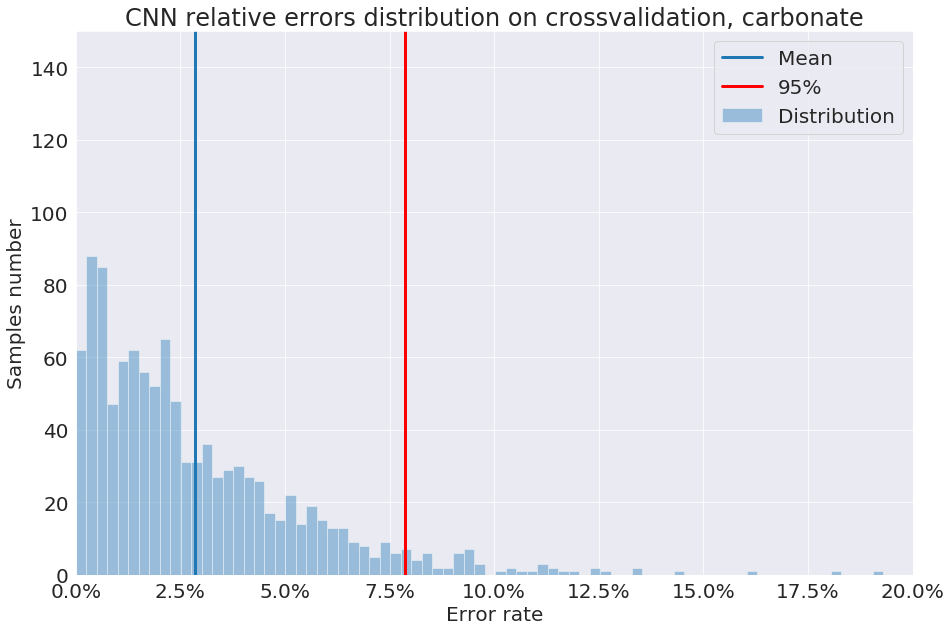

In [47]:
plots.plot_mape(gt, pred, 'CNN relative errors distribution on crossvalidation, carbonate', 'cnn_carb', maxx=0.2, maxy=150)

In [39]:
with open('cv/gt.pkl', 'rb') as f:
    a = pickle.load(f)
with open('cv/pred.pkl', 'rb') as f:
    b = pickle.load(f)

In [41]:
((np.array(a) - np.array(b)) ** 2).mean()

6.836220431658523e-07

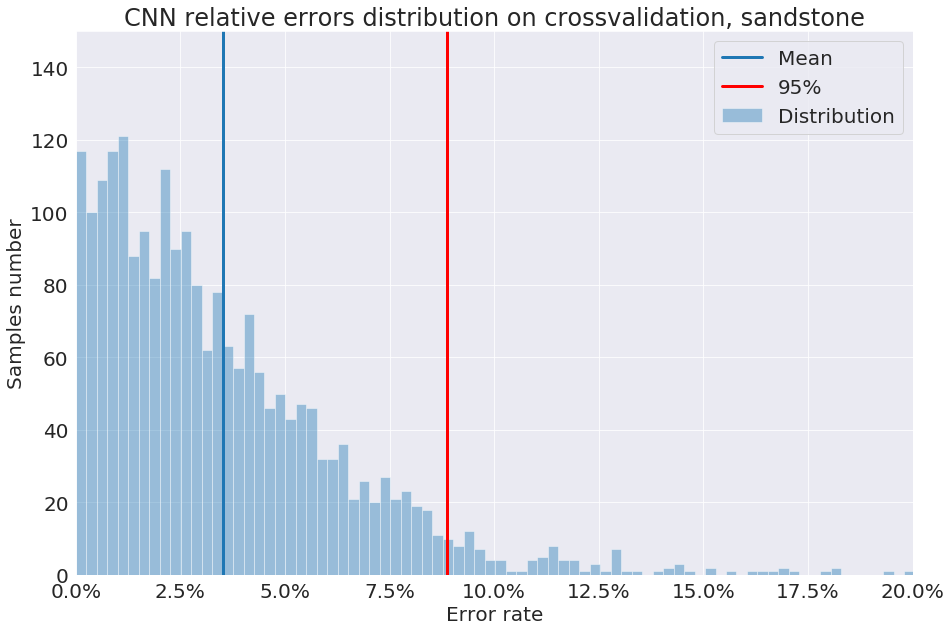

In [46]:
plots.plot_mape(np.array(a),
                np.array(b),
                'CNN relative errors distribution on crossvalidation, sandstone', 'cnn_sand', maxx=0.2, maxy=150)

In [65]:
scaler = StandardScaler().fit(Y.reshape(-1, 1))

In [85]:
from albumentations import Compose
import albumentations

path = 'carb/images'
target_path = 'carb/NN/carb_calc.ods'

data = get_data(target_path)
df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index("'mod_no'")

images = []
Y = []
resized = []
for fname in sorted(os.listdir(path)):
    name, ext = fname.split('.')
    if ext != 'bmp':
        continue
    Y.append(float(df.loc["'" + name + "'", "'cd/area^2'"][1:-1]))
    fpath = os.path.join(path, fname)
    img = mpimg.imread(fpath)
    img = (255 - img).astype(bool).astype(int)
    rescale = Compose([
        albumentations.PadIfNeeded(min_height=np.max(img.shape), 
                                   min_width=np.max(img.shape),
                                   border_mode=0,
                                   always_apply=True),
        albumentations.Resize(height=22, width=22, interpolation=0, always_apply=True)
    ], p=1)
    resized.append(rescale(image=img)['image'])
    img = np.repeat(img.reshape(img.shape[0], img.shape[1], 1), 3, axis=2).astype(np.float64)
#     img = 255 - np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = (255 - img).astype(np.float64) / 255
#     img = np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = imread(fpath)
    images.append(img)
# Y = np.array(Y, dtype=np.float64)

In [88]:
dataset = MyDataset(images, Y, aug=test_aug)
dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=10, 
                        pin_memory=True)

In [93]:
model = PretrainedNet(models.resnet34, True).double().to(device)

In [95]:
Y = np.array(Y)

In [96]:
gt = np.copy(Y)
pred_full = np.zeros_like(gt, dtype=np.float64)

In [98]:
for fname in os.listdir('cv'):
    if fname[:5] != 'model':
        continue
    with open(os.path.join('cv', fname), 'rb') as f:
        state_dict = torch.load(f)
    model.load_state_dict(state_dict)
    gt, pred = test(model, device, dataloader)
    break
    gt = scaler.inverse_transform(gt.reshape(-1, 1)).flatten()
    pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    pred_full += pred
pred_full /= 10


Test set: Average loss: 0.9955682658


Test set: Average loss: 1.0290686773


Test set: Average loss: 1.0132723362


Test set: Average loss: 0.9789404497


Test set: Average loss: 1.0131719120


Test set: Average loss: 0.9876589798


Test set: Average loss: 1.0753131700


Test set: Average loss: 0.9895023004


Test set: Average loss: 0.9942691916


Test set: Average loss: 0.9645516726



In [101]:
((pred_full - gt) ** 2).mean()

3.797660750588147e-06

In [ ]:
plots.plot_mape(gt, pred, 'CNN relative errors distribution on carbonate holdout', 'cnn_carb')

In [10]:
batch_size = 64

In [11]:
train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

In [12]:
model = PretrainedNet().double().to(device)

In [13]:
# model = ConvNet(h, w, 3, nonlinearity=F.relu, pad=0).double().to(device)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
# scheduler = None

In [16]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))

In [17]:
epochs_number = 150

In [18]:
# ((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
#   - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean()

Train Epoch: 1 [0/2005 (0%)]	Loss: 0.96794551
Train Epoch: 1 [256/2005 (12%)]	Loss: 0.66198659
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.69797047
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.51067440
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.23818803
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.21753049
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.30733763
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.21976623

Test set: Average loss: 1.0544096059

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.25098240
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.17193843
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.25816155
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.17376990
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.14130846
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.17182546
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.26045310
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.24062201

Test set: Average loss: 0.3055550457

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.21346001
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.13090953
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.1

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.10576564

Test set: Average loss: 0.0370556043

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.05002733
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.08513353
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.12869762
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.10921939
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.10033722
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.09275055
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.07366957
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.04517106

Test set: Average loss: 0.0730655611

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.08532504
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.19286635
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.08792321
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.15978398
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.07766502
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.06696641
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.15804256
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.07483870

Test set: Average loss: 0.0473795408

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.10428850
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.05068274
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.07284703
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.05921388

Test set: Average loss: 0.0400440011

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.07282179
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.07370623
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.06204464
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.05777869
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.03377671
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.05290146
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.07188775
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.06356179

Test set: Average loss: 0.0472498534

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.10416110
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.09499037
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.09652915
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.08257185
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.10349761
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.04931918
Train Epoch: 40 [1

Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.09206511
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.05913222
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.07806234

Test set: Average loss: 0.0225693877

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.10152515
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.13713675
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.07154474
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.09569932
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.07353222
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.07000072
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.04484735
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.05255960

Test set: Average loss: 0.0275996374

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.05925756
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.07914103
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.07638032
Train Epoch: 59 [768/2005 (38%)]	Loss: 0.11731473
Train Epoch: 59 [1024/2005 (50%)]	Loss: 0.07083405
Train Epoch: 59 [1280/2005 (62%)]	Loss: 0.05823490
Train Epoch: 59 [1536/2005 (75%)]	Loss: 0.05838913
Train Epoch: 59 [1

Train Epoch: 76 [512/2005 (25%)]	Loss: 0.04304835
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.06441001
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.05485425
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.03251397
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.10733828
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.06211655

Test set: Average loss: 0.0262363913

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.06115314
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.08572011
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.10120278
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.18197957
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.07871877
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.07049465
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.07171366
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.04338969

Test set: Average loss: 0.0230566220

Train Epoch: 78 [0/2005 (0%)]	Loss: 0.05850175
Train Epoch: 78 [256/2005 (12%)]	Loss: 0.04166954
Train Epoch: 78 [512/2005 (25%)]	Loss: 0.07293518
Train Epoch: 78 [768/2005 (38%)]	Loss: 0.07716820
Train Epoch: 78 [102


Test set: Average loss: 0.0257003460

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.08694929
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.05463719
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.03105060
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.05163121
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.06978501
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.03411416
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.07585941
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.05927048

Test set: Average loss: 0.0237162232

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.17526932
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.07049654
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.06064506
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.10796063
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.04539278
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.05936525
Train Epoch: 96 [1536/2005 (75%)]	Loss: 0.05087114
Train Epoch: 96 [1792/2005 (88%)]	Loss: 0.03788942

Test set: Average loss: 0.0231798642

Train Epoch: 97 [0/2005 (0%)]	Loss: 0.10126669
Train Epoch: 97 [256/2005 (12%)]	L

Train Epoch: 113 [768/2005 (38%)]	Loss: 0.07549969
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.04505124
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.04493244
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.03723139
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.05755682

Test set: Average loss: 0.0216282463

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.07080405
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.04653223
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.06387731
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.07309592
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.06124335
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.08294922
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.07403497
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.04522090

Test set: Average loss: 0.0254453533

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.05250610
Train Epoch: 115 [256/2005 (12%)]	Loss: 0.06651485
Train Epoch: 115 [512/2005 (25%)]	Loss: 0.07847390
Train Epoch: 115 [768/2005 (38%)]	Loss: 0.06318594
Train Epoch: 115 [1024/2005 (50%)]	Loss: 0.10993645
T

Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.05391224
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.08701399

Test set: Average loss: 0.0220748511

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.07378060
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.05254399
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.05897035
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.07797267
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.06505700
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.04907038
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.06642899
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.04783365

Test set: Average loss: 0.0222818167

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.04598804
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.09656683
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.08503028
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.07858151
Train Epoch: 133 [1024/2005 (50%)]	Loss: 0.07986982
Train Epoch: 133 [1280/2005 (62%)]	Loss: 0.08246220
Train Epoch: 133 [1536/2005 (75%)]	Loss: 0.06032872
Train Epoch: 133 [1792/2005 (88%)]	Loss: 0.03964458


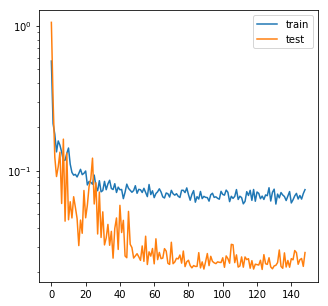

0.020865795157751096
0.027282147756585287
7.096383256594169e-07


In [19]:
train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

In [ ]:
64
0.02015599400636873
0.028048904527326536
7.295825029225693e-07

In [ ]:
128
0.01667489396067061
0.02323730737805923
6.044276296619216e-07

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/evlavrukhin/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:17<00:00, 2736099.71it/s]


Train Epoch: 1 [0/2005 (0%)]	Loss: 1.71626931
Train Epoch: 1 [256/2005 (12%)]	Loss: 1.86590498
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.83736444
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.92089517
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.51732591
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.64882290
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.44857249
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.33929421

Test set: Average loss: 0.5696670628

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.36429233

Test set: Average loss: 0.2462683857

Train Epoch: 5 [0/2005 (0%)]	Loss: 0.17898419
Train Epoch: 5 [256/2005 (12%)]	Loss: 0.11049724
Train Epoch: 5 [512/2005 (25%)]	Loss: 0.18246801
Train Epoch: 5 [768/2005 (38%)]	Loss: 0.11651648
Train Epoch: 5 [1024/2005 (50%)]	Loss: 0.21094323
Train Epoch: 5 [1280/2005 (62%)]	Loss: 0.10009173
Train Epoch: 5 [1536/2005 (75%)]	Loss: 0.20518815
Train Epoch: 5 [1792/2005 (88%)]	Loss: 0.12784480

Test set: Average loss: 0.0916078167

Train Epoch: 6 [0/2005 (0%)]	Loss: 0.13773080
Train

Train Epoch: 22 [1280/2005 (62%)]	Loss: 0.08537330
Train Epoch: 22 [1536/2005 (75%)]	Loss: 0.06423736
Train Epoch: 22 [1792/2005 (88%)]	Loss: 0.10686147

Test set: Average loss: 0.0394129854

Train Epoch: 23 [0/2005 (0%)]	Loss: 0.07077969
Train Epoch: 23 [256/2005 (12%)]	Loss: 0.12724368
Train Epoch: 23 [512/2005 (25%)]	Loss: 0.12098290
Train Epoch: 23 [768/2005 (38%)]	Loss: 0.08048163
Train Epoch: 23 [1024/2005 (50%)]	Loss: 0.07531697
Train Epoch: 23 [1280/2005 (62%)]	Loss: 0.06471142
Train Epoch: 23 [1536/2005 (75%)]	Loss: 0.15032918
Train Epoch: 23 [1792/2005 (88%)]	Loss: 0.06793215

Test set: Average loss: 0.0371713636

Train Epoch: 24 [0/2005 (0%)]	Loss: 0.14707910
Train Epoch: 24 [256/2005 (12%)]	Loss: 0.08661162
Train Epoch: 24 [512/2005 (25%)]	Loss: 0.09120725
Train Epoch: 24 [768/2005 (38%)]	Loss: 0.10765807
Train Epoch: 24 [1024/2005 (50%)]	Loss: 0.05903898
Train Epoch: 24 [1280/2005 (62%)]	Loss: 0.08529019
Train Epoch: 24 [1536/2005 (75%)]	Loss: 0.08180671
Train Epoch: 24 [1

Train Epoch: 41 [512/2005 (25%)]	Loss: 0.06911191
Train Epoch: 41 [768/2005 (38%)]	Loss: 0.05358088
Train Epoch: 41 [1024/2005 (50%)]	Loss: 0.05993243
Train Epoch: 41 [1280/2005 (62%)]	Loss: 0.04401424
Train Epoch: 41 [1536/2005 (75%)]	Loss: 0.06936237
Train Epoch: 41 [1792/2005 (88%)]	Loss: 0.06743493

Test set: Average loss: 0.0273480224

Train Epoch: 42 [0/2005 (0%)]	Loss: 0.09101610
Train Epoch: 42 [256/2005 (12%)]	Loss: 0.05715964
Train Epoch: 42 [512/2005 (25%)]	Loss: 0.07932538
Train Epoch: 42 [768/2005 (38%)]	Loss: 0.08015022
Train Epoch: 42 [1024/2005 (50%)]	Loss: 0.09054103
Train Epoch: 42 [1280/2005 (62%)]	Loss: 0.05964427
Train Epoch: 42 [1536/2005 (75%)]	Loss: 0.07351496
Train Epoch: 42 [1792/2005 (88%)]	Loss: 0.05975988

Test set: Average loss: 0.0296180182

Train Epoch: 43 [0/2005 (0%)]	Loss: 0.07756474
Train Epoch: 43 [256/2005 (12%)]	Loss: 0.06085426
Train Epoch: 43 [512/2005 (25%)]	Loss: 0.06054360
Train Epoch: 43 [768/2005 (38%)]	Loss: 0.06319786
Train Epoch: 43 [102


Test set: Average loss: 0.0272265633

Train Epoch: 60 [0/2005 (0%)]	Loss: 0.07521622
Train Epoch: 60 [256/2005 (12%)]	Loss: 0.06968549
Train Epoch: 60 [512/2005 (25%)]	Loss: 0.05553511
Train Epoch: 60 [768/2005 (38%)]	Loss: 0.07667072
Train Epoch: 60 [1024/2005 (50%)]	Loss: 0.13479334
Train Epoch: 60 [1280/2005 (62%)]	Loss: 0.06416286
Train Epoch: 60 [1536/2005 (75%)]	Loss: 0.07779052
Train Epoch: 60 [1792/2005 (88%)]	Loss: 0.04556827

Test set: Average loss: 0.0240498423

Train Epoch: 61 [0/2005 (0%)]	Loss: 0.10549401
Train Epoch: 61 [256/2005 (12%)]	Loss: 0.06932361
Train Epoch: 61 [512/2005 (25%)]	Loss: 0.07314645
Train Epoch: 61 [768/2005 (38%)]	Loss: 0.04884442
Train Epoch: 61 [1024/2005 (50%)]	Loss: 0.06523740
Train Epoch: 61 [1280/2005 (62%)]	Loss: 0.05986025
Train Epoch: 61 [1536/2005 (75%)]	Loss: 0.04945972
Train Epoch: 61 [1792/2005 (88%)]	Loss: 0.04120445

Test set: Average loss: 0.0261802268

Train Epoch: 62 [0/2005 (0%)]	Loss: 0.07321130
Train Epoch: 62 [256/2005 (12%)]	L

Train Epoch: 78 [1280/2005 (62%)]	Loss: 0.09373397
Train Epoch: 78 [1536/2005 (75%)]	Loss: 0.07005380
Train Epoch: 78 [1792/2005 (88%)]	Loss: 0.05706565

Test set: Average loss: 0.0215377058

Train Epoch: 79 [0/2005 (0%)]	Loss: 0.07365180
Train Epoch: 79 [256/2005 (12%)]	Loss: 0.10767662
Train Epoch: 79 [512/2005 (25%)]	Loss: 0.06383029
Train Epoch: 79 [768/2005 (38%)]	Loss: 0.05330622
Train Epoch: 79 [1024/2005 (50%)]	Loss: 0.09718075
Train Epoch: 79 [1280/2005 (62%)]	Loss: 0.07344713
Train Epoch: 79 [1536/2005 (75%)]	Loss: 0.06084143
Train Epoch: 79 [1792/2005 (88%)]	Loss: 0.05742858

Test set: Average loss: 0.0218053121

Train Epoch: 80 [0/2005 (0%)]	Loss: 0.06649848
Train Epoch: 80 [256/2005 (12%)]	Loss: 0.07323730
Train Epoch: 80 [512/2005 (25%)]	Loss: 0.07871519
Train Epoch: 80 [768/2005 (38%)]	Loss: 0.06489836
Train Epoch: 80 [1024/2005 (50%)]	Loss: 0.05954488
Train Epoch: 80 [1280/2005 (62%)]	Loss: 0.04510245
Train Epoch: 80 [1536/2005 (75%)]	Loss: 0.07309929
Train Epoch: 80 [1

Train Epoch: 97 [512/2005 (25%)]	Loss: 0.07593538
Train Epoch: 97 [768/2005 (38%)]	Loss: 0.08131424
Train Epoch: 97 [1024/2005 (50%)]	Loss: 0.05872757
Train Epoch: 97 [1280/2005 (62%)]	Loss: 0.04714683
Train Epoch: 97 [1536/2005 (75%)]	Loss: 0.04865210
Train Epoch: 97 [1792/2005 (88%)]	Loss: 0.08803367

Test set: Average loss: 0.0283695000

Train Epoch: 98 [0/2005 (0%)]	Loss: 0.05242090
Train Epoch: 98 [256/2005 (12%)]	Loss: 0.08375417
Train Epoch: 98 [512/2005 (25%)]	Loss: 0.04786412
Train Epoch: 98 [768/2005 (38%)]	Loss: 0.02667594
Train Epoch: 98 [1024/2005 (50%)]	Loss: 0.03214983
Train Epoch: 98 [1280/2005 (62%)]	Loss: 0.06665322
Train Epoch: 98 [1536/2005 (75%)]	Loss: 0.05251665
Train Epoch: 98 [1792/2005 (88%)]	Loss: 0.07242487

Test set: Average loss: 0.0218381729

Train Epoch: 99 [0/2005 (0%)]	Loss: 0.05579932
Train Epoch: 99 [256/2005 (12%)]	Loss: 0.06578495
Train Epoch: 99 [512/2005 (25%)]	Loss: 0.05284201
Train Epoch: 99 [768/2005 (38%)]	Loss: 0.05151809
Train Epoch: 99 [102


Test set: Average loss: 0.0240310423

Train Epoch: 119 [0/2005 (0%)]	Loss: 0.05077757
Train Epoch: 119 [256/2005 (12%)]	Loss: 0.07342691
Train Epoch: 119 [512/2005 (25%)]	Loss: 0.04709040
Train Epoch: 119 [768/2005 (38%)]	Loss: 0.13295783
Train Epoch: 119 [1024/2005 (50%)]	Loss: 0.03607528
Train Epoch: 119 [1280/2005 (62%)]	Loss: 0.04634004
Train Epoch: 119 [1536/2005 (75%)]	Loss: 0.05375294
Train Epoch: 119 [1792/2005 (88%)]	Loss: 0.07919000

Test set: Average loss: 0.0257366180

Train Epoch: 120 [0/2005 (0%)]	Loss: 0.06360026
Train Epoch: 120 [256/2005 (12%)]	Loss: 0.06302736
Train Epoch: 120 [512/2005 (25%)]	Loss: 0.05797558
Train Epoch: 120 [768/2005 (38%)]	Loss: 0.09857565
Train Epoch: 120 [1024/2005 (50%)]	Loss: 0.03388402
Train Epoch: 120 [1280/2005 (62%)]	Loss: 0.06597384
Train Epoch: 120 [1536/2005 (75%)]	Loss: 0.09275582
Train Epoch: 120 [1792/2005 (88%)]	Loss: 0.07907661

Test set: Average loss: 0.0223072029

Train Epoch: 121 [0/2005 (0%)]	Loss: 0.04276014
Train Epoch: 121 

Train Epoch: 137 [512/2005 (25%)]	Loss: 0.07158693
Train Epoch: 137 [768/2005 (38%)]	Loss: 0.05274214
Train Epoch: 137 [1024/2005 (50%)]	Loss: 0.05756439
Train Epoch: 137 [1280/2005 (62%)]	Loss: 0.06114012
Train Epoch: 137 [1536/2005 (75%)]	Loss: 0.08483354
Train Epoch: 137 [1792/2005 (88%)]	Loss: 0.05240240

Test set: Average loss: 0.0246405045

Train Epoch: 138 [0/2005 (0%)]	Loss: 0.04544853
Train Epoch: 138 [256/2005 (12%)]	Loss: 0.04509418
Train Epoch: 138 [512/2005 (25%)]	Loss: 0.08449565
Train Epoch: 138 [768/2005 (38%)]	Loss: 0.06496902
Train Epoch: 138 [1024/2005 (50%)]	Loss: 0.08667919
Train Epoch: 138 [1280/2005 (62%)]	Loss: 0.07765244
Train Epoch: 138 [1536/2005 (75%)]	Loss: 0.06529681
Train Epoch: 138 [1792/2005 (88%)]	Loss: 0.07233896

Test set: Average loss: 0.0216865988

Train Epoch: 139 [0/2005 (0%)]	Loss: 0.05568571
Train Epoch: 139 [256/2005 (12%)]	Loss: 0.07075828
Train Epoch: 139 [512/2005 (25%)]	Loss: 0.05883832
Train Epoch: 139 [768/2005 (38%)]	Loss: 0.08511375
Tr

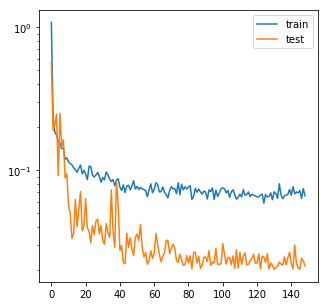

0.020148540678386766
0.021342393265016805
5.551388533366325e-07


In [11]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True)
test_aug = pad_img(h, w)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet18, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.53224885
Train Epoch: 1 [256/2005 (12%)]	Loss: 1.66037964
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.86748195
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.84835533
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.46772149
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.46965421
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.40213843
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.44689679

Test set: Average loss: 1.0687670132

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.39581572
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.36343797
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.26025927
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.31065519
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.20723442
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.24792640
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.14719844
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.16434856

Test set: Average loss: 0.2484311992

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.21115621
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.34764836
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.1

Train Epoch: 21 [256/2005 (12%)]	Loss: 0.06273605
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.11021042
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.10866903
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.08460946
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.07157878
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.08964697
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.08028909

Test set: Average loss: 0.0435655850

Train Epoch: 22 [0/2005 (0%)]	Loss: 0.10112506
Train Epoch: 22 [256/2005 (12%)]	Loss: 0.10255969
Train Epoch: 22 [512/2005 (25%)]	Loss: 0.11048617
Train Epoch: 22 [768/2005 (38%)]	Loss: 0.06462786
Train Epoch: 22 [1024/2005 (50%)]	Loss: 0.24937002
Train Epoch: 22 [1280/2005 (62%)]	Loss: 0.14925047
Train Epoch: 22 [1536/2005 (75%)]	Loss: 0.12568613
Train Epoch: 22 [1792/2005 (88%)]	Loss: 0.08947907

Test set: Average loss: 0.0552789677

Train Epoch: 23 [0/2005 (0%)]	Loss: 0.07270754
Train Epoch: 23 [256/2005 (12%)]	Loss: 0.08955535
Train Epoch: 23 [512/2005 (25%)]	Loss: 0.05575157
Train Epoch: 23 [768

Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.04969528

Test set: Average loss: 0.0403316787

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.06205585
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.14979029
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.06234334
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.12766528
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.05733253
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.09669674
Train Epoch: 40 [1536/2005 (75%)]	Loss: 0.08419495
Train Epoch: 40 [1792/2005 (88%)]	Loss: 0.05251151

Test set: Average loss: 0.0311605554

Train Epoch: 41 [0/2005 (0%)]	Loss: 0.04830971
Train Epoch: 41 [256/2005 (12%)]	Loss: 0.06750647
Train Epoch: 41 [512/2005 (25%)]	Loss: 0.05412237
Train Epoch: 41 [768/2005 (38%)]	Loss: 0.03899377
Train Epoch: 41 [1024/2005 (50%)]	Loss: 0.04985467
Train Epoch: 41 [1280/2005 (62%)]	Loss: 0.06987175
Train Epoch: 41 [1536/2005 (75%)]	Loss: 0.12106696
Train Epoch: 41 [1792/2005 (88%)]	Loss: 0.07112188

Test set: Average loss: 0.0274722777

Train Epoch: 42 [0/2005 (0%)]	

Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.05987836
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.04577475
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.08685189
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.08499827

Test set: Average loss: 0.0304941445

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.05729171
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.08411558
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.06367171
Train Epoch: 59 [768/2005 (38%)]	Loss: 0.07711037
Train Epoch: 59 [1024/2005 (50%)]	Loss: 0.04684594
Train Epoch: 59 [1280/2005 (62%)]	Loss: 0.14805466
Train Epoch: 59 [1536/2005 (75%)]	Loss: 0.08016407
Train Epoch: 59 [1792/2005 (88%)]	Loss: 0.10703856

Test set: Average loss: 0.0225521521

Train Epoch: 60 [0/2005 (0%)]	Loss: 0.05258351
Train Epoch: 60 [256/2005 (12%)]	Loss: 0.04746861
Train Epoch: 60 [512/2005 (25%)]	Loss: 0.05527966
Train Epoch: 60 [768/2005 (38%)]	Loss: 0.21662567
Train Epoch: 60 [1024/2005 (50%)]	Loss: 0.07647895
Train Epoch: 60 [1280/2005 (62%)]	Loss: 0.08468148
Train Epoch: 60 [1

Train Epoch: 77 [256/2005 (12%)]	Loss: 0.06026953
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.04398124
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.09029533
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.12023891
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.05967595
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.07640820
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.07871153

Test set: Average loss: 0.0195277836

Train Epoch: 78 [0/2005 (0%)]	Loss: 0.06103644
Train Epoch: 78 [256/2005 (12%)]	Loss: 0.04485303
Train Epoch: 78 [512/2005 (25%)]	Loss: 0.05998847
Train Epoch: 78 [768/2005 (38%)]	Loss: 0.05093477
Train Epoch: 78 [1024/2005 (50%)]	Loss: 0.05994830
Train Epoch: 78 [1280/2005 (62%)]	Loss: 0.08171659
Train Epoch: 78 [1536/2005 (75%)]	Loss: 0.07288594
Train Epoch: 78 [1792/2005 (88%)]	Loss: 0.05431847

Test set: Average loss: 0.0197903191

Train Epoch: 79 [0/2005 (0%)]	Loss: 0.05923738
Train Epoch: 79 [256/2005 (12%)]	Loss: 0.04113665
Train Epoch: 79 [512/2005 (25%)]	Loss: 0.08043757
Train Epoch: 79 [768

Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.04806612

Test set: Average loss: 0.0190345072

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.05908276
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.05516950
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.08337634
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.05482227
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.08037511
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.04768855
Train Epoch: 96 [1536/2005 (75%)]	Loss: 0.04096340
Train Epoch: 96 [1792/2005 (88%)]	Loss: 0.10395678

Test set: Average loss: 0.0201980829

Train Epoch: 97 [0/2005 (0%)]	Loss: 0.03742805
Train Epoch: 97 [256/2005 (12%)]	Loss: 0.04411151
Train Epoch: 97 [512/2005 (25%)]	Loss: 0.06146515
Train Epoch: 97 [768/2005 (38%)]	Loss: 0.06779812
Train Epoch: 97 [1024/2005 (50%)]	Loss: 0.04841321
Train Epoch: 97 [1280/2005 (62%)]	Loss: 0.08855147
Train Epoch: 97 [1536/2005 (75%)]	Loss: 0.04208442
Train Epoch: 97 [1792/2005 (88%)]	Loss: 0.07754295

Test set: Average loss: 0.0256027619

Train Epoch: 98 [0/2005 (0%)]	

Train Epoch: 114 [512/2005 (25%)]	Loss: 0.04774824
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.04807190
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.05162716
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.03831198
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.09101382
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.11342570

Test set: Average loss: 0.0177459589

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.05948892
Train Epoch: 115 [256/2005 (12%)]	Loss: 0.05631571
Train Epoch: 115 [512/2005 (25%)]	Loss: 0.04879427
Train Epoch: 115 [768/2005 (38%)]	Loss: 0.05572521
Train Epoch: 115 [1024/2005 (50%)]	Loss: 0.05861870
Train Epoch: 115 [1280/2005 (62%)]	Loss: 0.08229686
Train Epoch: 115 [1536/2005 (75%)]	Loss: 0.08037299
Train Epoch: 115 [1792/2005 (88%)]	Loss: 0.06230772

Test set: Average loss: 0.0257768692

Train Epoch: 116 [0/2005 (0%)]	Loss: 0.06677598
Train Epoch: 116 [256/2005 (12%)]	Loss: 0.05272861
Train Epoch: 116 [512/2005 (25%)]	Loss: 0.07251392
Train Epoch: 116 [768/2005 (38%)]	Loss: 0.04727029
Tr

Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.04117724
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05684081
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.05349385

Test set: Average loss: 0.0198762708

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.04880145
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.04233445
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.05455918
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.07170893
Train Epoch: 133 [1024/2005 (50%)]	Loss: 0.08493575
Train Epoch: 133 [1280/2005 (62%)]	Loss: 0.04568065
Train Epoch: 133 [1536/2005 (75%)]	Loss: 0.06524182
Train Epoch: 133 [1792/2005 (88%)]	Loss: 0.11076191

Test set: Average loss: 0.0206294505

Train Epoch: 134 [0/2005 (0%)]	Loss: 0.04651499
Train Epoch: 134 [256/2005 (12%)]	Loss: 0.09008499
Train Epoch: 134 [512/2005 (25%)]	Loss: 0.06230989
Train Epoch: 134 [768/2005 (38%)]	Loss: 0.10318394
Train Epoch: 134 [1024/2005 (50%)]	Loss: 0.05355165
Train Epoch: 134 [1280/2005 (62%)]	Loss: 0.07085573
Train Epoch: 134 [1536/2005 (75%)]	Loss: 0.04614657


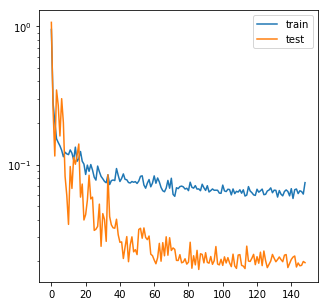

0.017484439955854594
0.019577613098206874
5.092350024409619e-07


In [15]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True)
test_aug = pad_img(h, w)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet50, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/evlavrukhin/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:51<00:00, 3503292.47it/s]


Train Epoch: 1 [0/2005 (0%)]	Loss: 1.12582785
Train Epoch: 1 [256/2005 (12%)]	Loss: 2.55938790
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.88493655
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.68607366
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.74489179
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.51678317
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.57859786
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.33343730

Test set: Average loss: 0.5938073744

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.24627665
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.35795319
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.25544409
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.29401732
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.29006782
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.20580580
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.17551658
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.13911910

Test set: Average loss: 0.1633386791

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.18145495
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.22659108
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.1

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.09760038

Test set: Average loss: 0.0893523252

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.20345423
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.10970798
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.08675952
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.08665993
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.07084662
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.13395724
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.12072188
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.08730795

Test set: Average loss: 0.0598871106

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.07494533
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.14147820
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.08697809
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.07309758
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.10809647
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.09290984
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.10615082
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.08315913

Test set: Average loss: 0.0593969005

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.15137147
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.10620118
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.06755445
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.05773420

Test set: Average loss: 0.0258916677

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.08864637
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.04385914
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.08648859
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.11337464
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.05215201
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.13583398
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.06206599
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.08521348

Test set: Average loss: 0.0477177219

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.11149519
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.09608059
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.07841771
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.04072832
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.07361325
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.09348900
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.07817040
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.06202501
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.03952487
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.04086265
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.06558262
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.04021419
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.08130361

Test set: Average loss: 0.0249210925

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.05522361
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.09595497
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.06849214
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.07712245
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.05708457
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.06829595
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.06323647
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.07805000

Test set: Average loss: 0.0229482907

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.07387552
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.13923878
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.07696296
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.11889744

Test set: Average loss: 0.0205979895

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.07010467
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.04581758
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.12243806
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.04548314
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.05178968
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.11397534
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.06383347
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.05822702

Test set: Average loss: 0.0339359547

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.07535524
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.06512700
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.06030163
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.06079565
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.08136159
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.10663110
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.06390943
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.06385577

Test set: Average loss: 0.0210709747

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.06467632
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.05668317
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.05494046
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.04544126

Test set: Average loss: 0.0231248005

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.07975030
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.08356624
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.09559288
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.03576439
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.08730251
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.05368428
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.07171276
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.06079328

Test set: Average loss: 0.0257062492

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.05209796
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.05710376
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.07308151
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.05584364
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.06334143
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.07166418
Train Epoch: 96 [1


Test set: Average loss: 0.0238107863

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.06113665
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.09041678
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.08943108
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.09897469
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.08959599
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.04585690
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.07925216
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.07777072

Test set: Average loss: 0.0287775075

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.05191872
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.07764879
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.04900158
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.05771008
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.05851075
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.07097176
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.04950578
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.07326132

Test set: Average loss: 0.0199131852

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.05214920
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.07864172
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.07428473
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.11179339
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.06976323
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.06039861
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.07191612

Test set: Average loss: 0.0245900841

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.06508841
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.05871986
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.06449957
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.07623839
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.07076253
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.06410356
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05495564
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.10644552

Test set: Average loss: 0.0266931762

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.05069677
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.05771590
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.08581146
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.15567535
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.06640556
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.08566521
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.08614989

Test set: Average loss: 0.0208547533



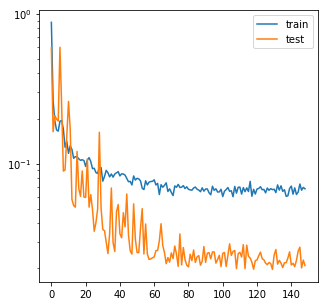

0.019652423453394952
0.02085475332757482
5.424548083773254e-07


In [16]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True)
test_aug = pad_img(h, w)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet101, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 0.82946764
Train Epoch: 1 [256/2005 (12%)]	Loss: 2.91181028
Train Epoch: 1 [512/2005 (25%)]	Loss: 1.63906109
Train Epoch: 1 [768/2005 (38%)]	Loss: 1.23943670
Train Epoch: 1 [1024/2005 (50%)]	Loss: 1.06290412
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.85916962
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.49196885
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.90095444

Test set: Average loss: 2.4046474266

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.65882054
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.47363860
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.48506816
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.53490042
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.37932899
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.37332901
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.23237238
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.22091534

Test set: Average loss: 2.1270373631

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.24696338
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.24206293
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.2

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.17114166

Test set: Average loss: 0.0756348079

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.10285717
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.13187865
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.14001332
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.15408272
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.10319211
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.08499626
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.14588403
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.12444639

Test set: Average loss: 0.0628867621

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.17629554
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.11839860
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.10850810
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.16144908
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.13413524
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.11832092
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.08631063
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.06907749

Test set: Average loss: 0.1339017757

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.21535826
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.07541944
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.08140862
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.10662459

Test set: Average loss: 0.0348019696

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.07665278
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.12815526
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.05610872
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.12836197
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.09604428
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.11238872
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.06922800
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.10960387

Test set: Average loss: 0.0383380685

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.07771187
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.07473237
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.18523874
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.06820908
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.04942508
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.07622239
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.07971125
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.05991442
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.11522011
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.05880071
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.09157140
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.08229942
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.09713053

Test set: Average loss: 0.0317834270

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.08474220
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.07652949
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.10538239
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.08855911
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.06727341
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.07259575
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.07174679
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.17973970

Test set: Average loss: 0.0334902903

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.08981584
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.11107591
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.07149258
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.10232728

Test set: Average loss: 0.0285801475

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.05705840
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.07029692
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.08393939
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.04632492
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.12565886
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.03476455
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.09140182
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.07084869

Test set: Average loss: 0.0282544429

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.10644901
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.11365088
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.16549449
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.09125189
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.05758308
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.10697941
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.07388090
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.05883009

Test set: Average loss: 0.0289983745

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.07245941
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.06124526
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.11645962
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.09972764

Test set: Average loss: 0.0297737961

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.13304232
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.07148947
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.05278093
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.09638749
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.05288179
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.07542165
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.08853149
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.09446629
Train Epoch: 97 [1024/2005 (50%)]	Loss: 0.11533398
Train Epoch: 97 [1280/2005 (62%)]	Loss: 0.03979143
Train Epoch: 97 [1536/2005 (75%)]	Loss: 0.07344543
Train Epoch: 97 [1792/2005 (88%)]	Loss: 0.06700765

Test set: Average loss: 0.0286208989

Train Epoch: 98 [0/2005 (0%)]	Loss: 0.04878196
Train Epoch: 98 [256/2005 (12%)]	Loss: 0.06764064
Train Epoch: 98 

Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.08139366
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.07516896
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.06114737
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.07291111

Test set: Average loss: 0.0278241721

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.06296284
Train Epoch: 115 [256/2005 (12%)]	Loss: 0.06028420
Train Epoch: 115 [512/2005 (25%)]	Loss: 0.05510201
Train Epoch: 115 [768/2005 (38%)]	Loss: 0.08803278
Train Epoch: 115 [1024/2005 (50%)]	Loss: 0.05476143
Train Epoch: 115 [1280/2005 (62%)]	Loss: 0.05105748
Train Epoch: 115 [1536/2005 (75%)]	Loss: 0.08095409
Train Epoch: 115 [1792/2005 (88%)]	Loss: 0.06113185

Test set: Average loss: 0.0278033150

Train Epoch: 116 [0/2005 (0%)]	Loss: 0.15240650
Train Epoch: 116 [256/2005 (12%)]	Loss: 0.15279200
Train Epoch: 116 [512/2005 (25%)]	Loss: 0.05217938
Train Epoch: 116 [768/2005 (38%)]	Loss: 0.08069297
Train Epoch: 116 [1024/2005 (50%)]	Loss: 0.05257027
Train Epoch: 116 [1280/2005 (62%)]	Loss: 0.03703810


Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.05103608

Test set: Average loss: 0.0265327938

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.07423080
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.07201064
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.07666653
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.20903900
Train Epoch: 133 [1024/2005 (50%)]	Loss: 0.06792896
Train Epoch: 133 [1280/2005 (62%)]	Loss: 0.07576867
Train Epoch: 133 [1536/2005 (75%)]	Loss: 0.06981389
Train Epoch: 133 [1792/2005 (88%)]	Loss: 0.08979250

Test set: Average loss: 0.0280658711

Train Epoch: 134 [0/2005 (0%)]	Loss: 0.07215477
Train Epoch: 134 [256/2005 (12%)]	Loss: 0.05814139
Train Epoch: 134 [512/2005 (25%)]	Loss: 0.14349300
Train Epoch: 134 [768/2005 (38%)]	Loss: 0.06914696
Train Epoch: 134 [1024/2005 (50%)]	Loss: 0.04017024
Train Epoch: 134 [1280/2005 (62%)]	Loss: 0.04686576
Train Epoch: 134 [1536/2005 (75%)]	Loss: 0.06138939
Train Epoch: 134 [1792/2005 (88%)]	Loss: 0.09086304

Test set: Average loss: 0.0303139619

Train Epoch: 

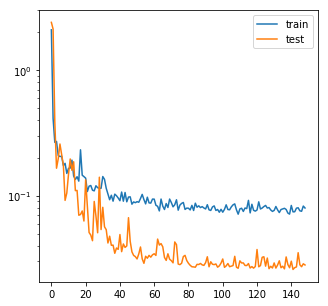

0.025874008575303347
0.028084755178104197
7.305150173279099e-07


In [17]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True)
test_aug = pad_img(h, w)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet50, pretrained=False).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.44533689
Train Epoch: 1 [256/2005 (12%)]	Loss: 1.84833318
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.95915322
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.78908141
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.71172447
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.40793656
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.38837225
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.33725879

Test set: Average loss: 0.5553849784

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.31937807
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.35864080
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.19113949
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.21811323
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.21360681
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.18698768
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.21792278
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.16160357

Test set: Average loss: 0.8956305429

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.14138502
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.08365179
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.1

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.03230108

Test set: Average loss: 0.0385301606

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.03052297
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.06651525
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.04747933
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.06216415
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.03637870
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.04858615
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.05288001
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.03035675

Test set: Average loss: 0.1287440050

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.04591565
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.13620193
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.06494485
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.10820845
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.02453082
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.05068500
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.10458536
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.04339076

Test set: Average loss: 0.0600766452

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.06611108
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.01837305
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.01765869
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.02355442

Test set: Average loss: 0.0246614370

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.03901802
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.02105914
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.03191118
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.03139074
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.01591064
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.02478485
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.02205792
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.05031579

Test set: Average loss: 0.0232262821

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.04156192
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.05785554
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.06033685
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.04890786
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.07565502
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.02191385
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.02080224
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.05472272
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.02105320
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.02176617
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.03051018
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.01932652
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.03209601

Test set: Average loss: 0.0228147673

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06379492
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.10259012
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.02285009
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.04606704
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.04830444
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.01565066
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.02291282
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.01995809

Test set: Average loss: 0.0268097460

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.02178013
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.05649754
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.03590753
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.02544390

Test set: Average loss: 0.0251659019

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.01757732
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.02023856
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.02047679
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.02283140
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.02017300
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.01373745
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.09398799
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.02196452

Test set: Average loss: 0.0256745977

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.04633846
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.08012900
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.04132592
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.16698964
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.02404872
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.01580371
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.03226715
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.01710728

Test set: Average loss: 0.0191570580

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.03743442
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.01372964
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.02275867
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.03171351

Test set: Average loss: 0.0188546825

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.01827098
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.03620060
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.01255699
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.02157643
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.02887610
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.02292004
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.03063857
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.02610705

Test set: Average loss: 0.0190495583

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.11383278
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.03596253
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.01964863
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.05372400
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.02171705
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.02536544
Train Epoch: 96 [1


Test set: Average loss: 0.0181572971

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.02913195
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.03856702
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.02113047
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.02448586
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.01654207
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.01984667
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.02636182
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.02356985

Test set: Average loss: 0.0224206972

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.02630768
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.02374969
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.01416235
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.01899525
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.01781205
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.05587031
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.03015918
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.01545596

Test set: Average loss: 0.0187050578

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.02362313
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.01083290
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.01155859
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.04053407
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.01748217
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.03720704
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.02146938

Test set: Average loss: 0.0242723926

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.02345782
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.01684963
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.02565274
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.03963937
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.04081316
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.02072958
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.01672270
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.02372953

Test set: Average loss: 0.0197131944

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.02024484
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.06307781
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.02688723
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.01923986
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.01393685
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.01291458
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.01754180

Test set: Average loss: 0.0174835670



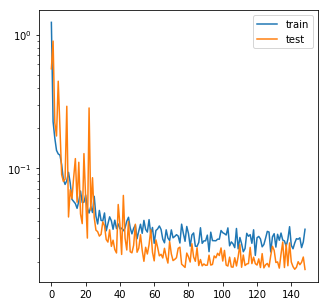

0.01748356695002662
0.01748356695002662
4.5476658537546524e-07


In [15]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=1)
test_aug = pad_img(h, w, fixed_size=True, interpolation=1)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.27388793
Train Epoch: 1 [512/2005 (25%)]	Loss: 9.07783772
Train Epoch: 1 [1024/2005 (50%)]	Loss: 1.15746525
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.72602155

Test set: Average loss: 10.5321375304

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.79920984
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.54144200
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.46346900
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.43989813

Test set: Average loss: 0.5448988774

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.36830819
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.36242372
Train Epoch: 3 [1024/2005 (50%)]	Loss: 0.26706123
Train Epoch: 3 [1536/2005 (75%)]	Loss: 0.24758109

Test set: Average loss: 1.0154900818

Train Epoch: 4 [0/2005 (0%)]	Loss: 0.21195323
Train Epoch: 4 [512/2005 (25%)]	Loss: 0.20854843
Train Epoch: 4 [1024/2005 (50%)]	Loss: 0.18442219
Train Epoch: 4 [1536/2005 (75%)]	Loss: 0.20473241

Test set: Average loss: 0.4967297681

Train Epoch: 5 [0/2005 (0%)]	Loss: 0.15101164
Train Epoch: 5 [5

Train Epoch: 35 [1536/2005 (75%)]	Loss: 0.04977097

Test set: Average loss: 0.0418805961

Train Epoch: 36 [0/2005 (0%)]	Loss: 0.03389518
Train Epoch: 36 [512/2005 (25%)]	Loss: 0.02211100
Train Epoch: 36 [1024/2005 (50%)]	Loss: 0.03083185
Train Epoch: 36 [1536/2005 (75%)]	Loss: 0.05274701

Test set: Average loss: 0.0417932102

Train Epoch: 37 [0/2005 (0%)]	Loss: 0.06966690
Train Epoch: 37 [512/2005 (25%)]	Loss: 0.03230693
Train Epoch: 37 [1024/2005 (50%)]	Loss: 0.02654101
Train Epoch: 37 [1536/2005 (75%)]	Loss: 0.04124225

Test set: Average loss: 0.0536582714

Train Epoch: 38 [0/2005 (0%)]	Loss: 0.02959668
Train Epoch: 38 [512/2005 (25%)]	Loss: 0.07567281
Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.03964146
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.03406005

Test set: Average loss: 0.0395809285

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.04297743
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.02855421
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.04514108
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.022119

Train Epoch: 70 [512/2005 (25%)]	Loss: 0.05594050
Train Epoch: 70 [1024/2005 (50%)]	Loss: 0.02670494
Train Epoch: 70 [1536/2005 (75%)]	Loss: 0.02019478

Test set: Average loss: 0.0298244986

Train Epoch: 71 [0/2005 (0%)]	Loss: 0.01885197
Train Epoch: 71 [512/2005 (25%)]	Loss: 0.02852816
Train Epoch: 71 [1024/2005 (50%)]	Loss: 0.03529299
Train Epoch: 71 [1536/2005 (75%)]	Loss: 0.02207979

Test set: Average loss: 0.0338150684

Train Epoch: 72 [0/2005 (0%)]	Loss: 0.01990617
Train Epoch: 72 [512/2005 (25%)]	Loss: 0.01994519
Train Epoch: 72 [1024/2005 (50%)]	Loss: 0.03912833
Train Epoch: 72 [1536/2005 (75%)]	Loss: 0.02508884

Test set: Average loss: 0.0378172589

Train Epoch: 73 [0/2005 (0%)]	Loss: 0.02539813
Train Epoch: 73 [512/2005 (25%)]	Loss: 0.01725295
Train Epoch: 73 [1024/2005 (50%)]	Loss: 0.02220477
Train Epoch: 73 [1536/2005 (75%)]	Loss: 0.02317665

Test set: Average loss: 0.0301139597

Train Epoch: 74 [0/2005 (0%)]	Loss: 0.03563809
Train Epoch: 74 [512/2005 (25%)]	Loss: 0.0219036

Train Epoch: 104 [1536/2005 (75%)]	Loss: 0.02512156

Test set: Average loss: 0.0293590016

Train Epoch: 105 [0/2005 (0%)]	Loss: 0.03171648
Train Epoch: 105 [512/2005 (25%)]	Loss: 0.05847803
Train Epoch: 105 [1024/2005 (50%)]	Loss: 0.03361746
Train Epoch: 105 [1536/2005 (75%)]	Loss: 0.02449024

Test set: Average loss: 0.0322509835

Train Epoch: 106 [0/2005 (0%)]	Loss: 0.04015944
Train Epoch: 106 [512/2005 (25%)]	Loss: 0.02598944
Train Epoch: 106 [1024/2005 (50%)]	Loss: 0.02848950
Train Epoch: 106 [1536/2005 (75%)]	Loss: 0.03960499

Test set: Average loss: 0.0275916118

Train Epoch: 107 [0/2005 (0%)]	Loss: 0.01831537
Train Epoch: 107 [512/2005 (25%)]	Loss: 0.02448747
Train Epoch: 107 [1024/2005 (50%)]	Loss: 0.03309993
Train Epoch: 107 [1536/2005 (75%)]	Loss: 0.01901173

Test set: Average loss: 0.0288079612

Train Epoch: 108 [0/2005 (0%)]	Loss: 0.03151870
Train Epoch: 108 [512/2005 (25%)]	Loss: 0.02595076
Train Epoch: 108 [1024/2005 (50%)]	Loss: 0.02048229
Train Epoch: 108 [1536/2005 (75%

Train Epoch: 138 [1536/2005 (75%)]	Loss: 0.02855310

Test set: Average loss: 0.0299960173

Train Epoch: 139 [0/2005 (0%)]	Loss: 0.03623108
Train Epoch: 139 [512/2005 (25%)]	Loss: 0.03491706
Train Epoch: 139 [1024/2005 (50%)]	Loss: 0.01796352
Train Epoch: 139 [1536/2005 (75%)]	Loss: 0.01837839

Test set: Average loss: 0.0293554295

Train Epoch: 140 [0/2005 (0%)]	Loss: 0.02489430
Train Epoch: 140 [512/2005 (25%)]	Loss: 0.03577236
Train Epoch: 140 [1024/2005 (50%)]	Loss: 0.05253024
Train Epoch: 140 [1536/2005 (75%)]	Loss: 0.03138575

Test set: Average loss: 0.0309462950

Train Epoch: 141 [0/2005 (0%)]	Loss: 0.02937291
Train Epoch: 141 [512/2005 (25%)]	Loss: 0.03629256
Train Epoch: 141 [1024/2005 (50%)]	Loss: 0.02865163
Train Epoch: 141 [1536/2005 (75%)]	Loss: 0.02973253

Test set: Average loss: 0.0310379750

Train Epoch: 142 [0/2005 (0%)]	Loss: 0.03407719
Train Epoch: 142 [512/2005 (25%)]	Loss: 0.02584146
Train Epoch: 142 [1024/2005 (50%)]	Loss: 0.02137071
Train Epoch: 142 [1536/2005 (75%

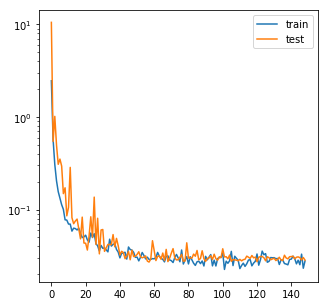

0.027071663481209908
0.02843398760823728
7.395989325385733e-07


In [16]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=1)
test_aug = pad_img(h, w, fixed_size=True, interpolation=1)

batch_size = 128
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.49117241
Train Epoch: 1 [256/2005 (12%)]	Loss: 2.24800694
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.54936668
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.42387948
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.30232606
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.23425456
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.19579655
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.19249773

Test set: Average loss: 2.5912270617

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.17992337
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.19212945
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.17587090
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.21415675
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.10797887
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.20185205
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.19116999
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.08516290

Test set: Average loss: 3.4905769198

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.12121599
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.09695381
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.0

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.04762075

Test set: Average loss: 0.0903975609

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.04431436
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.04695886
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.06721265
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.06082494
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.04201480
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.06162088
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.03740050
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.05261563

Test set: Average loss: 0.1726375945

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.04552786
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.14475339
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.06865770
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.10758068
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.04411582
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.05064581
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.14418656
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.03324987

Test set: Average loss: 0.0868141806

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.09063177
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.02980263
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.02370763
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.02922677

Test set: Average loss: 0.0612229239

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.02769125
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.03504031
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.04989566
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.02455931
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.02680723
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.02152222
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.02436039
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.06644929

Test set: Average loss: 0.0632208211

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.04389166
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.04808084
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.07009065
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.04665100
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.08013608
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.02813575
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.02550285
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.08123339
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.03641958
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.03666971
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.04487765
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.03504712
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.04419271

Test set: Average loss: 0.0385817701

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06809452
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.11894510
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.02732719
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.06118890
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.04838914
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.02735963
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.02149588
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.02845888

Test set: Average loss: 0.0427616719

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.04088216
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.04599384
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.04488446
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.03008094

Test set: Average loss: 0.0464601577

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.02846001
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.05635562
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.01988015
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.02012951
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.03217429
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.02776180
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.08553413
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.02899269

Test set: Average loss: 0.0776878836

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.04121633
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.06141440
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.04615803
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.14912014
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.04123642
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.01985386
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.03975732
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.01975431

Test set: Average loss: 0.0552809924

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.03381604
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.02699837
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.03575572
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.02255067

Test set: Average loss: 0.0437729077

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.02406669
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.03921411
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.01623625
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.03029065
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.04136120
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.01877052
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.06126784
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.01639535

Test set: Average loss: 0.0613275442

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.16304967
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.06180791
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.02252405
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.06232234
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.02798135
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.02258286
Train Epoch: 96 [1


Test set: Average loss: 0.0425957949

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.02504757
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.03710938
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.03368345
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.03331345
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.02662358
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.01745674
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.02803801
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.02957039

Test set: Average loss: 0.0637425194

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.02733094
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.03448784
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.02159805
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.02116296
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.02585643
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.07731010
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.04538161
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.02632297

Test set: Average loss: 0.0472800032

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.02609722
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.02308661
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.02147810
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.06244305
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.02258142
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.05175197
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.02146893

Test set: Average loss: 0.0626389595

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.02959151
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.02662649
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.02361184
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.03614327
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.04562980
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.02548855
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.01779968
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.03063494

Test set: Average loss: 0.0496556362

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.01754536
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.06365438
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.02848749
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.04697915
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.02457271
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.02388011
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.02921613

Test set: Average loss: 0.0408215304



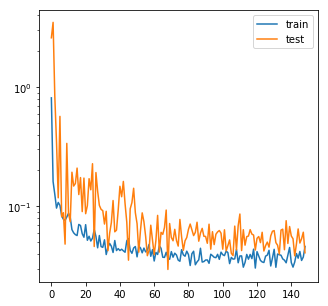

0.029589915884184463
0.04082153038695868
1.0618123885669532e-06


In [14]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=1)
test_aug = pad_img(h, w, fixed_size=True, interpolation=1)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, normalize=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, normalize=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.15804169
Train Epoch: 1 [256/2005 (12%)]	Loss: 2.18189004
Train Epoch: 1 [512/2005 (25%)]	Loss: 1.38928441
Train Epoch: 1 [768/2005 (38%)]	Loss: 1.03323372
Train Epoch: 1 [1024/2005 (50%)]	Loss: 1.04305213
Train Epoch: 1 [1280/2005 (62%)]	Loss: 1.10128329
Train Epoch: 1 [1536/2005 (75%)]	Loss: 1.16012910
Train Epoch: 1 [1792/2005 (88%)]	Loss: 1.04258475

Test set: Average loss: 1.7472802038

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.88377118
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.68157910
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.67548143
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.42428166
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.30734576
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.38619682
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.14766100
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.34024219

Test set: Average loss: 0.2130704476

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.28297227
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.44318692
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.1

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.08803175

Test set: Average loss: 0.0340833825

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.16980450
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.07964671
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.05406663
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.06334171
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.07266792
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.10563578
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.08789244
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.11160644

Test set: Average loss: 0.0491898316

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.09008662
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.17386589
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.06965463
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.14648011
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.11864973
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.13901589
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.12052178
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.12311649

Test set: Average loss: 0.1133682570

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.04091384
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.08818968
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.04463039
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.07201909

Test set: Average loss: 0.0343399253

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.04971808
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.05500521
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.05656368
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.11145936
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.08934688
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.07809614
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.10842064
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.09294173

Test set: Average loss: 0.0505046643

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.09853853
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.08694505
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.03912118
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.10249505
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.04200262
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.06552781
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.03705013
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.11232212
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.04182398
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.04482870
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.13647845
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.05556953
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.06520502

Test set: Average loss: 0.0217077551

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06976565
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.06443305
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.09928537
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.09750475
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.08316743
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.05981096
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.05727946
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.05759237

Test set: Average loss: 0.0283308611

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.06107190
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.05681602
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.05112384
Train Epoch: 59 [768

Train Epoch: 77 [512/2005 (25%)]	Loss: 0.06647552
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.04221052
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.05985326
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.06756196
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.04829528
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.05648570

Test set: Average loss: 0.0230270164

Train Epoch: 78 [0/2005 (0%)]	Loss: 0.05221626
Train Epoch: 78 [256/2005 (12%)]	Loss: 0.06011073
Train Epoch: 78 [512/2005 (25%)]	Loss: 0.05654936
Train Epoch: 78 [768/2005 (38%)]	Loss: 0.06306274
Train Epoch: 78 [1024/2005 (50%)]	Loss: 0.04046694
Train Epoch: 78 [1280/2005 (62%)]	Loss: 0.05750692
Train Epoch: 78 [1536/2005 (75%)]	Loss: 0.06783954
Train Epoch: 78 [1792/2005 (88%)]	Loss: 0.08738033

Test set: Average loss: 0.0227766573

Train Epoch: 79 [0/2005 (0%)]	Loss: 0.04905290
Train Epoch: 79 [256/2005 (12%)]	Loss: 0.06005209
Train Epoch: 79 [512/2005 (25%)]	Loss: 0.05304661
Train Epoch: 79 [768/2005 (38%)]	Loss: 0.10912292
Train Epoch: 79 [102


Test set: Average loss: 0.0234059089

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.10123089
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.05903515
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.04752598
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.05430899
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.04712932
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.07355146
Train Epoch: 96 [1536/2005 (75%)]	Loss: 0.03507760
Train Epoch: 96 [1792/2005 (88%)]	Loss: 0.09200785

Test set: Average loss: 0.0214174822

Train Epoch: 97 [0/2005 (0%)]	Loss: 0.04127105
Train Epoch: 97 [256/2005 (12%)]	Loss: 0.03389261
Train Epoch: 97 [512/2005 (25%)]	Loss: 0.07672619
Train Epoch: 97 [768/2005 (38%)]	Loss: 0.03635080
Train Epoch: 97 [1024/2005 (50%)]	Loss: 0.06187689
Train Epoch: 97 [1280/2005 (62%)]	Loss: 0.05213011
Train Epoch: 97 [1536/2005 (75%)]	Loss: 0.07476647
Train Epoch: 97 [1792/2005 (88%)]	Loss: 0.03743597

Test set: Average loss: 0.0229961938

Train Epoch: 98 [0/2005 (0%)]	Loss: 0.06164139
Train Epoch: 98 [256/2005 (12%)]	L

Train Epoch: 114 [768/2005 (38%)]	Loss: 0.05477498
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.10545922
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.06548006
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.04446270
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.05505520

Test set: Average loss: 0.0207297361

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.07288668
Train Epoch: 115 [256/2005 (12%)]	Loss: 0.06728604
Train Epoch: 115 [512/2005 (25%)]	Loss: 0.10549428
Train Epoch: 115 [768/2005 (38%)]	Loss: 0.08474889
Train Epoch: 115 [1024/2005 (50%)]	Loss: 0.07407496
Train Epoch: 115 [1280/2005 (62%)]	Loss: 0.05479083
Train Epoch: 115 [1536/2005 (75%)]	Loss: 0.04099142
Train Epoch: 115 [1792/2005 (88%)]	Loss: 0.05533436

Test set: Average loss: 0.0251829741

Train Epoch: 116 [0/2005 (0%)]	Loss: 0.05983819
Train Epoch: 116 [256/2005 (12%)]	Loss: 0.06053644
Train Epoch: 116 [512/2005 (25%)]	Loss: 0.05432860
Train Epoch: 116 [768/2005 (38%)]	Loss: 0.04865345
Train Epoch: 116 [1024/2005 (50%)]	Loss: 0.04667099
T

Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05394509
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.06014142

Test set: Average loss: 0.0218068740

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.04647186
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.07173540
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.13188100
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.05153251
Train Epoch: 133 [1024/2005 (50%)]	Loss: 0.05100748
Train Epoch: 133 [1280/2005 (62%)]	Loss: 0.07253819
Train Epoch: 133 [1536/2005 (75%)]	Loss: 0.05973145
Train Epoch: 133 [1792/2005 (88%)]	Loss: 0.05669745

Test set: Average loss: 0.0259586853

Train Epoch: 134 [0/2005 (0%)]	Loss: 0.03730665
Train Epoch: 134 [256/2005 (12%)]	Loss: 0.03679184
Train Epoch: 134 [512/2005 (25%)]	Loss: 0.05217926
Train Epoch: 134 [768/2005 (38%)]	Loss: 0.08859558
Train Epoch: 134 [1024/2005 (50%)]	Loss: 0.12382734
Train Epoch: 134 [1280/2005 (62%)]	Loss: 0.06762086
Train Epoch: 134 [1536/2005 (75%)]	Loss: 0.04922251
Train Epoch: 134 [1792/2005 (88%)]	Loss: 0.03941235


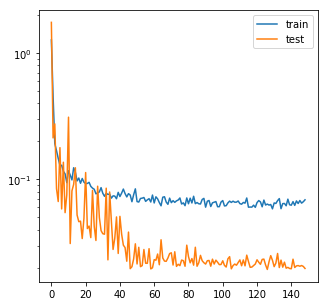

0.01941144579628514
0.01976944617478348
5.142247893332002e-07


In [25]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.33710813
Train Epoch: 1 [256/2005 (12%)]	Loss: 1.22138818
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.74630615
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.33931199
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.18101100
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.30971989
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.18549037
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.19625363

Test set: Average loss: 1.1294695552

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.18417466
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.15737913
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.13226759
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.15559902
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.22601157
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.15026134
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.12857609
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.12483260

Test set: Average loss: 1.2586220080

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.15977053
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.13166114
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.2

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.11433763

Test set: Average loss: 0.0532823826

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.06316537
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.07402429
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.05211350
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.09280288
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.05341621
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.05596460
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.05515252
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.07502464

Test set: Average loss: 0.0624781045

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.08411935
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.05537522
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.04637557
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.05372660
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.08925636
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.07278485
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.04999141
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.03771150

Test set: Average loss: 0.0350161753

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.04106802
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.03117638
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.03675562
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.03726018

Test set: Average loss: 0.0224640643

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.07213194
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.05468933
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.04477462
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.04096054
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.03359440
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.02578395
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.03226160
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.05041904

Test set: Average loss: 0.0274022087

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.05715435
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.05053347
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.02622198
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.05591298
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.04494337
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.04803477
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.08218372
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.04852179
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.06314315
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.04590821
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.02588055
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.05105092
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.06016759

Test set: Average loss: 0.0181829563

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06983111
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.07455248
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.04117787
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.03073784
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.05137995
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.04317110
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.03977606
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.06750587

Test set: Average loss: 0.0203113227

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.08365775
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.06268988
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.03695244
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.03711850

Test set: Average loss: 0.0211360503

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.04905382
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.05289931
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.05947849
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.04495785
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.03268921
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.07654187
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.05302959
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.04992466

Test set: Average loss: 0.0197432971

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.02364497
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.03769701
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.04500627
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.05893307
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.07250316
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.03195039
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.09284094
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.04959726

Test set: Average loss: 0.0189375932

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.04081220
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.03400872
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.05534756
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.04182522

Test set: Average loss: 0.0183763345

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.06092003
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.02371588
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.01988665
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.04767762
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.03823417
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.03098988
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.02972997
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.04996445

Test set: Average loss: 0.0198707232

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.04165867
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.03853721
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.05425934
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.08910779
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.05746637
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.03006238
Train Epoch: 96 [1


Test set: Average loss: 0.0189326914

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.03604989
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.03466602
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.04859061
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.03904758
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.05613898
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.04588205
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.05411582
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.08772394

Test set: Average loss: 0.0180220200

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.03371060
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.04854143
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.05002606
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.07180045
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.07096667
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.03474563
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.03321024
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.04249606

Test set: Average loss: 0.0224687558

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.04002366
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.04697140
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.05403620
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.05181261
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.02932794
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.04933144
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.02979380

Test set: Average loss: 0.0181403640

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.04402402
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.04249850
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.04639872
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.03695235
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.03569549
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.02854286
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05165658
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.03154697

Test set: Average loss: 0.0179273625

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.04069828
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.04269209
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.04038914
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.02341668
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.04181952
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.04698444
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.04400692

Test set: Average loss: 0.0168132138



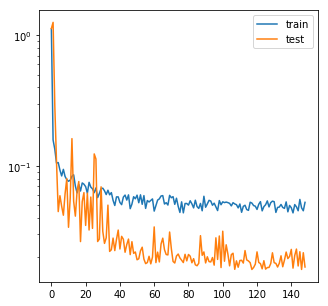

0.016105336709369106
0.016813213766828747
4.373299702391015e-07


In [34]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=False)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 2.04053547
Train Epoch: 1 [256/2005 (12%)]	Loss: 0.87500207
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.52904491
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.61938768
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.42483483
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.79155895
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.74003428
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.74120523

Test set: Average loss: 1.2464476699

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.21176812
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.23631404
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.14012507
Train Epoch: 4 [512/2005 (25%)]	Loss: 0.43690289
Train Epoch: 4 [768/2005 (38%)]	Loss: 0.15050510
Train Epoch: 4 [1024/2005 (50%)]	Loss: 0.11744549
Train Epoch: 4 [1280/2005 (62%)]	Loss: 0.18964604
Train Epoch: 4 [1536/2005 (75%)]	Loss: 0.14607324
Train Epoch: 4 [1792/2005 (88%)]	Loss: 0.16289337

Test set: Average loss: 0.1202231918

Train Epoch: 5 [0/2005 (0%)]	Loss: 0.12340870
Train Epoch: 5 [256/2005 (12%)]	Loss: 0.1

Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.05768796
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.07426512

Test set: Average loss: 0.0542279244

Train Epoch: 22 [0/2005 (0%)]	Loss: 0.06048129
Train Epoch: 22 [256/2005 (12%)]	Loss: 0.13769044
Train Epoch: 22 [512/2005 (25%)]	Loss: 0.12166790
Train Epoch: 22 [768/2005 (38%)]	Loss: 0.07682243
Train Epoch: 22 [1024/2005 (50%)]	Loss: 0.05698561
Train Epoch: 22 [1280/2005 (62%)]	Loss: 0.10344660
Train Epoch: 22 [1536/2005 (75%)]	Loss: 0.06972223
Train Epoch: 22 [1792/2005 (88%)]	Loss: 0.06141605

Test set: Average loss: 0.0577840150

Train Epoch: 23 [0/2005 (0%)]	Loss: 0.10005947
Train Epoch: 23 [256/2005 (12%)]	Loss: 0.13435290
Train Epoch: 23 [512/2005 (25%)]	Loss: 0.12540144
Train Epoch: 23 [768/2005 (38%)]	Loss: 0.08982242
Train Epoch: 23 [1024/2005 (50%)]	Loss: 0.05101156
Train Epoch: 23 [1280/2005 (62%)]	Loss: 0.06327195
Train Epoch: 23 [1536/2005 (75%)]	Loss: 0.08413238
Train Epoch: 23 [1792/2005 (88%)]	Loss: 0.05350197

Test set: Average

Train Epoch: 40 [768/2005 (38%)]	Loss: 0.05871331
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.11498709
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.10424506
Train Epoch: 40 [1536/2005 (75%)]	Loss: 0.07220886
Train Epoch: 40 [1792/2005 (88%)]	Loss: 0.05740153

Test set: Average loss: 0.0430884477

Train Epoch: 41 [0/2005 (0%)]	Loss: 0.19078809
Train Epoch: 41 [256/2005 (12%)]	Loss: 0.09353583
Train Epoch: 41 [512/2005 (25%)]	Loss: 0.03796766
Train Epoch: 41 [768/2005 (38%)]	Loss: 0.12066648
Train Epoch: 41 [1024/2005 (50%)]	Loss: 0.07015099
Train Epoch: 41 [1280/2005 (62%)]	Loss: 0.07294793
Train Epoch: 41 [1536/2005 (75%)]	Loss: 0.07264674
Train Epoch: 41 [1792/2005 (88%)]	Loss: 0.06579111

Test set: Average loss: 0.0487159096

Train Epoch: 42 [0/2005 (0%)]	Loss: 0.07830933
Train Epoch: 42 [256/2005 (12%)]	Loss: 0.09506222
Train Epoch: 42 [512/2005 (25%)]	Loss: 0.04568860
Train Epoch: 42 [768/2005 (38%)]	Loss: 0.08556664
Train Epoch: 42 [1024/2005 (50%)]	Loss: 0.08285273
Train Epoch: 42 [12

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.05874202
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.09809393
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.05321787
Train Epoch: 59 [768/2005 (38%)]	Loss: 0.07677770
Train Epoch: 59 [1024/2005 (50%)]	Loss: 0.07825235
Train Epoch: 59 [1280/2005 (62%)]	Loss: 0.05561858
Train Epoch: 59 [1536/2005 (75%)]	Loss: 0.07606870
Train Epoch: 59 [1792/2005 (88%)]	Loss: 0.07976228

Test set: Average loss: 0.0450436150

Train Epoch: 60 [0/2005 (0%)]	Loss: 0.05875264
Train Epoch: 60 [256/2005 (12%)]	Loss: 0.05958687
Train Epoch: 60 [512/2005 (25%)]	Loss: 0.05885284
Train Epoch: 60 [768/2005 (38%)]	Loss: 0.04332182
Train Epoch: 60 [1024/2005 (50%)]	Loss: 0.09273765
Train Epoch: 60 [1280/2005 (62%)]	Loss: 0.05459022
Train Epoch: 60 [1536/2005 (75%)]	Loss: 0.07095363
Train Epoch: 60 [1792/2005 (88%)]	Loss: 0.06284583

Test set: Average loss: 0.0569714004

Train Epoch: 61 [0/2005 (0%)]	Loss: 0.06289258
Train Epoch: 61 [256/2005 (12%)]	Loss: 0.07490102
Train Epoch: 61 [512/20

Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.05835696
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.05321707

Test set: Average loss: 0.0411320358

Train Epoch: 78 [0/2005 (0%)]	Loss: 0.06234021
Train Epoch: 78 [256/2005 (12%)]	Loss: 0.05504131
Train Epoch: 78 [512/2005 (25%)]	Loss: 0.05160466
Train Epoch: 78 [768/2005 (38%)]	Loss: 0.06724772
Train Epoch: 78 [1024/2005 (50%)]	Loss: 0.05258727
Train Epoch: 78 [1280/2005 (62%)]	Loss: 0.05177595
Train Epoch: 78 [1536/2005 (75%)]	Loss: 0.06479436
Train Epoch: 78 [1792/2005 (88%)]	Loss: 0.05755916

Test set: Average loss: 0.0430575932

Train Epoch: 79 [0/2005 (0%)]	Loss: 0.07002852
Train Epoch: 79 [256/2005 (12%)]	Loss: 0.08016437
Train Epoch: 79 [512/2005 (25%)]	Loss: 0.08686712
Train Epoch: 79 [768/2005 (38%)]	Loss: 0.04867491
Train Epoch: 79 [1024/2005 (50%)]	Loss: 0.06484246
Train Epoch: 79 [1280/2005 (62%)]	Loss: 0.07269617
Train Epoch: 79 [1536/2005 (75%)]	Loss: 0.04668240
Train Epoch: 79 [1792/2005 (88%)]	Loss: 0.05397803

Test set: Average

Train Epoch: 96 [768/2005 (38%)]	Loss: 0.06850488
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.07031197
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.07066958
Train Epoch: 96 [1536/2005 (75%)]	Loss: 0.12915402
Train Epoch: 96 [1792/2005 (88%)]	Loss: 0.05825484

Test set: Average loss: 0.0393550044

Train Epoch: 97 [0/2005 (0%)]	Loss: 0.07631179
Train Epoch: 97 [256/2005 (12%)]	Loss: 0.11932657
Train Epoch: 97 [512/2005 (25%)]	Loss: 0.05565479
Train Epoch: 97 [768/2005 (38%)]	Loss: 0.24059254
Train Epoch: 97 [1024/2005 (50%)]	Loss: 0.09516455
Train Epoch: 97 [1280/2005 (62%)]	Loss: 0.07969094
Train Epoch: 97 [1536/2005 (75%)]	Loss: 0.05861910
Train Epoch: 97 [1792/2005 (88%)]	Loss: 0.06421655

Test set: Average loss: 0.0520487024

Train Epoch: 98 [0/2005 (0%)]	Loss: 0.07815124
Train Epoch: 98 [256/2005 (12%)]	Loss: 0.05613130
Train Epoch: 98 [512/2005 (25%)]	Loss: 0.07922785
Train Epoch: 98 [768/2005 (38%)]	Loss: 0.04074595
Train Epoch: 98 [1024/2005 (50%)]	Loss: 0.06341456
Train Epoch: 98 [12

Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.05338949

Test set: Average loss: 0.0437336796

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.05797196
Train Epoch: 115 [256/2005 (12%)]	Loss: 0.06708627
Train Epoch: 115 [512/2005 (25%)]	Loss: 0.11150565
Train Epoch: 115 [768/2005 (38%)]	Loss: 0.06991106
Train Epoch: 115 [1024/2005 (50%)]	Loss: 0.07844827
Train Epoch: 115 [1280/2005 (62%)]	Loss: 0.05910120
Train Epoch: 115 [1536/2005 (75%)]	Loss: 0.06394579
Train Epoch: 115 [1792/2005 (88%)]	Loss: 0.17474933

Test set: Average loss: 0.0447433592

Train Epoch: 116 [0/2005 (0%)]	Loss: 0.04156321
Train Epoch: 116 [256/2005 (12%)]	Loss: 0.07016308
Train Epoch: 116 [512/2005 (25%)]	Loss: 0.06464332
Train Epoch: 116 [768/2005 (38%)]	Loss: 0.10878266
Train Epoch: 116 [1024/2005 (50%)]	Loss: 0.07162365
Train Epoch: 116 [1280/2005 (62%)]	Loss: 0.04685432
Train Epoch: 116 [1536/2005 (75%)]	Loss: 0.05007692
Train Epoch: 116 [1792/2005 (88%)]	Loss: 0.04173114

Test set: Average loss: 0.0403365273

Train Epoch: 

Train Epoch: 133 [256/2005 (12%)]	Loss: 0.10718454
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.07986471
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.10173460
Train Epoch: 133 [1024/2005 (50%)]	Loss: 0.09606637
Train Epoch: 133 [1280/2005 (62%)]	Loss: 0.06373529
Train Epoch: 133 [1536/2005 (75%)]	Loss: 0.05551446
Train Epoch: 133 [1792/2005 (88%)]	Loss: 0.08943301

Test set: Average loss: 0.0466501756

Train Epoch: 134 [0/2005 (0%)]	Loss: 0.06731926
Train Epoch: 134 [256/2005 (12%)]	Loss: 0.07403397
Train Epoch: 134 [512/2005 (25%)]	Loss: 0.04008989
Train Epoch: 134 [768/2005 (38%)]	Loss: 0.11895177
Train Epoch: 134 [1024/2005 (50%)]	Loss: 0.05996523
Train Epoch: 134 [1280/2005 (62%)]	Loss: 0.05118562
Train Epoch: 134 [1536/2005 (75%)]	Loss: 0.05529522
Train Epoch: 134 [1792/2005 (88%)]	Loss: 0.17915178

Test set: Average loss: 0.0418000452

Train Epoch: 135 [0/2005 (0%)]	Loss: 0.05869921
Train Epoch: 135 [256/2005 (12%)]	Loss: 0.04961293
Train Epoch: 135 [512/2005 (25%)]	Loss: 0.07252307
Tr

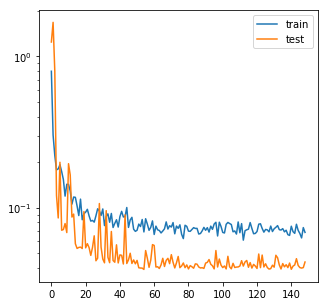

0.03902536756951662
0.04370354545127688
1.1367767338602709e-06


In [30]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=False)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.00753050
Train Epoch: 1 [256/2005 (12%)]	Loss: 22060.69288061
Train Epoch: 1 [512/2005 (25%)]	Loss: 40538.23661148
Train Epoch: 1 [768/2005 (38%)]	Loss: 2327313332153673150229041684448427528309386631501053952.00000000
Train Epoch: 1 [1024/2005 (50%)]	Loss: nan
Train Epoch: 1 [1280/2005 (62%)]	Loss: nan
Train Epoch: 1 [1536/2005 (75%)]	Loss: nan
Train Epoch: 1 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 2 [0/2005 (0%)]	Loss: nan
Train Epoch: 2 [256/2005 (12%)]	Loss: nan
Train Epoch: 2 [512/2005 (25%)]	Loss: nan
Train Epoch: 2 [768/2005 (38%)]	Loss: nan
Train Epoch: 2 [1024/2005 (50%)]	Loss: nan
Train Epoch: 2 [1280/2005 (62%)]	Loss: nan
Train Epoch: 2 [1536/2005 (75%)]	Loss: nan
Train Epoch: 2 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 3 [0/2005 (0%)]	Loss: nan
Train Epoch: 3 [256/2005 (12%)]	Loss: nan
Train Epoch: 3 [512/2005 (25%)]	Loss: nan
Train Epoch: 3 [768/2005 (38%)]	Loss: nan
Train Epoch

Train Epoch: 22 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 23 [0/2005 (0%)]	Loss: nan
Train Epoch: 23 [256/2005 (12%)]	Loss: nan
Train Epoch: 23 [512/2005 (25%)]	Loss: nan
Train Epoch: 23 [768/2005 (38%)]	Loss: nan
Train Epoch: 23 [1024/2005 (50%)]	Loss: nan
Train Epoch: 23 [1280/2005 (62%)]	Loss: nan
Train Epoch: 23 [1536/2005 (75%)]	Loss: nan
Train Epoch: 23 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 24 [0/2005 (0%)]	Loss: nan
Train Epoch: 24 [256/2005 (12%)]	Loss: nan
Train Epoch: 24 [512/2005 (25%)]	Loss: nan
Train Epoch: 24 [768/2005 (38%)]	Loss: nan
Train Epoch: 24 [1024/2005 (50%)]	Loss: nan
Train Epoch: 24 [1280/2005 (62%)]	Loss: nan
Train Epoch: 24 [1536/2005 (75%)]	Loss: nan
Train Epoch: 24 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 25 [0/2005 (0%)]	Loss: nan
Train Epoch: 25 [256/2005 (12%)]	Loss: nan
Train Epoch: 25 [512/2005 (25%)]	Loss: nan
Train Epoch: 25 [768/2005 (38%)]	Loss: nan
Train E

Train Epoch: 44 [1536/2005 (75%)]	Loss: nan
Train Epoch: 44 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 45 [0/2005 (0%)]	Loss: nan
Train Epoch: 45 [256/2005 (12%)]	Loss: nan
Train Epoch: 45 [512/2005 (25%)]	Loss: nan
Train Epoch: 45 [768/2005 (38%)]	Loss: nan
Train Epoch: 45 [1024/2005 (50%)]	Loss: nan
Train Epoch: 45 [1280/2005 (62%)]	Loss: nan
Train Epoch: 45 [1536/2005 (75%)]	Loss: nan
Train Epoch: 45 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 46 [0/2005 (0%)]	Loss: nan
Train Epoch: 46 [256/2005 (12%)]	Loss: nan
Train Epoch: 46 [512/2005 (25%)]	Loss: nan
Train Epoch: 46 [768/2005 (38%)]	Loss: nan
Train Epoch: 46 [1024/2005 (50%)]	Loss: nan
Train Epoch: 46 [1280/2005 (62%)]	Loss: nan
Train Epoch: 46 [1536/2005 (75%)]	Loss: nan
Train Epoch: 46 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 47 [0/2005 (0%)]	Loss: nan
Train Epoch: 47 [256/2005 (12%)]	Loss: nan
Train Epoch: 47 [512/2005 (25%)]	Loss: nan
Train 

Train Epoch: 66 [1280/2005 (62%)]	Loss: nan
Train Epoch: 66 [1536/2005 (75%)]	Loss: nan
Train Epoch: 66 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 67 [0/2005 (0%)]	Loss: nan
Train Epoch: 67 [256/2005 (12%)]	Loss: nan
Train Epoch: 67 [512/2005 (25%)]	Loss: nan
Train Epoch: 67 [768/2005 (38%)]	Loss: nan
Train Epoch: 67 [1024/2005 (50%)]	Loss: nan
Train Epoch: 67 [1280/2005 (62%)]	Loss: nan
Train Epoch: 67 [1536/2005 (75%)]	Loss: nan
Train Epoch: 67 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 68 [0/2005 (0%)]	Loss: nan
Train Epoch: 68 [256/2005 (12%)]	Loss: nan
Train Epoch: 68 [512/2005 (25%)]	Loss: nan
Train Epoch: 68 [768/2005 (38%)]	Loss: nan
Train Epoch: 68 [1024/2005 (50%)]	Loss: nan
Train Epoch: 68 [1280/2005 (62%)]	Loss: nan
Train Epoch: 68 [1536/2005 (75%)]	Loss: nan
Train Epoch: 68 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 69 [0/2005 (0%)]	Loss: nan
Train Epoch: 69 [256/2005 (12%)]	Loss: nan
Train

Train Epoch: 88 [1024/2005 (50%)]	Loss: nan
Train Epoch: 88 [1280/2005 (62%)]	Loss: nan
Train Epoch: 88 [1536/2005 (75%)]	Loss: nan
Train Epoch: 88 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 89 [0/2005 (0%)]	Loss: nan
Train Epoch: 89 [256/2005 (12%)]	Loss: nan
Train Epoch: 89 [512/2005 (25%)]	Loss: nan
Train Epoch: 89 [768/2005 (38%)]	Loss: nan
Train Epoch: 89 [1024/2005 (50%)]	Loss: nan
Train Epoch: 89 [1280/2005 (62%)]	Loss: nan
Train Epoch: 89 [1536/2005 (75%)]	Loss: nan
Train Epoch: 89 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 90 [0/2005 (0%)]	Loss: nan
Train Epoch: 90 [256/2005 (12%)]	Loss: nan
Train Epoch: 90 [512/2005 (25%)]	Loss: nan
Train Epoch: 90 [768/2005 (38%)]	Loss: nan
Train Epoch: 90 [1024/2005 (50%)]	Loss: nan
Train Epoch: 90 [1280/2005 (62%)]	Loss: nan
Train Epoch: 90 [1536/2005 (75%)]	Loss: nan
Train Epoch: 90 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 91 [0/2005 (0%)]	Loss: nan
Trai

Train Epoch: 110 [256/2005 (12%)]	Loss: nan
Train Epoch: 110 [512/2005 (25%)]	Loss: nan
Train Epoch: 110 [768/2005 (38%)]	Loss: nan
Train Epoch: 110 [1024/2005 (50%)]	Loss: nan
Train Epoch: 110 [1280/2005 (62%)]	Loss: nan
Train Epoch: 110 [1536/2005 (75%)]	Loss: nan
Train Epoch: 110 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 111 [0/2005 (0%)]	Loss: nan
Train Epoch: 111 [256/2005 (12%)]	Loss: nan
Train Epoch: 111 [512/2005 (25%)]	Loss: nan
Train Epoch: 111 [768/2005 (38%)]	Loss: nan
Train Epoch: 111 [1024/2005 (50%)]	Loss: nan
Train Epoch: 111 [1280/2005 (62%)]	Loss: nan
Train Epoch: 111 [1536/2005 (75%)]	Loss: nan
Train Epoch: 111 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 112 [0/2005 (0%)]	Loss: nan
Train Epoch: 112 [256/2005 (12%)]	Loss: nan
Train Epoch: 112 [512/2005 (25%)]	Loss: nan
Train Epoch: 112 [768/2005 (38%)]	Loss: nan
Train Epoch: 112 [1024/2005 (50%)]	Loss: nan
Train Epoch: 112 [1280/2005 (62%)]	Loss: nan
Train Epoch:

Train Epoch: 131 [1280/2005 (62%)]	Loss: nan
Train Epoch: 131 [1536/2005 (75%)]	Loss: nan
Train Epoch: 131 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 132 [0/2005 (0%)]	Loss: nan
Train Epoch: 132 [256/2005 (12%)]	Loss: nan
Train Epoch: 132 [512/2005 (25%)]	Loss: nan
Train Epoch: 132 [768/2005 (38%)]	Loss: nan
Train Epoch: 132 [1024/2005 (50%)]	Loss: nan
Train Epoch: 132 [1280/2005 (62%)]	Loss: nan
Train Epoch: 132 [1536/2005 (75%)]	Loss: nan
Train Epoch: 132 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 133 [0/2005 (0%)]	Loss: nan
Train Epoch: 133 [256/2005 (12%)]	Loss: nan
Train Epoch: 133 [512/2005 (25%)]	Loss: nan
Train Epoch: 133 [768/2005 (38%)]	Loss: nan
Train Epoch: 133 [1024/2005 (50%)]	Loss: nan
Train Epoch: 133 [1280/2005 (62%)]	Loss: nan
Train Epoch: 133 [1536/2005 (75%)]	Loss: nan
Train Epoch: 133 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 134 [0/2005 (0%)]	Loss: nan
Train Epoch: 134 [256/2005 (

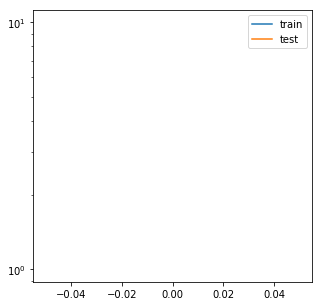

nan
nan
nan


/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [31]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-2

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=False)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.01963937
Train Epoch: 1 [256/2005 (12%)]	Loss: 27476798699876048233705221006405249531904.00000000
Train Epoch: 1 [512/2005 (25%)]	Loss: nan
Train Epoch: 1 [768/2005 (38%)]	Loss: nan
Train Epoch: 1 [1024/2005 (50%)]	Loss: nan
Train Epoch: 1 [1280/2005 (62%)]	Loss: nan
Train Epoch: 1 [1536/2005 (75%)]	Loss: nan
Train Epoch: 1 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 2 [0/2005 (0%)]	Loss: nan
Train Epoch: 2 [256/2005 (12%)]	Loss: nan
Train Epoch: 2 [512/2005 (25%)]	Loss: nan
Train Epoch: 2 [768/2005 (38%)]	Loss: nan
Train Epoch: 2 [1024/2005 (50%)]	Loss: nan
Train Epoch: 2 [1280/2005 (62%)]	Loss: nan
Train Epoch: 2 [1536/2005 (75%)]	Loss: nan
Train Epoch: 2 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 3 [0/2005 (0%)]	Loss: nan
Train Epoch: 3 [256/2005 (12%)]	Loss: nan
Train Epoch: 3 [512/2005 (25%)]	Loss: nan
Train Epoch: 3 [768/2005 (38%)]	Loss: nan
Train Epoch: 3 [1024/2005 (50%)]	Loss: nan
Trai


Test set: Average loss: nan

Train Epoch: 23 [0/2005 (0%)]	Loss: nan
Train Epoch: 23 [256/2005 (12%)]	Loss: nan
Train Epoch: 23 [512/2005 (25%)]	Loss: nan
Train Epoch: 23 [768/2005 (38%)]	Loss: nan
Train Epoch: 23 [1024/2005 (50%)]	Loss: nan
Train Epoch: 23 [1280/2005 (62%)]	Loss: nan
Train Epoch: 23 [1536/2005 (75%)]	Loss: nan
Train Epoch: 23 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 24 [0/2005 (0%)]	Loss: nan
Train Epoch: 24 [256/2005 (12%)]	Loss: nan
Train Epoch: 24 [512/2005 (25%)]	Loss: nan
Train Epoch: 24 [768/2005 (38%)]	Loss: nan
Train Epoch: 24 [1024/2005 (50%)]	Loss: nan
Train Epoch: 24 [1280/2005 (62%)]	Loss: nan
Train Epoch: 24 [1536/2005 (75%)]	Loss: nan
Train Epoch: 24 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 25 [0/2005 (0%)]	Loss: nan
Train Epoch: 25 [256/2005 (12%)]	Loss: nan
Train Epoch: 25 [512/2005 (25%)]	Loss: nan
Train Epoch: 25 [768/2005 (38%)]	Loss: nan
Train Epoch: 25 [1024/2005 (50%)]	Loss: nan
Train E

Train Epoch: 44 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 45 [0/2005 (0%)]	Loss: nan
Train Epoch: 45 [256/2005 (12%)]	Loss: nan
Train Epoch: 45 [512/2005 (25%)]	Loss: nan
Train Epoch: 45 [768/2005 (38%)]	Loss: nan
Train Epoch: 45 [1024/2005 (50%)]	Loss: nan
Train Epoch: 45 [1280/2005 (62%)]	Loss: nan
Train Epoch: 45 [1536/2005 (75%)]	Loss: nan
Train Epoch: 45 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 46 [0/2005 (0%)]	Loss: nan
Train Epoch: 46 [256/2005 (12%)]	Loss: nan
Train Epoch: 46 [512/2005 (25%)]	Loss: nan
Train Epoch: 46 [768/2005 (38%)]	Loss: nan
Train Epoch: 46 [1024/2005 (50%)]	Loss: nan
Train Epoch: 46 [1280/2005 (62%)]	Loss: nan
Train Epoch: 46 [1536/2005 (75%)]	Loss: nan
Train Epoch: 46 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 47 [0/2005 (0%)]	Loss: nan
Train Epoch: 47 [256/2005 (12%)]	Loss: nan
Train Epoch: 47 [512/2005 (25%)]	Loss: nan
Train Epoch: 47 [768/2005 (38%)]	Loss: nan
Train E

Train Epoch: 66 [1536/2005 (75%)]	Loss: nan
Train Epoch: 66 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 67 [0/2005 (0%)]	Loss: nan
Train Epoch: 67 [256/2005 (12%)]	Loss: nan
Train Epoch: 67 [512/2005 (25%)]	Loss: nan
Train Epoch: 67 [768/2005 (38%)]	Loss: nan
Train Epoch: 67 [1024/2005 (50%)]	Loss: nan
Train Epoch: 67 [1280/2005 (62%)]	Loss: nan
Train Epoch: 67 [1536/2005 (75%)]	Loss: nan
Train Epoch: 67 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 68 [0/2005 (0%)]	Loss: nan
Train Epoch: 68 [256/2005 (12%)]	Loss: nan
Train Epoch: 68 [512/2005 (25%)]	Loss: nan
Train Epoch: 68 [768/2005 (38%)]	Loss: nan
Train Epoch: 68 [1024/2005 (50%)]	Loss: nan
Train Epoch: 68 [1280/2005 (62%)]	Loss: nan
Train Epoch: 68 [1536/2005 (75%)]	Loss: nan
Train Epoch: 68 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 69 [0/2005 (0%)]	Loss: nan
Train Epoch: 69 [256/2005 (12%)]	Loss: nan
Train Epoch: 69 [512/2005 (25%)]	Loss: nan
Train 

Train Epoch: 88 [1280/2005 (62%)]	Loss: nan
Train Epoch: 88 [1536/2005 (75%)]	Loss: nan
Train Epoch: 88 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 89 [0/2005 (0%)]	Loss: nan
Train Epoch: 89 [256/2005 (12%)]	Loss: nan
Train Epoch: 89 [512/2005 (25%)]	Loss: nan
Train Epoch: 89 [768/2005 (38%)]	Loss: nan
Train Epoch: 89 [1024/2005 (50%)]	Loss: nan
Train Epoch: 89 [1280/2005 (62%)]	Loss: nan
Train Epoch: 89 [1536/2005 (75%)]	Loss: nan
Train Epoch: 89 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 90 [0/2005 (0%)]	Loss: nan
Train Epoch: 90 [256/2005 (12%)]	Loss: nan
Train Epoch: 90 [512/2005 (25%)]	Loss: nan
Train Epoch: 90 [768/2005 (38%)]	Loss: nan
Train Epoch: 90 [1024/2005 (50%)]	Loss: nan
Train Epoch: 90 [1280/2005 (62%)]	Loss: nan
Train Epoch: 90 [1536/2005 (75%)]	Loss: nan
Train Epoch: 90 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 91 [0/2005 (0%)]	Loss: nan
Train Epoch: 91 [256/2005 (12%)]	Loss: nan
Train

Train Epoch: 110 [512/2005 (25%)]	Loss: nan
Train Epoch: 110 [768/2005 (38%)]	Loss: nan
Train Epoch: 110 [1024/2005 (50%)]	Loss: nan
Train Epoch: 110 [1280/2005 (62%)]	Loss: nan
Train Epoch: 110 [1536/2005 (75%)]	Loss: nan
Train Epoch: 110 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 111 [0/2005 (0%)]	Loss: nan
Train Epoch: 111 [256/2005 (12%)]	Loss: nan
Train Epoch: 111 [512/2005 (25%)]	Loss: nan
Train Epoch: 111 [768/2005 (38%)]	Loss: nan
Train Epoch: 111 [1024/2005 (50%)]	Loss: nan
Train Epoch: 111 [1280/2005 (62%)]	Loss: nan
Train Epoch: 111 [1536/2005 (75%)]	Loss: nan
Train Epoch: 111 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 112 [0/2005 (0%)]	Loss: nan
Train Epoch: 112 [256/2005 (12%)]	Loss: nan
Train Epoch: 112 [512/2005 (25%)]	Loss: nan
Train Epoch: 112 [768/2005 (38%)]	Loss: nan
Train Epoch: 112 [1024/2005 (50%)]	Loss: nan
Train Epoch: 112 [1280/2005 (62%)]	Loss: nan
Train Epoch: 112 [1536/2005 (75%)]	Loss: nan
Train Epoch

Train Epoch: 131 [1536/2005 (75%)]	Loss: nan
Train Epoch: 131 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 132 [0/2005 (0%)]	Loss: nan
Train Epoch: 132 [256/2005 (12%)]	Loss: nan
Train Epoch: 132 [512/2005 (25%)]	Loss: nan
Train Epoch: 132 [768/2005 (38%)]	Loss: nan
Train Epoch: 132 [1024/2005 (50%)]	Loss: nan
Train Epoch: 132 [1280/2005 (62%)]	Loss: nan
Train Epoch: 132 [1536/2005 (75%)]	Loss: nan
Train Epoch: 132 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 133 [0/2005 (0%)]	Loss: nan
Train Epoch: 133 [256/2005 (12%)]	Loss: nan
Train Epoch: 133 [512/2005 (25%)]	Loss: nan
Train Epoch: 133 [768/2005 (38%)]	Loss: nan
Train Epoch: 133 [1024/2005 (50%)]	Loss: nan
Train Epoch: 133 [1280/2005 (62%)]	Loss: nan
Train Epoch: 133 [1536/2005 (75%)]	Loss: nan
Train Epoch: 133 [1792/2005 (88%)]	Loss: nan

Test set: Average loss: nan

Train Epoch: 134 [0/2005 (0%)]	Loss: nan
Train Epoch: 134 [256/2005 (12%)]	Loss: nan
Train Epoch: 134 [512/2005 (2

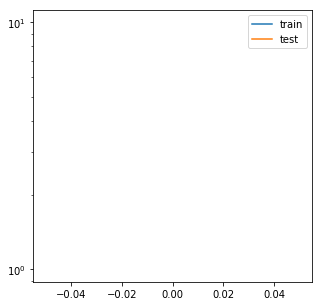

nan
nan
nan


/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [32]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-1

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=False)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.27703698
Train Epoch: 1 [256/2005 (12%)]	Loss: 1.29932007
Train Epoch: 1 [512/2005 (25%)]	Loss: 1.00849810
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.75900269
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.73961800
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.56509573
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.43974293
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.36204611

Test set: Average loss: 1.1924639162

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.51332583
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.35208452
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.43160261
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.33099432
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.47389338
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.30011076
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.37938845
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.26399800

Test set: Average loss: 1.3490428136

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.37230458
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.31616444
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.3

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.16630251

Test set: Average loss: 0.1426728599

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.12866886
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.15968963
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.13030685
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.19681954
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.21518490
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.24681086
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.18142823
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.20992503

Test set: Average loss: 0.1451729534

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.11039543
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.13681296
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.13352238
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.11870973
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.12274893
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.22534933
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.18795401
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.15156863

Test set: Average loss: 0.1386858836

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.16859553
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.16401097
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.23645381
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.16455729

Test set: Average loss: 0.1178686183

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.14892686
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.14386353
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.18082268
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.13311436
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.17371306
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.13571822
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.17075496
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.16821555

Test set: Average loss: 0.1255104760

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.15878390
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.10269756
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.17482588
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.16884680
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.10556897
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.18542988
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.13510071
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.10784716
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.19018886
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.12174389
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.13165450
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.10334899
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.15650915

Test set: Average loss: 0.1167029781

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.12244841
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.08257147
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.11690732
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.09681875
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.12563224
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.13199423
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.13472367
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.09791116

Test set: Average loss: 0.1151968286

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.16559570
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.11430392
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.08264693
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.16284512

Test set: Average loss: 0.1127350191

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.17273964
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.10412945
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.15298057
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.16011685
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.10763484
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.15765127
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.13364516
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.09523021

Test set: Average loss: 0.1141672156

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.15171488
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.12831962
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.20368172
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.13199390
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.14293376
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.16087478
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.16813826
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.11710929

Test set: Average loss: 0.1147362580

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.11158409
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.15471129
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.10263631
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.09070623

Test set: Average loss: 0.1089755783

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.15642037
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.12671182
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.12815625
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.14893890
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.14424713
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.13197109
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.14909417
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.11175014

Test set: Average loss: 0.1150493248

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.08900913
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.14477623
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.15869060
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.11674999
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.15890849
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.15012751
Train Epoch: 96 [1


Test set: Average loss: 0.1093369294

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.12235004
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.13980135
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.12288466
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.15025467
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.12604754
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.10444002
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.20121139
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.12829038

Test set: Average loss: 0.1078860318

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.11896118
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.12064576
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.13604536
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.15574083
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.14764503
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.12666863
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.14852288
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.14731283

Test set: Average loss: 0.1100760073

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.25721830
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.16158471
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.16364246
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.16164728
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.12062893
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.07866668
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.12180993

Test set: Average loss: 0.1088496353

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.11074742
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.12537151
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.11204456
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.12096611
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.12971985
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.13624952
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.15748010
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.12983409

Test set: Average loss: 0.1157118147

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.11372433
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.12369308
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.11074171
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.14755814
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.13575303
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.17208035
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.09561168

Test set: Average loss: 0.1132822170



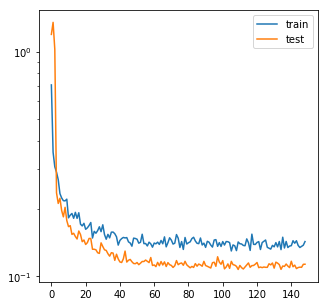

0.107384728770652
0.11328221698883537
2.9465936299512828e-06


In [33]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-4

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=False)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

In [14]:
from torchvision import models

In [66]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, fixed_size=True, interpolation=0)
test_aug = pad_img(h, w, fixed_size=True, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug, transform=True, rotate=True)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug, transform=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 150

In [70]:
d = []
for i in range(10):
    for j in range(len(train_dataset)):
        d.append(train_dataset[j][0][0].reshape(h * w, 1))
d = np.concatenate(d, axis=0)

In [71]:
normalizer = StandardScaler().fit(d)

In [72]:
train_dataset.normalizer = normalizer

In [73]:
test_dataset.normalizer = normalizer

Train Epoch: 1 [0/2005 (0%)]	Loss: 2.35533278
Train Epoch: 1 [256/2005 (12%)]	Loss: 5.29506676
Train Epoch: 1 [512/2005 (25%)]	Loss: 1.15429870
Train Epoch: 1 [768/2005 (38%)]	Loss: 1.09671276
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.75010700
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.52950378
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.50761189
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.37185878

Test set: Average loss: 0.7553589220

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.24868555
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.47600990
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.19507515
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.27181097
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.22375422
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.30015689
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.25287810
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.14720465

Test set: Average loss: 0.1325883568

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.30779717
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.17060341
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.2

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.16620352

Test set: Average loss: 0.1516182633

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.11363737
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.08109942
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.10360173
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.13532719
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.06500143
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.11439215
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.09104424
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.14612777

Test set: Average loss: 0.0713805418

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.08802758
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.12169716
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.08325832
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.14638697
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.09284484
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.07960763
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.08259041
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.09999353

Test set: Average loss: 0.1991647276

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.10950059
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.14726311
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.11857960
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.05835761

Test set: Average loss: 0.0397410345

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.14760874
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.10194702
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.05488636
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.16287874
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.11711531
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.10997257
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.09417878
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.05527568

Test set: Average loss: 0.0527013442

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.11673809
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.10566903
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.08004382
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.11188474
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.10984889
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.09172029
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.05791763
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.13923217
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.08763071
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.07963188
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.08493261
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.07219390
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.12945283

Test set: Average loss: 0.0221397482

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06726286
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.13871478
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.06729900
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.07182345
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.06017637
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.10288472
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.06867831
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.10103795

Test set: Average loss: 0.0394756438

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.10008160
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.06178555
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.12802410
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.04934981

Test set: Average loss: 0.0315299493

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.06141047
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.15998620
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.05993330
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.08569218
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.09542258
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.07112625
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.10331414
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.06346818

Test set: Average loss: 0.0266663955

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.11228459
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.04845616
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.15000065
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.13181163
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.07077518
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.07387187
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.06178144
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.06958190

Test set: Average loss: 0.0364600457

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.05706050
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.09283667
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.07997495
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.07067348

Test set: Average loss: 0.0253111045

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.11030099
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.05816658
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.14923771
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.10427093
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.14267480
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.09367961
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.07983088
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.05916737

Test set: Average loss: 0.0323931097

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.08497845
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.07335643
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.10230845
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.05553073
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.06384855
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.07135246
Train Epoch: 96 [1


Test set: Average loss: 0.0249681509

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.05807936
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.05785078
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.07881771
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.08973939
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.07415059
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.17541839
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.09326819
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.04599234

Test set: Average loss: 0.0256047937

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.08892271
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.05548049
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.15990847
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.12678620
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.13480479
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.05354300
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.07037151
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.08128943

Test set: Average loss: 0.0229780151

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.10331876
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.05743589
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.09869904
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.12952077
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.08825275
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.06418056
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.11543238

Test set: Average loss: 0.0281404984

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.06115693
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.10361723
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.05942631
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.06834845
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.06319330
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.09467818
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.08002859
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.08170438

Test set: Average loss: 0.0221780421

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.05135155
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.10900803
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.07084963
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.11016420
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.05828572
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.08014408
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.07099276

Test set: Average loss: 0.0260718250



Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f6e72a31b70>
Traceback (most recent call last):
  File "/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/evlavrukhin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


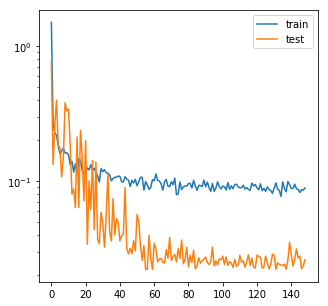

0.022081589848801247
0.026071825036211853
6.781565157793264e-07


In [75]:
train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.11340446
Train Epoch: 1 [256/2005 (12%)]	Loss: 0.80200467
Train Epoch: 1 [512/2005 (25%)]	Loss: 1.02940492
Train Epoch: 1 [768/2005 (38%)]	Loss: 1.14399029
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.98202807
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.80204329
Train Epoch: 1 [1536/2005 (75%)]	Loss: 1.09967319
Train Epoch: 1 [1792/2005 (88%)]	Loss: 1.17358038

Test set: Average loss: 2.2109760310

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.99860595
Train Epoch: 2 [256/2005 (12%)]	Loss: 1.08585895
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.82178958
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.69332425
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.75481444
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.74182398
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.80608976
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.90206545

Test set: Average loss: 24.4607336985

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.60127427
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.54020147
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.20380130

Test set: Average loss: 1.2109235073

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.17044356
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.20658794
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.24253629
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.13181127
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.20709064
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.32308068
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.19227381
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.17504566

Test set: Average loss: 1.6645398479

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.24073052
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.27280796
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.28412014
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.18873852
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.20214281
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.25829534
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.46183723
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.18709866

Test set: Average loss: 1.3807023611

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.32216145
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.28548151
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.14370382
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.15212993

Test set: Average loss: 1.9103636319

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.13602942
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.14919126
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.14406610
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.12167352
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.11394610
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.15610174
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.10203023
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.28459818

Test set: Average loss: 58.4700688892

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.20429981
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.18497541
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.18209836
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.15093938
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.12785929
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.10737424
Train Epoch: 40 [

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.09582170
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.19977893
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.09793540
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.13486174
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.19110646
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.07364889
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.13695420

Test set: Average loss: 88.1110463993

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.14418458
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.29341654
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.12669312
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.09541974
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.12764410
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.20214125
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.12798273
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.09401422

Test set: Average loss: 6.1958916397

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.10859293
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.16737530
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.09945675
Train Epoch: 59 [76

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.11200660

Test set: Average loss: 5.2996182328

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.08156689
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.16220053
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.06394394
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.11685250
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.12297465
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.09962464
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.14436267
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.10423401

Test set: Average loss: 6.3271946321

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.08790829
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.17879316
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.12690117
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.23366328
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.13544372
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.09372588
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.09893166
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.09368827

Test set: Average loss: 5.9412749896

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.07876972
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.11974266
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.08256690
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.07863025

Test set: Average loss: 4.0516475615

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.09108930
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.16647949
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.10211777
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.11478187
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.11916402
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.11549823
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.10329219
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.12562118

Test set: Average loss: 3.7677802631

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.20445253
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.14354594
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.11240472
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.11778971
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.08683677
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.15342688
Train Epoch: 96 [1


Test set: Average loss: 7.0120596967

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.13715073
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.15107512
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.12789462
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.08109878
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.07538344
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.06422748
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.10210471
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.06962457

Test set: Average loss: 6.7051335196

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.17302078
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.09334121
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.06127532
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.12197747
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.06432938
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.15482690
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.08537916
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.08615121

Test set: Average loss: 0.1490327685

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.10838526
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.10216641
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.11856778
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.07813097
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.09126477
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.12822074
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.15165068

Test set: Average loss: 1.0739743437

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.12156376
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.10812763
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.07459970
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.06733236
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.12088471
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.09793012
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.11185677
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.06948981

Test set: Average loss: 0.5628897221

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.10566737
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.13505582
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.08265101
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.09131579
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.07977529
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.09954480
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.10474457

Test set: Average loss: 0.2748950164

Train Epoch: 150 [0/2005 (0%)]	Loss: 0.08202995
Train Epoch: 150 [256/2005 (12%)]	Loss: 0.14786326
Train Epoch: 150 [512/2005 (25%)]	Loss: 0.15032664
Train Epoch: 150 [768/2005 (38%)]	Loss: 0.13944089
Train Epoch: 150 [1024/2005 (50%)]	Loss: 0.09303526
Train Epoch: 150 [1280/2005 (62%)]	Loss: 0.08544813
Train Epoch: 150 [1536/2005 (75%)]	Loss: 0.06742047
Train Epoch: 150 [1792/2005 (88%)]	Loss: 0.08441782

Test set: Average loss: 0.2018537593

Train Epoch: 151 [0/2005 (0%)]	Loss: 0.06899915
Train Epoch: 151 [256/2005 (12%)]	Loss: 0.08110089
Train Epoch: 151 [512/2005 (25%)]	Loss: 0.12544568
Train Epoch: 151 [768/2005 (38%)]	Loss: 0.06998835
Train Epoch: 151 [1024/2005 (50%)]	Loss: 0.10772306
Train Epoch: 151 [1280/2005 (62%)]	Loss: 0.13209470
Train Epoch: 151 [1536/2005 (75%)]	Loss: 0.08654060



Test set: Average loss: 0.0537219093

Train Epoch: 168 [0/2005 (0%)]	Loss: 0.06883008
Train Epoch: 168 [256/2005 (12%)]	Loss: 0.10054872
Train Epoch: 168 [512/2005 (25%)]	Loss: 0.07524150
Train Epoch: 168 [768/2005 (38%)]	Loss: 0.13456932
Train Epoch: 168 [1024/2005 (50%)]	Loss: 0.10688927
Train Epoch: 168 [1280/2005 (62%)]	Loss: 0.12125637
Train Epoch: 168 [1536/2005 (75%)]	Loss: 0.07212782
Train Epoch: 168 [1792/2005 (88%)]	Loss: 0.13830128

Test set: Average loss: 0.0526619770

Train Epoch: 169 [0/2005 (0%)]	Loss: 0.07914890
Train Epoch: 169 [256/2005 (12%)]	Loss: 0.06511230
Train Epoch: 169 [512/2005 (25%)]	Loss: 0.12394909
Train Epoch: 169 [768/2005 (38%)]	Loss: 0.07537349
Train Epoch: 169 [1024/2005 (50%)]	Loss: 0.07533961
Train Epoch: 169 [1280/2005 (62%)]	Loss: 0.10261010
Train Epoch: 169 [1536/2005 (75%)]	Loss: 0.08802659
Train Epoch: 169 [1792/2005 (88%)]	Loss: 0.16214396

Test set: Average loss: 0.0504719140

Train Epoch: 170 [0/2005 (0%)]	Loss: 0.09110692
Train Epoch: 170 

Train Epoch: 186 [512/2005 (25%)]	Loss: 0.14313985
Train Epoch: 186 [768/2005 (38%)]	Loss: 0.07244357
Train Epoch: 186 [1024/2005 (50%)]	Loss: 0.08685923
Train Epoch: 186 [1280/2005 (62%)]	Loss: 0.09438286
Train Epoch: 186 [1536/2005 (75%)]	Loss: 0.07537497
Train Epoch: 186 [1792/2005 (88%)]	Loss: 0.07689483

Test set: Average loss: 0.0518279292

Train Epoch: 187 [0/2005 (0%)]	Loss: 0.11901380
Train Epoch: 187 [256/2005 (12%)]	Loss: 0.16639931
Train Epoch: 187 [512/2005 (25%)]	Loss: 0.09124156
Train Epoch: 187 [768/2005 (38%)]	Loss: 0.06855382
Train Epoch: 187 [1024/2005 (50%)]	Loss: 0.09956871
Train Epoch: 187 [1280/2005 (62%)]	Loss: 0.09833508
Train Epoch: 187 [1536/2005 (75%)]	Loss: 0.08488937
Train Epoch: 187 [1792/2005 (88%)]	Loss: 0.05829928

Test set: Average loss: 0.0525161606

Train Epoch: 188 [0/2005 (0%)]	Loss: 0.10448737
Train Epoch: 188 [256/2005 (12%)]	Loss: 0.11752880
Train Epoch: 188 [512/2005 (25%)]	Loss: 0.09995428
Train Epoch: 188 [768/2005 (38%)]	Loss: 0.11984312
Tr

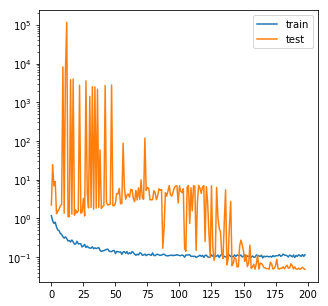

0.048051740377411944
0.048051740377411944
1.2498780114632578e-06


In [14]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 200

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/evlavrukhin/.torch/models/resnet34-333f7ec4.pth
100.0%


Train Epoch: 1 [0/2005 (0%)]	Loss: 1.41221023
Train Epoch: 1 [256/2005 (12%)]	Loss: 7.56329992
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.89448017
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.63497352
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.63556215
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.33497054
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.44829491
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.29580503

Test set: Average loss: 0.7828344764

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.23935107
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.23953271
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.28410361
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.26451101
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.29403554
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.18404599
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.29466332
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.21059542

Test set: Average loss: 0.2421849251

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.27994848
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.18906672
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.2

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.10298563

Test set: Average loss: 0.0360318275

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.04390609
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.08443393
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.12862845
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.13126847
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.08035600
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.10866954
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.07314921
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.04630069

Test set: Average loss: 0.0462694830

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.07483308
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.16429267
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.10602931
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.14627146
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.07118314
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.07610263
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.14928865
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.08280611

Test set: Average loss: 0.0628410912

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.10435586
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.05621109
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.07232708
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.05242804

Test set: Average loss: 0.0396394905

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.06592103
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.10420849
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.06902995
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.08190347
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.04141444
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.05350734
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.08217467
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.06431777

Test set: Average loss: 0.0309593452

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.11289418
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.09228617
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.10231797
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.09609514
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.09809256
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.06238657
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.05821150
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.10955062
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.05680074
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.05283296
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.07224015
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.06050033
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.07729701

Test set: Average loss: 0.0258638475

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.10311618
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.13417319
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.07185067
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.08838869
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.08681833
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.06678258
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.05163686
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.04798894

Test set: Average loss: 0.0294590679

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.07959161
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.07653392
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.06424047
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.05671646

Test set: Average loss: 0.0267302780

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.05819882
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.08668181
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.04521476
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.06409862
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.05310945
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.04464011
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.11564387
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.06442426

Test set: Average loss: 0.0236773510

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.04806193
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.09047755
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.10512173
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.14665723
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.06863099
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.06156589
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.08581476
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.04095121

Test set: Average loss: 0.0275309586

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.05835409
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.06850079
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.06873366
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.04887719

Test set: Average loss: 0.0259359788

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.08849851
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.05087336
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.03420491
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.04655482
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.07544856
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.04036151
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.06833338
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.07551127

Test set: Average loss: 0.0233171622

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.15687107
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.07398979
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.06560359
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.10612321
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.05325741
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.06176980
Train Epoch: 96 [1


Test set: Average loss: 0.0291806741

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.03725051
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.09371419
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.06242511
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.07564990
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.05025703
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.04794653
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.04795307
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.06927413

Test set: Average loss: 0.0233656957

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.06274613
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.05965119
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.05971275
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.06656250
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.05422841
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.06814888
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.06893977
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.04715640

Test set: Average loss: 0.0278371282

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.04223254
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.06475428
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.03263600
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.06111455
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.05251154
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.04821585
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.08377783

Test set: Average loss: 0.0227142249

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.07769877
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.06040415
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.05165472
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.07695344
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.05897132
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.04941186
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05878187
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.05099337

Test set: Average loss: 0.0230150746

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.04956064
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.09238550
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.08297268
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.06070001
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.04306609
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.04781325
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.06504270

Test set: Average loss: 0.0282741181

Train Epoch: 150 [0/2005 (0%)]	Loss: 0.06848202
Train Epoch: 150 [256/2005 (12%)]	Loss: 0.11868102
Train Epoch: 150 [512/2005 (25%)]	Loss: 0.09686355
Train Epoch: 150 [768/2005 (38%)]	Loss: 0.06281102
Train Epoch: 150 [1024/2005 (50%)]	Loss: 0.05047446
Train Epoch: 150 [1280/2005 (62%)]	Loss: 0.06046132
Train Epoch: 150 [1536/2005 (75%)]	Loss: 0.06036152
Train Epoch: 150 [1792/2005 (88%)]	Loss: 0.04093213

Test set: Average loss: 0.0223356276

Train Epoch: 151 [0/2005 (0%)]	Loss: 0.04715805
Train Epoch: 151 [256/2005 (12%)]	Loss: 0.04757396
Train Epoch: 151 [512/2005 (25%)]	Loss: 0.09583116
Train Epoch: 151 [768/2005 (38%)]	Loss: 0.07061308
Train Epoch: 151 [1024/2005 (50%)]	Loss: 0.07391986
Train Epoch: 151 [1280/2005 (62%)]	Loss: 0.06283723
Train Epoch: 151 [1536/2005 (75%)]	Loss: 0.06413942



Test set: Average loss: 0.0221236940

Train Epoch: 168 [0/2005 (0%)]	Loss: 0.04131259
Train Epoch: 168 [256/2005 (12%)]	Loss: 0.05556260
Train Epoch: 168 [512/2005 (25%)]	Loss: 0.05973383
Train Epoch: 168 [768/2005 (38%)]	Loss: 0.05006493
Train Epoch: 168 [1024/2005 (50%)]	Loss: 0.07245399
Train Epoch: 168 [1280/2005 (62%)]	Loss: 0.05854966
Train Epoch: 168 [1536/2005 (75%)]	Loss: 0.04149067
Train Epoch: 168 [1792/2005 (88%)]	Loss: 0.09707639

Test set: Average loss: 0.0243468178

Train Epoch: 169 [0/2005 (0%)]	Loss: 0.03583698
Train Epoch: 169 [256/2005 (12%)]	Loss: 0.05788134
Train Epoch: 169 [512/2005 (25%)]	Loss: 0.07360111
Train Epoch: 169 [768/2005 (38%)]	Loss: 0.06209697
Train Epoch: 169 [1024/2005 (50%)]	Loss: 0.04731439
Train Epoch: 169 [1280/2005 (62%)]	Loss: 0.07405517
Train Epoch: 169 [1536/2005 (75%)]	Loss: 0.06600104
Train Epoch: 169 [1792/2005 (88%)]	Loss: 0.10185414

Test set: Average loss: 0.0221795897

Train Epoch: 170 [0/2005 (0%)]	Loss: 0.05388254
Train Epoch: 170 

Train Epoch: 186 [512/2005 (25%)]	Loss: 0.04495167
Train Epoch: 186 [768/2005 (38%)]	Loss: 0.07629534
Train Epoch: 186 [1024/2005 (50%)]	Loss: 0.05524353
Train Epoch: 186 [1280/2005 (62%)]	Loss: 0.04725460
Train Epoch: 186 [1536/2005 (75%)]	Loss: 0.04308231
Train Epoch: 186 [1792/2005 (88%)]	Loss: 0.04537396

Test set: Average loss: 0.0245396669

Train Epoch: 187 [0/2005 (0%)]	Loss: 0.06883282
Train Epoch: 187 [256/2005 (12%)]	Loss: 0.15236817
Train Epoch: 187 [512/2005 (25%)]	Loss: 0.06481480
Train Epoch: 187 [768/2005 (38%)]	Loss: 0.06031557
Train Epoch: 187 [1024/2005 (50%)]	Loss: 0.05670485
Train Epoch: 187 [1280/2005 (62%)]	Loss: 0.05438345
Train Epoch: 187 [1536/2005 (75%)]	Loss: 0.05029264
Train Epoch: 187 [1792/2005 (88%)]	Loss: 0.04122082

Test set: Average loss: 0.0222917180

Train Epoch: 188 [0/2005 (0%)]	Loss: 0.05900512
Train Epoch: 188 [256/2005 (12%)]	Loss: 0.04684572
Train Epoch: 188 [512/2005 (25%)]	Loss: 0.05328387
Train Epoch: 188 [768/2005 (38%)]	Loss: 0.07194128
Tr

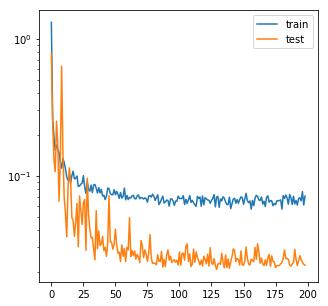

0.020732072527259972
0.02228034415836028
5.795359758594497e-07


In [22]:
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 200

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.80049993
Train Epoch: 1 [256/2005 (12%)]	Loss: 6.85721633
Train Epoch: 1 [512/2005 (25%)]	Loss: 0.96237325
Train Epoch: 1 [768/2005 (38%)]	Loss: 0.91654197
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.57619389
Train Epoch: 1 [1280/2005 (62%)]	Loss: 0.73611643
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.73783437
Train Epoch: 1 [1792/2005 (88%)]	Loss: 0.35950004

Test set: Average loss: 0.6531488251

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.49219426
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.50462480
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.37959632
Train Epoch: 2 [768/2005 (38%)]	Loss: 0.27085342
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.33870077
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.24303203
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.31372026
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.21237169

Test set: Average loss: 0.2170215327

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.34388975
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.24497318
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.3

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.07493239

Test set: Average loss: 0.0595356634

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.07174258
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.08561147
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.10084193
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.09893420
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.07212856
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.12682864
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.09805881
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.12553733

Test set: Average loss: 0.0654206798

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.07924571
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.09035356
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.11910810
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.12132425
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.09455494
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.06813155
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.13622275
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.11797302

Test set: Average loss: 0.0477815953

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.06284959
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.08336772
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.07764692
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.08895364

Test set: Average loss: 0.0284797135

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.08282624
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.06467358
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.06623801
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.11273950
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.08245131
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.07180983
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.09534889
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.05480596

Test set: Average loss: 0.0275015943

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.04613587
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.09206674
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.08436128
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.05868654
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.06500819
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.07151024
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.06663496
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.07145892
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.10652517
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.07304788
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.07822837
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.09451896
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.09159092

Test set: Average loss: 0.0278397561

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.12342215
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.05739435
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.08114983
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.11982717
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.09016134
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.07887105
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.06261315
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.07111303

Test set: Average loss: 0.0288288924

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.06074607
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.09210286
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.06704224
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.08635723

Test set: Average loss: 0.0266365712

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.05893396
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.09300075
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.06095434
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.07712933
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.06746023
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.04260117
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.05950520
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.04441945

Test set: Average loss: 0.0271322269

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.06479408
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.05176481
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.05793588
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.07731645
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.03727503
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.09282854
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.10088482
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.04629593

Test set: Average loss: 0.0225803672

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.05813781
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.06197366
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.04596176
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.05978463

Test set: Average loss: 0.0214160509

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.12939240
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.05243214
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.09749796
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.06610619
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.04419925
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.07331177
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.08785982
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.06483459

Test set: Average loss: 0.0232379310

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.04205969
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.05984033
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.05779515
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.04620260
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.06512619
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.06339970
Train Epoch: 96 [1


Test set: Average loss: 0.0230917820

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.06534947
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.20456316
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.03674115
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.04588380
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.05880375
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.08621578
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.06908359
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.08660922

Test set: Average loss: 0.0231696688

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.06242219
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.07184146
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.06049641
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.07720204
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.07705013
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.06739523
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.06342078
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.07432895

Test set: Average loss: 0.0223611936

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.11534095
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.04705047
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.03983799
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.12139805
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.06003887
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.09371352
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.04634579

Test set: Average loss: 0.0224852168

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.16197319
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.13854312
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.09279757
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.04435505
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.07240662
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.07210992
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05356667
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.05558617

Test set: Average loss: 0.0201605655

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.07867371
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.05824840
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.03883860
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.03853168
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.07072253
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.06600343
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.05002821

Test set: Average loss: 0.0225193635

Train Epoch: 150 [0/2005 (0%)]	Loss: 0.07534541
Train Epoch: 150 [256/2005 (12%)]	Loss: 0.06021577
Train Epoch: 150 [512/2005 (25%)]	Loss: 0.04401054
Train Epoch: 150 [768/2005 (38%)]	Loss: 0.06630212
Train Epoch: 150 [1024/2005 (50%)]	Loss: 0.10256685
Train Epoch: 150 [1280/2005 (62%)]	Loss: 0.04143658
Train Epoch: 150 [1536/2005 (75%)]	Loss: 0.07937320
Train Epoch: 150 [1792/2005 (88%)]	Loss: 0.06329444

Test set: Average loss: 0.0198074129

Train Epoch: 151 [0/2005 (0%)]	Loss: 0.05198598
Train Epoch: 151 [256/2005 (12%)]	Loss: 0.07995648
Train Epoch: 151 [512/2005 (25%)]	Loss: 0.06388097
Train Epoch: 151 [768/2005 (38%)]	Loss: 0.08631324
Train Epoch: 151 [1024/2005 (50%)]	Loss: 0.05531214
Train Epoch: 151 [1280/2005 (62%)]	Loss: 0.04048996
Train Epoch: 151 [1536/2005 (75%)]	Loss: 0.06648974



Test set: Average loss: 0.0215987419

Train Epoch: 168 [0/2005 (0%)]	Loss: 0.06390359
Train Epoch: 168 [256/2005 (12%)]	Loss: 0.12286206
Train Epoch: 168 [512/2005 (25%)]	Loss: 0.05599234
Train Epoch: 168 [768/2005 (38%)]	Loss: 0.05325941
Train Epoch: 168 [1024/2005 (50%)]	Loss: 0.07705974
Train Epoch: 168 [1280/2005 (62%)]	Loss: 0.14999098
Train Epoch: 168 [1536/2005 (75%)]	Loss: 0.06543849
Train Epoch: 168 [1792/2005 (88%)]	Loss: 0.11598581

Test set: Average loss: 0.0196687955

Train Epoch: 169 [0/2005 (0%)]	Loss: 0.07385856
Train Epoch: 169 [256/2005 (12%)]	Loss: 0.04679228
Train Epoch: 169 [512/2005 (25%)]	Loss: 0.05931001
Train Epoch: 169 [768/2005 (38%)]	Loss: 0.16043259
Train Epoch: 169 [1024/2005 (50%)]	Loss: 0.05330786
Train Epoch: 169 [1280/2005 (62%)]	Loss: 0.07074932
Train Epoch: 169 [1536/2005 (75%)]	Loss: 0.05903725
Train Epoch: 169 [1792/2005 (88%)]	Loss: 0.05966567

Test set: Average loss: 0.0201334755

Train Epoch: 170 [0/2005 (0%)]	Loss: 0.05702289
Train Epoch: 170 

Train Epoch: 186 [512/2005 (25%)]	Loss: 0.07009805
Train Epoch: 186 [768/2005 (38%)]	Loss: 0.08252956
Train Epoch: 186 [1024/2005 (50%)]	Loss: 0.08657649
Train Epoch: 186 [1280/2005 (62%)]	Loss: 0.11137554
Train Epoch: 186 [1536/2005 (75%)]	Loss: 0.08111073
Train Epoch: 186 [1792/2005 (88%)]	Loss: 0.06826438

Test set: Average loss: 0.0199553673

Train Epoch: 187 [0/2005 (0%)]	Loss: 0.05561020
Train Epoch: 187 [256/2005 (12%)]	Loss: 0.10052607
Train Epoch: 187 [512/2005 (25%)]	Loss: 0.07939750
Train Epoch: 187 [768/2005 (38%)]	Loss: 0.08741607
Train Epoch: 187 [1024/2005 (50%)]	Loss: 0.03852200
Train Epoch: 187 [1280/2005 (62%)]	Loss: 0.05237660
Train Epoch: 187 [1536/2005 (75%)]	Loss: 0.05137802
Train Epoch: 187 [1792/2005 (88%)]	Loss: 0.07869359

Test set: Average loss: 0.0227163536

Train Epoch: 188 [0/2005 (0%)]	Loss: 0.05118909
Train Epoch: 188 [256/2005 (12%)]	Loss: 0.06299317
Train Epoch: 188 [512/2005 (25%)]	Loss: 0.04498612
Train Epoch: 188 [768/2005 (38%)]	Loss: 0.04752153
Tr

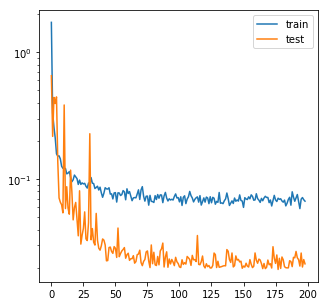

0.01937952230639111
0.02145194732961407
5.579884736694459e-07


In [50]:
imp.reload(augmentations)
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

batch_size = 64
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 200

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.50200855
Train Epoch: 1 [512/2005 (25%)]	Loss: 4.35338355
Train Epoch: 1 [1024/2005 (50%)]	Loss: 0.88057898
Train Epoch: 1 [1536/2005 (75%)]	Loss: 0.70711367

Test set: Average loss: 0.8468978709

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.53586976
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.55633264
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.34954231
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.26859247

Test set: Average loss: 1.5896479933

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.27160315
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.26270369
Train Epoch: 3 [1024/2005 (50%)]	Loss: 0.19313313
Train Epoch: 3 [1536/2005 (75%)]	Loss: 0.22278911

Test set: Average loss: 0.6290494340

Train Epoch: 4 [0/2005 (0%)]	Loss: 0.22477526
Train Epoch: 4 [512/2005 (25%)]	Loss: 0.20461088
Train Epoch: 4 [1024/2005 (50%)]	Loss: 0.16101992
Train Epoch: 4 [1536/2005 (75%)]	Loss: 0.27252495

Test set: Average loss: 0.7724875790

Train Epoch: 5 [0/2005 (0%)]	Loss: 0.17222551
Train Epoch: 5 [51

Train Epoch: 35 [1536/2005 (75%)]	Loss: 0.12275560

Test set: Average loss: 0.0568763991

Train Epoch: 36 [0/2005 (0%)]	Loss: 0.08515326
Train Epoch: 36 [512/2005 (25%)]	Loss: 0.07370935
Train Epoch: 36 [1024/2005 (50%)]	Loss: 0.13796552
Train Epoch: 36 [1536/2005 (75%)]	Loss: 0.07691122

Test set: Average loss: 0.0683483475

Train Epoch: 37 [0/2005 (0%)]	Loss: 0.05827435
Train Epoch: 37 [512/2005 (25%)]	Loss: 0.07688368
Train Epoch: 37 [1024/2005 (50%)]	Loss: 0.06683206
Train Epoch: 37 [1536/2005 (75%)]	Loss: 0.07270519

Test set: Average loss: 0.0454591084

Train Epoch: 38 [0/2005 (0%)]	Loss: 0.08734350
Train Epoch: 38 [512/2005 (25%)]	Loss: 0.05269508
Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.10259562
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.06264974

Test set: Average loss: 0.0435774943

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.06774516
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.08738767
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.08597177
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.081213

Train Epoch: 70 [512/2005 (25%)]	Loss: 0.07829646
Train Epoch: 70 [1024/2005 (50%)]	Loss: 0.06992568
Train Epoch: 70 [1536/2005 (75%)]	Loss: 0.06271536

Test set: Average loss: 0.0291660439

Train Epoch: 71 [0/2005 (0%)]	Loss: 0.11718786
Train Epoch: 71 [512/2005 (25%)]	Loss: 0.06551406
Train Epoch: 71 [1024/2005 (50%)]	Loss: 0.06242680
Train Epoch: 71 [1536/2005 (75%)]	Loss: 0.08091225

Test set: Average loss: 0.0290631750

Train Epoch: 72 [0/2005 (0%)]	Loss: 0.06317682
Train Epoch: 72 [512/2005 (25%)]	Loss: 0.08855213
Train Epoch: 72 [1024/2005 (50%)]	Loss: 0.06070112
Train Epoch: 72 [1536/2005 (75%)]	Loss: 0.09000762

Test set: Average loss: 0.0367486467

Train Epoch: 73 [0/2005 (0%)]	Loss: 0.06887454
Train Epoch: 73 [512/2005 (25%)]	Loss: 0.09407427
Train Epoch: 73 [1024/2005 (50%)]	Loss: 0.05280074
Train Epoch: 73 [1536/2005 (75%)]	Loss: 0.08336444

Test set: Average loss: 0.0297892909

Train Epoch: 74 [0/2005 (0%)]	Loss: 0.08211664
Train Epoch: 74 [512/2005 (25%)]	Loss: 0.0729625

Train Epoch: 104 [1536/2005 (75%)]	Loss: 0.07260180

Test set: Average loss: 0.0261543491

Train Epoch: 105 [0/2005 (0%)]	Loss: 0.06274722
Train Epoch: 105 [512/2005 (25%)]	Loss: 0.05939519
Train Epoch: 105 [1024/2005 (50%)]	Loss: 0.06529594
Train Epoch: 105 [1536/2005 (75%)]	Loss: 0.05667118

Test set: Average loss: 0.0286966961

Train Epoch: 106 [0/2005 (0%)]	Loss: 0.08581563
Train Epoch: 106 [512/2005 (25%)]	Loss: 0.06761253
Train Epoch: 106 [1024/2005 (50%)]	Loss: 0.08354782
Train Epoch: 106 [1536/2005 (75%)]	Loss: 0.05268767

Test set: Average loss: 0.0268592062

Train Epoch: 107 [0/2005 (0%)]	Loss: 0.06464567
Train Epoch: 107 [512/2005 (25%)]	Loss: 0.07845196
Train Epoch: 107 [1024/2005 (50%)]	Loss: 0.07215662
Train Epoch: 107 [1536/2005 (75%)]	Loss: 0.04876324

Test set: Average loss: 0.0282204262

Train Epoch: 108 [0/2005 (0%)]	Loss: 0.06710361
Train Epoch: 108 [512/2005 (25%)]	Loss: 0.07683767
Train Epoch: 108 [1024/2005 (50%)]	Loss: 0.06092949
Train Epoch: 108 [1536/2005 (75%

Train Epoch: 138 [1536/2005 (75%)]	Loss: 0.05934104

Test set: Average loss: 0.0286191606

Train Epoch: 139 [0/2005 (0%)]	Loss: 0.06677769
Train Epoch: 139 [512/2005 (25%)]	Loss: 0.06063769
Train Epoch: 139 [1024/2005 (50%)]	Loss: 0.09190118
Train Epoch: 139 [1536/2005 (75%)]	Loss: 0.07382949

Test set: Average loss: 0.0254466891

Train Epoch: 140 [0/2005 (0%)]	Loss: 0.05800038
Train Epoch: 140 [512/2005 (25%)]	Loss: 0.07965452
Train Epoch: 140 [1024/2005 (50%)]	Loss: 0.05841810
Train Epoch: 140 [1536/2005 (75%)]	Loss: 0.06503927

Test set: Average loss: 0.0264254226

Train Epoch: 141 [0/2005 (0%)]	Loss: 0.04944615
Train Epoch: 141 [512/2005 (25%)]	Loss: 0.07152397
Train Epoch: 141 [1024/2005 (50%)]	Loss: 0.05428745
Train Epoch: 141 [1536/2005 (75%)]	Loss: 0.04772490

Test set: Average loss: 0.0258105546

Train Epoch: 142 [0/2005 (0%)]	Loss: 0.06139708
Train Epoch: 142 [512/2005 (25%)]	Loss: 0.07261219
Train Epoch: 142 [1024/2005 (50%)]	Loss: 0.06344638
Train Epoch: 142 [1536/2005 (75%

Train Epoch: 172 [1536/2005 (75%)]	Loss: 0.05974953

Test set: Average loss: 0.0264187738

Train Epoch: 173 [0/2005 (0%)]	Loss: 0.06575572
Train Epoch: 173 [512/2005 (25%)]	Loss: 0.06234221
Train Epoch: 173 [1024/2005 (50%)]	Loss: 0.06156079
Train Epoch: 173 [1536/2005 (75%)]	Loss: 0.05962998

Test set: Average loss: 0.0270115638

Train Epoch: 174 [0/2005 (0%)]	Loss: 0.05690827
Train Epoch: 174 [512/2005 (25%)]	Loss: 0.06971365
Train Epoch: 174 [1024/2005 (50%)]	Loss: 0.06624127
Train Epoch: 174 [1536/2005 (75%)]	Loss: 0.07050300

Test set: Average loss: 0.0270861880

Train Epoch: 175 [0/2005 (0%)]	Loss: 0.07144871
Train Epoch: 175 [512/2005 (25%)]	Loss: 0.05510813
Train Epoch: 175 [1024/2005 (50%)]	Loss: 0.05775472
Train Epoch: 175 [1536/2005 (75%)]	Loss: 0.05760923

Test set: Average loss: 0.0273159211

Train Epoch: 176 [0/2005 (0%)]	Loss: 0.06972822
Train Epoch: 176 [512/2005 (25%)]	Loss: 0.08456763
Train Epoch: 176 [1024/2005 (50%)]	Loss: 0.06391194
Train Epoch: 176 [1536/2005 (75%

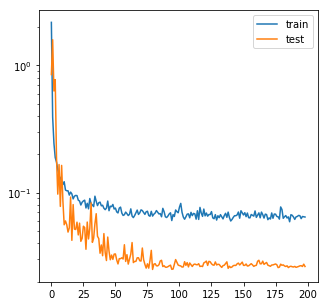

0.02494592003237677
0.026314343543897042
6.844646858424254e-07


In [51]:
imp.reload(augmentations)
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

batch_size = 128
learning_rate = 1e-3

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 200

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

Train Epoch: 1 [0/2005 (0%)]	Loss: 1.58664390
Train Epoch: 1 [256/2005 (12%)]	Loss: 5.71581492
Train Epoch: 1 [512/2005 (25%)]	Loss: 2.95453380
Train Epoch: 1 [768/2005 (38%)]	Loss: 1.70740610
Train Epoch: 1 [1024/2005 (50%)]	Loss: 1.34147265
Train Epoch: 1 [1280/2005 (62%)]	Loss: 1.16197064
Train Epoch: 1 [1536/2005 (75%)]	Loss: 1.00769348
Train Epoch: 1 [1792/2005 (88%)]	Loss: 1.20951194

Test set: Average loss: 1.4101606196

Train Epoch: 2 [0/2005 (0%)]	Loss: 0.85035467
Train Epoch: 2 [256/2005 (12%)]	Loss: 0.88244438
Train Epoch: 2 [512/2005 (25%)]	Loss: 0.87116390
Train Epoch: 2 [768/2005 (38%)]	Loss: 1.06378109
Train Epoch: 2 [1024/2005 (50%)]	Loss: 0.89055090
Train Epoch: 2 [1280/2005 (62%)]	Loss: 0.77100638
Train Epoch: 2 [1536/2005 (75%)]	Loss: 0.79224649
Train Epoch: 2 [1792/2005 (88%)]	Loss: 0.55626095

Test set: Average loss: 0.8475215271

Train Epoch: 3 [0/2005 (0%)]	Loss: 0.81680090
Train Epoch: 3 [256/2005 (12%)]	Loss: 0.67312369
Train Epoch: 3 [512/2005 (25%)]	Loss: 0.6

Train Epoch: 19 [1792/2005 (88%)]	Loss: 0.10707231

Test set: Average loss: 0.4051907513

Train Epoch: 20 [0/2005 (0%)]	Loss: 0.07117215
Train Epoch: 20 [256/2005 (12%)]	Loss: 0.13673499
Train Epoch: 20 [512/2005 (25%)]	Loss: 0.06500886
Train Epoch: 20 [768/2005 (38%)]	Loss: 0.13849154
Train Epoch: 20 [1024/2005 (50%)]	Loss: 0.12032314
Train Epoch: 20 [1280/2005 (62%)]	Loss: 0.12997778
Train Epoch: 20 [1536/2005 (75%)]	Loss: 0.13119409
Train Epoch: 20 [1792/2005 (88%)]	Loss: 0.17337099

Test set: Average loss: 0.2199645250

Train Epoch: 21 [0/2005 (0%)]	Loss: 0.21844853
Train Epoch: 21 [256/2005 (12%)]	Loss: 0.30319448
Train Epoch: 21 [512/2005 (25%)]	Loss: 0.25382608
Train Epoch: 21 [768/2005 (38%)]	Loss: 0.10959116
Train Epoch: 21 [1024/2005 (50%)]	Loss: 0.31330020
Train Epoch: 21 [1280/2005 (62%)]	Loss: 0.10997257
Train Epoch: 21 [1536/2005 (75%)]	Loss: 0.15148094
Train Epoch: 21 [1792/2005 (88%)]	Loss: 0.09448418

Test set: Average loss: 0.1082423111

Train Epoch: 22 [0/2005 (0%)]	

Train Epoch: 38 [1024/2005 (50%)]	Loss: 0.07527703
Train Epoch: 38 [1280/2005 (62%)]	Loss: 0.12943198
Train Epoch: 38 [1536/2005 (75%)]	Loss: 0.08308807
Train Epoch: 38 [1792/2005 (88%)]	Loss: 0.09630659

Test set: Average loss: 0.1771192463

Train Epoch: 39 [0/2005 (0%)]	Loss: 0.08483761
Train Epoch: 39 [256/2005 (12%)]	Loss: 0.07761845
Train Epoch: 39 [512/2005 (25%)]	Loss: 0.05512932
Train Epoch: 39 [768/2005 (38%)]	Loss: 0.06446890
Train Epoch: 39 [1024/2005 (50%)]	Loss: 0.04741785
Train Epoch: 39 [1280/2005 (62%)]	Loss: 0.09232490
Train Epoch: 39 [1536/2005 (75%)]	Loss: 0.07070007
Train Epoch: 39 [1792/2005 (88%)]	Loss: 0.09390672

Test set: Average loss: 0.0827107558

Train Epoch: 40 [0/2005 (0%)]	Loss: 0.11962627
Train Epoch: 40 [256/2005 (12%)]	Loss: 0.07212968
Train Epoch: 40 [512/2005 (25%)]	Loss: 0.08636262
Train Epoch: 40 [768/2005 (38%)]	Loss: 0.12625933
Train Epoch: 40 [1024/2005 (50%)]	Loss: 0.06772119
Train Epoch: 40 [1280/2005 (62%)]	Loss: 0.11966594
Train Epoch: 40 [1

Train Epoch: 57 [256/2005 (12%)]	Loss: 0.10144018
Train Epoch: 57 [512/2005 (25%)]	Loss: 0.10951662
Train Epoch: 57 [768/2005 (38%)]	Loss: 0.04062918
Train Epoch: 57 [1024/2005 (50%)]	Loss: 0.05849964
Train Epoch: 57 [1280/2005 (62%)]	Loss: 0.05834107
Train Epoch: 57 [1536/2005 (75%)]	Loss: 0.08680178
Train Epoch: 57 [1792/2005 (88%)]	Loss: 0.06634736

Test set: Average loss: 0.0294331347

Train Epoch: 58 [0/2005 (0%)]	Loss: 0.06303028
Train Epoch: 58 [256/2005 (12%)]	Loss: 0.15502253
Train Epoch: 58 [512/2005 (25%)]	Loss: 0.14928561
Train Epoch: 58 [768/2005 (38%)]	Loss: 0.13374546
Train Epoch: 58 [1024/2005 (50%)]	Loss: 0.06655303
Train Epoch: 58 [1280/2005 (62%)]	Loss: 0.07221872
Train Epoch: 58 [1536/2005 (75%)]	Loss: 0.06060303
Train Epoch: 58 [1792/2005 (88%)]	Loss: 0.15388512

Test set: Average loss: 0.0281258321

Train Epoch: 59 [0/2005 (0%)]	Loss: 0.06401769
Train Epoch: 59 [256/2005 (12%)]	Loss: 0.05161398
Train Epoch: 59 [512/2005 (25%)]	Loss: 0.10018161
Train Epoch: 59 [768

Train Epoch: 75 [1792/2005 (88%)]	Loss: 0.07530847

Test set: Average loss: 0.0330479973

Train Epoch: 76 [0/2005 (0%)]	Loss: 0.05767391
Train Epoch: 76 [256/2005 (12%)]	Loss: 0.13323380
Train Epoch: 76 [512/2005 (25%)]	Loss: 0.10064816
Train Epoch: 76 [768/2005 (38%)]	Loss: 0.08806921
Train Epoch: 76 [1024/2005 (50%)]	Loss: 0.06453305
Train Epoch: 76 [1280/2005 (62%)]	Loss: 0.06629146
Train Epoch: 76 [1536/2005 (75%)]	Loss: 0.06383678
Train Epoch: 76 [1792/2005 (88%)]	Loss: 0.08050783

Test set: Average loss: 0.0305205722

Train Epoch: 77 [0/2005 (0%)]	Loss: 0.05311431
Train Epoch: 77 [256/2005 (12%)]	Loss: 0.13308459
Train Epoch: 77 [512/2005 (25%)]	Loss: 0.07200037
Train Epoch: 77 [768/2005 (38%)]	Loss: 0.05086190
Train Epoch: 77 [1024/2005 (50%)]	Loss: 0.04417906
Train Epoch: 77 [1280/2005 (62%)]	Loss: 0.11066508
Train Epoch: 77 [1536/2005 (75%)]	Loss: 0.15285859
Train Epoch: 77 [1792/2005 (88%)]	Loss: 0.04688378

Test set: Average loss: 0.0388314424

Train Epoch: 78 [0/2005 (0%)]	

Train Epoch: 94 [1024/2005 (50%)]	Loss: 0.05159755
Train Epoch: 94 [1280/2005 (62%)]	Loss: 0.05494018
Train Epoch: 94 [1536/2005 (75%)]	Loss: 0.05062457
Train Epoch: 94 [1792/2005 (88%)]	Loss: 0.08396686

Test set: Average loss: 0.0253923259

Train Epoch: 95 [0/2005 (0%)]	Loss: 0.05007731
Train Epoch: 95 [256/2005 (12%)]	Loss: 0.09975414
Train Epoch: 95 [512/2005 (25%)]	Loss: 0.05396031
Train Epoch: 95 [768/2005 (38%)]	Loss: 0.22911430
Train Epoch: 95 [1024/2005 (50%)]	Loss: 0.05213257
Train Epoch: 95 [1280/2005 (62%)]	Loss: 0.07004076
Train Epoch: 95 [1536/2005 (75%)]	Loss: 0.08261041
Train Epoch: 95 [1792/2005 (88%)]	Loss: 0.05706626

Test set: Average loss: 0.0233557133

Train Epoch: 96 [0/2005 (0%)]	Loss: 0.06457236
Train Epoch: 96 [256/2005 (12%)]	Loss: 0.12509039
Train Epoch: 96 [512/2005 (25%)]	Loss: 0.06007138
Train Epoch: 96 [768/2005 (38%)]	Loss: 0.07498174
Train Epoch: 96 [1024/2005 (50%)]	Loss: 0.09787177
Train Epoch: 96 [1280/2005 (62%)]	Loss: 0.06440107
Train Epoch: 96 [1


Test set: Average loss: 0.0251343464

Train Epoch: 113 [0/2005 (0%)]	Loss: 0.07551031
Train Epoch: 113 [256/2005 (12%)]	Loss: 0.07499813
Train Epoch: 113 [512/2005 (25%)]	Loss: 0.06103318
Train Epoch: 113 [768/2005 (38%)]	Loss: 0.05258711
Train Epoch: 113 [1024/2005 (50%)]	Loss: 0.08627690
Train Epoch: 113 [1280/2005 (62%)]	Loss: 0.10548860
Train Epoch: 113 [1536/2005 (75%)]	Loss: 0.05063322
Train Epoch: 113 [1792/2005 (88%)]	Loss: 0.11594247

Test set: Average loss: 0.0219173031

Train Epoch: 114 [0/2005 (0%)]	Loss: 0.07213156
Train Epoch: 114 [256/2005 (12%)]	Loss: 0.05893740
Train Epoch: 114 [512/2005 (25%)]	Loss: 0.07833204
Train Epoch: 114 [768/2005 (38%)]	Loss: 0.04909953
Train Epoch: 114 [1024/2005 (50%)]	Loss: 0.08746906
Train Epoch: 114 [1280/2005 (62%)]	Loss: 0.05375206
Train Epoch: 114 [1536/2005 (75%)]	Loss: 0.09198942
Train Epoch: 114 [1792/2005 (88%)]	Loss: 0.07591098

Test set: Average loss: 0.0315734617

Train Epoch: 115 [0/2005 (0%)]	Loss: 0.14118338
Train Epoch: 115 

Train Epoch: 131 [512/2005 (25%)]	Loss: 0.06441513
Train Epoch: 131 [768/2005 (38%)]	Loss: 0.08191138
Train Epoch: 131 [1024/2005 (50%)]	Loss: 0.10165812
Train Epoch: 131 [1280/2005 (62%)]	Loss: 0.04077486
Train Epoch: 131 [1536/2005 (75%)]	Loss: 0.07211530
Train Epoch: 131 [1792/2005 (88%)]	Loss: 0.07585106

Test set: Average loss: 0.0226099978

Train Epoch: 132 [0/2005 (0%)]	Loss: 0.07500985
Train Epoch: 132 [256/2005 (12%)]	Loss: 0.06115242
Train Epoch: 132 [512/2005 (25%)]	Loss: 0.09483002
Train Epoch: 132 [768/2005 (38%)]	Loss: 0.07581934
Train Epoch: 132 [1024/2005 (50%)]	Loss: 0.04540760
Train Epoch: 132 [1280/2005 (62%)]	Loss: 0.05612500
Train Epoch: 132 [1536/2005 (75%)]	Loss: 0.05550369
Train Epoch: 132 [1792/2005 (88%)]	Loss: 0.06705593

Test set: Average loss: 0.0257787107

Train Epoch: 133 [0/2005 (0%)]	Loss: 0.06294183
Train Epoch: 133 [256/2005 (12%)]	Loss: 0.10392182
Train Epoch: 133 [512/2005 (25%)]	Loss: 0.07198039
Train Epoch: 133 [768/2005 (38%)]	Loss: 0.06714738
Tr

Train Epoch: 149 [1280/2005 (62%)]	Loss: 0.14485343
Train Epoch: 149 [1536/2005 (75%)]	Loss: 0.10218469
Train Epoch: 149 [1792/2005 (88%)]	Loss: 0.04694861

Test set: Average loss: 0.0246048346

Train Epoch: 150 [0/2005 (0%)]	Loss: 0.06341576
Train Epoch: 150 [256/2005 (12%)]	Loss: 0.10223218
Train Epoch: 150 [512/2005 (25%)]	Loss: 0.08247848
Train Epoch: 150 [768/2005 (38%)]	Loss: 0.07920227
Train Epoch: 150 [1024/2005 (50%)]	Loss: 0.04480913
Train Epoch: 150 [1280/2005 (62%)]	Loss: 0.04755930
Train Epoch: 150 [1536/2005 (75%)]	Loss: 0.15570350
Train Epoch: 150 [1792/2005 (88%)]	Loss: 0.07794510

Test set: Average loss: 0.0266904769

Train Epoch: 151 [0/2005 (0%)]	Loss: 0.06209971
Train Epoch: 151 [256/2005 (12%)]	Loss: 0.09036274
Train Epoch: 151 [512/2005 (25%)]	Loss: 0.06971854
Train Epoch: 151 [768/2005 (38%)]	Loss: 0.06995202
Train Epoch: 151 [1024/2005 (50%)]	Loss: 0.06881788
Train Epoch: 151 [1280/2005 (62%)]	Loss: 0.09022146
Train Epoch: 151 [1536/2005 (75%)]	Loss: 0.06663441



Test set: Average loss: 0.0245814791

Train Epoch: 168 [0/2005 (0%)]	Loss: 0.07211368
Train Epoch: 168 [256/2005 (12%)]	Loss: 0.07268132
Train Epoch: 168 [512/2005 (25%)]	Loss: 0.08118965
Train Epoch: 168 [768/2005 (38%)]	Loss: 0.09098708
Train Epoch: 168 [1024/2005 (50%)]	Loss: 0.06470010
Train Epoch: 168 [1280/2005 (62%)]	Loss: 0.08831442
Train Epoch: 168 [1536/2005 (75%)]	Loss: 0.08757072
Train Epoch: 168 [1792/2005 (88%)]	Loss: 0.07943803

Test set: Average loss: 0.0218341420

Train Epoch: 169 [0/2005 (0%)]	Loss: 0.07144603
Train Epoch: 169 [256/2005 (12%)]	Loss: 0.06867940
Train Epoch: 169 [512/2005 (25%)]	Loss: 0.08302815
Train Epoch: 169 [768/2005 (38%)]	Loss: 0.08653087
Train Epoch: 169 [1024/2005 (50%)]	Loss: 0.06869538
Train Epoch: 169 [1280/2005 (62%)]	Loss: 0.05815501
Train Epoch: 169 [1536/2005 (75%)]	Loss: 0.04839964
Train Epoch: 169 [1792/2005 (88%)]	Loss: 0.09472545

Test set: Average loss: 0.0216827397

Train Epoch: 170 [0/2005 (0%)]	Loss: 0.09995359
Train Epoch: 170 

Train Epoch: 186 [512/2005 (25%)]	Loss: 0.07567721
Train Epoch: 186 [768/2005 (38%)]	Loss: 0.06664729
Train Epoch: 186 [1024/2005 (50%)]	Loss: 0.15651499
Train Epoch: 186 [1280/2005 (62%)]	Loss: 0.04856221
Train Epoch: 186 [1536/2005 (75%)]	Loss: 0.07111839
Train Epoch: 186 [1792/2005 (88%)]	Loss: 0.09262246

Test set: Average loss: 0.0228737532

Train Epoch: 187 [0/2005 (0%)]	Loss: 0.06194231
Train Epoch: 187 [256/2005 (12%)]	Loss: 0.15738558
Train Epoch: 187 [512/2005 (25%)]	Loss: 0.07085232
Train Epoch: 187 [768/2005 (38%)]	Loss: 0.10330964
Train Epoch: 187 [1024/2005 (50%)]	Loss: 0.05470867
Train Epoch: 187 [1280/2005 (62%)]	Loss: 0.06120553
Train Epoch: 187 [1536/2005 (75%)]	Loss: 0.06397219
Train Epoch: 187 [1792/2005 (88%)]	Loss: 0.17025873

Test set: Average loss: 0.0240042021

Train Epoch: 188 [0/2005 (0%)]	Loss: 0.08740171
Train Epoch: 188 [256/2005 (12%)]	Loss: 0.06995035
Train Epoch: 188 [512/2005 (25%)]	Loss: 0.05412832
Train Epoch: 188 [768/2005 (38%)]	Loss: 0.05701692
Tr

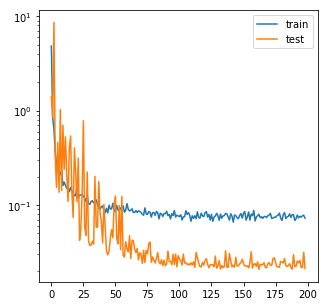

0.020809589744976965
0.0213208440594721
5.545783350710446e-07


In [52]:
imp.reload(augmentations)
h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

batch_size = 64
learning_rate = 1e-2

train_images, test_images, train_Y_origin, test_Y_origin = \
    train_test_split(images, Y, random_state=42, test_size=0.1)
Y_scaler = StandardScaler().fit(train_Y_origin.reshape(-1, 1))
train_Y = Y_scaler.transform(train_Y_origin.reshape(-1, 1)).flatten()
test_Y = Y_scaler.transform(test_Y_origin.reshape(-1, 1)).flatten()

train_dataset = MyDataset(train_images, train_Y, aug=train_aug)
# train_dataset = MyDataset(train_images, train_Y, aug=lambda image: {'image': image})
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size , 
                              shuffle=True, 
                              num_workers=10, 
                              pin_memory=True)

test_dataset = MyDataset(test_images, test_Y, aug=test_aug)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size , 
                             shuffle=False, 
                             num_workers=10, 
                             pin_memory=True)

model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** (epoch))
epochs_number = 200

train_perfomance = []
test_perfomance = []
for epoch in range(1, epochs_number):
    _ = train(model, device, train_dataloader, optimizer, scheduler, epoch, True)
    train_perfomance.append(_)
    gt, pred = test(model, device, test_dataloader)
    test_perfomance.append(((gt - pred) ** 2).mean())
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(train_perfomance)), train_perfomance)
plt.plot(np.arange(len(test_perfomance)), test_perfomance)
plt.yscale('log')
plt.legend(['train', 'test'])
plt.show()

print(np.min(test_perfomance))
print(((gt - pred) ** 2).mean())
print(((Y_scaler.inverse_transform(gt.reshape(-1, 1)).flatten() 
  - Y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()) ** 2).mean())

In [25]:
model = PretrainedNet(models.resnet34, pretrained=True).double().to(device)

In [ ]:
torch.save(model.state_dict, )